**1 Collecting Data**


## Improve thing

  2) A. สร้าง Environment และ State Vector (ตามหัวข้อ 5. Method ใน Paper)แผนของคุณระบุว่าจะใช้ Reinforcement Learning (RL) ซึ่งต้องการ "สภาพแวดล้อม (Environment)" ในการตัดสินใจ คุณต้องเขียน Code เพื่อรวมข้อมูลจากสองส่วนเข้าด้วยกันเป็น $S_t$:Macro Signal ($m_t$): เอาผล Forecast หรือค่า ECT/Coefficients จากโมเดล ARDL-ECM ที่คุณทำเสร็จแล้วมาเป็น FeatureTechnical Signal ($b_t$): เอาความน่าจะเป็น ($P_{bull}, P_{bear}, P_{neutral}$) หรือสัญญาณจากโมเดล LSTM/GRU มาเป็น FeaturePortfolio State: สถานะปัจจุบัน (ถือเงินสด, ถือหุ้น, ต้นทุน)สิ่งที่ต้องทำ: สร้าง Class Environment (เช่นสืบทอดจาก gym.Env) ที่รับค่าเหล่านี้เข้าไปในแต่ละ Step
  3) B. พัฒนาส่วน Reinforcement Learning (PPO Algorithm)ใน Code ปัจจุบันยังไม่พบส่วนที่เป็น PPO (Proximal Policy Optimization) หรือ Agent ที่ตัดสินใจ "ซื้อ/ขาย/ถือ"Action: คุณต้องกำหนด Action Space เป็น {Buy, Hold, Sell}Reward Function: เขียนสมการ Reward ตามแผน: $\text{Reward} = \text{Portfolio Value} - (\lambda \times \text{Drawdown Penalty})$Implementation: ใช้ Library เช่น stable-baselines3 หรือ rllib เพื่อสร้าง PPO Agent แล้วสั่ง Train ด้วย Environment ที่สร้างในข้อ A
  4) C. เพิ่มโมเดล CNN (Optional ตามแผน)
ในแผนระบุว่าจะใช้ CNN (Convolutional Neural Networks) ร่วมกับ LSTM เพื่อจับ Pattern กราฟ แต่ใน Code พบแค่ LSTM/GRU


5) D. การรวมระบบและ Backtesting (Phase 4)
Rolling Window Training: ต้องเขียน Loop เพื่อให้โมเดล Train ข้อมูลปี 2010-2024 และ Test ปี 2025 (Out-of-sample)



In [57]:
# !pip install fredapi

GDP Data
(https://)https://lookerstudio.google.com/u/0/reporting/52a283c8-91f9-4b35-8157-2b2b42312602/page/p_l7cxsbayvc

In [58]:
# ================== Setup ==================
# pip install yfinance fredapi pandas pandas-datareader

import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
from pandas_datareader import wb
from datetime import date
import io, requests
from pathlib import Path
import os

os.chdir('/Users/fulinq/Documents/KMITL/FinancialEngineering/Y4/Y4T1/PROJECT/ARDL-ECM/Code/Thai/Thai Update')

# ----- Parameters -----
START = "2013-01-01"
END   = date.today().isoformat()         # วันนี้
FRED_API_KEY = "c948956426006ca126a2dd3bd1f07cee"

# FRED client (กันอินเทอร์เน็ตล่ม)
try:
    fred = Fred(api_key=FRED_API_KEY)
except Exception:
    fred = None

# ================== Helper Functions ==================
def get_fred_series(series_id: str, rename_to: str = None) -> pd.Series:
    """ดึงซีรีส์จาก FRED"""
    if fred is None:
        return pd.Series(dtype="float64", name=rename_to or series_id)
    s = fred.get_series(series_id)
    s.name = rename_to or series_id
    s.index = pd.to_datetime(s.index)
    return s.sort_index()

def expand_period_to_target_index(target_index: pd.DatetimeIndex,
                                  lowfreq_series: pd.Series,
                                  freq: str) -> pd.Series:
    """ขยายค่าความถี่ต่ำไปที่ target_index"""
    if lowfreq_series is None or lowfreq_series.empty:
        return pd.Series(index=target_index, dtype="float64", name=getattr(lowfreq_series, "name", None))
    s = lowfreq_series.dropna().copy()
    s.index = pd.PeriodIndex(s.index, freq=freq)
    df = pd.DataFrame(index=target_index)
    df["period"] = df.index.to_period(freq)
    out = df.join(s.rename(s.name), on="period")[s.name]
    out.name = s.name
    return out

# ================== 2) Macro: ใช้ Macro_data.xlsx ==================
macro_candidates = [Path("/mnt/data/Macro_data.xlsx"), Path("Macro_data.xlsx")]
macro_path = next((str(p) for p in macro_candidates if p.exists()), "Macro_data.xlsx")

macro = pd.read_excel(macro_path, sheet_name=0)

def _pct_to_float(col: pd.Series) -> pd.Series:
    """แปลงคอลัมน์ % ให้เป็นตัวเลข"""
    return (
        col.astype(str)
           .str.strip()
           .str.replace(",", "", regex=False)
           .str.replace("%", "", regex=False)
           .str.replace("(", "-", regex=False)
           .str.replace(")", "", regex=False)
           .replace({"": None})
           .pipe(pd.to_numeric, errors="coerce")
    )

macro["Date"] = pd.to_datetime(macro["Date"], dayfirst=True, errors="coerce")

for col in ["CPI_Actual", "CPI_Forecast", "IPI_Actual", "IPI_Forecast"]:
    if col in macro.columns:
        macro[col] = _pct_to_float(macro[col])

macro = (macro.rename(columns={
            "M1M2_Actual": "BroadMoney_M1M2_Level",
            "CPI_Actual": "Inflation",
            "CPI_Forecast": "Inflation_Forecast",
            "THOR_1M": "THOR_1M",
            "THOR_3M": "THOR_3M",
            "THOR_6M": "THOR_6M",
            "IPI_Actual": "IPI",
            "IPI_Forecast": "IPI_Forecast",
            "Bond_1Y": "Bond_Yield_1Y",
            "Bond_5Y": "Bond_Yield_5Y",
            "Bond_10Y": "Bond_Yield_10Y",
            "Bond_spread_10Y_5Y": "Yield_Spread_10Y_5Y",
            "Bond_spread_5Y_1Y": "Yield_Spread_5Y_1Y",
            "Bond_spread_10Y_1Y": "Yield_Spread_10Y_1Y"
        })
        .sort_values("Date")
        .set_index("Date"))

# ================== 1) Stock Prices ==================
SECTORS = {
    "Banking": ["BBL","KBANK","KKP","KTB","TCAP","TISCO","TTB"],
    "Finance_Securities": ["KTC","AEONTS","JMT","SAWAD"],
    # "Energy_Utilities": ["BANPU","BCP","EGCO","GPSC","GULF","OR","PTT","PTTEP","RATCH","TOP","BGRIM","BCPG","EA","GUNKUL","IRPC","SPRC","WHAUP","CKP"],
    # "Food_Beverage": ["CBG","CPF","OSP","TU","ITC","BTG","ICHI","M","TFG","COCOCO","SAPPE","SNNP"],
    # "Commerce": ["BJC","COM7","CPALL","CRC","HMPRO","GLOBAL","DOHOME","MEGA","MOSHI"],
    # "Property_Development": ["AWC","CPN","LH","WHA","AMATA","AP","MBK","QH","SIRI","SPALI","ROJNA"],
    # "Health_Care_Services": ["BDMS","BH","BCH","CHG"],       =>
    # "Electronic_Components": ["CCET","DELTA","HANA","KCE"],
    # "Construction_Materials": ["SCC","TASCO","TOA"],
    # "ICT": ["ADVANC","TRUE","JAS","JMART","JTS","SKY"],
    # "Transportation_Logistics": ["AOT","BEM","BTS","AAV","BA","RCL"],     =>
}

df_stocks = pd.DataFrame()
for sector, tickers in SECTORS.items():
    for ticker in tickers:
        try:
            ticker_yf = ticker + ".BK"
            data = yf.download(ticker_yf, start=START, end=END, interval="1mo")['Close']
            if isinstance(data, pd.Series):
                df_stocks[f"Close_{ticker}"] = data
            else:
                df_stocks[f"Close_{ticker}"] = data[ticker_yf]
        except Exception:
            df_stocks[f"Close_{ticker}"] = pd.Series(dtype="float64")

df_stocks = df_stocks.dropna(how="all")

if not df_stocks.empty:
    quarterly_index = df_stocks.index
else:
    quarterly_index = pd.date_range(start=pd.to_datetime(START), end=pd.to_datetime(END), freq="QS")

# ================== 2) Align Macro ==================
if not macro.index.is_unique:
    macro = macro[~macro.index.duplicated(keep="last")]

macro_q = macro.reindex(quarterly_index, method="ffill")

# FX THB/USD
fx_thb_usd = yf.download("THB=X", start=START, end=END, interval="1mo")["Close"]
fx_thb_usd.name = "THB_per_USD"

# FX THB/CNY
fx_thb_cny = yf.download("THBCNY=X", start=START, end=END, interval="1mo")["Close"]
fx_thb_cny.name = "THB_per_CNY"

# FX THB/INR
fx_thb_inr = yf.download("THBINR=X", start=START, end=END, interval="1mo")["Close"]
fx_thb_inr.name = "THB_per_INR"

# Brent Oil (USD per barrel)
brent_data = yf.download("BZ=F", start=START, end=END, interval="1mo")["Close"]
brent_data.name = "Brent_Oil_USD_per_bbl"

# CRB Index
crb_data = yf.download("^CRB", start=START, end=END, interval="1mo")["Close"]
crb_data.name = "CRB_Index"

# S&P 500 Index
sp500_data = yf.download("^GSPC", start=START, end=END, interval="1mo")["Close"]
sp500_data.name = "SP500_Index"

# SET Index (Thailand)
set_daily = yf.download("^SET.BK", start=START, end=END, interval="1d")["Close"]

# --- เลือกราคาปิดของ "วันแรกของแต่ละเดือน" ---
set_monthly = set_daily.resample("MS").first()
set_monthly.name = "SET_Index"

# ================== 4) Combine หุ้น + Macro ==================
df = df_stocks.copy()
if df.empty:
    df = pd.DataFrame(index=quarterly_index)

# Macro Variables
if "Inflation" in macro_q.columns:
    df["Inflation"] = macro_q["Inflation"] / 100.0
if "Inflation_Forecast" in macro_q.columns:
    df["Inflation_Forecast"] = macro_q["Inflation_Forecast"] / 100.0
if "IPI" in macro_q.columns:
    df["IPI"] = macro_q["IPI"] / 100.0
if "IPI_Forecast" in macro_q.columns:
    df["IPI_Forecast"] = macro_q["IPI_Forecast"] / 100.0

# ✅ BroadMoney: ใช้สูตร ln(S_t / S_{t-1}) และให้แถวแรกเป็น 0
if "BroadMoney_M1M2_Level" in macro_q.columns:
    money_series = macro_q["BroadMoney_M1M2_Level"]
    money_growth = np.log(money_series / money_series.shift(1))
    money_growth.iloc[0] = 0.0  # แถวแรกให้เป็น 0%
    df["BroadMoney_M1M2_Growth"] = money_growth

# Interest Rates
for col in ["THOR_1M", "THOR_3M", "THOR_6M",
            "Bond_Yield_1Y", "Bond_Yield_5Y", "Bond_Yield_10Y",
            "Yield_Spread_10Y_5Y", "Yield_Spread_5Y_1Y", "Yield_Spread_10Y_1Y"]:
    if col in macro_q.columns:
        df[col] = macro_q[col]

# Combine Global Indicators
df["THB_per_USD"] = fx_thb_usd
df["THB_per_CNY"] = fx_thb_cny
df["THB_per_INR"] = fx_thb_inr
# df["Brent_Oil_USD_per_bbl"] = brent_data
df["CRB_Index"] = crb_data
df["SP500_Index"] = sp500_data
df["SET_Index"] = set_monthly

df['IPI_Surprise'] = df['IPI'] - df['IPI_Forecast']
df['Inflation_Surprise'] = df['Inflation'] - df['Inflation_Forecast']
df['5Y_1Y_Bond_Spread'] = df["Bond_Yield_5Y"] - df["Bond_Yield_1Y"]
df['10Y_5Y_Bond_Spread'] = df["Bond_Yield_10Y"] - df["Bond_Yield_5Y"]
df['3M_1M_THOR_Spread'] = df["THOR_3M"] - df["THOR_1M"]
df['6M_1M_THOR_Spread'] = df["THOR_6M"] - df["THOR_1M"]



# ================== 5) ตรวจสอบผลลัพธ์ ==================
df = df.iloc[25:]
df.drop(["CRB_Index"], axis=1, inplace=True)

print(df)
print("\n=== HEAD ===")
print(df.head(10))
print("\n=== TAIL ===")
print(df.tail(10))
print("\n=== COLUMNS ===")
print(df.columns.tolist())
print("\n=== NA COUNTS ===")
print(df.isna().sum())

# (Optional) Save to CSV
# df.to_csv("th_stock_macro_2013_today_quarterly.csv", encoding="utf-8-sig")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

             Close_BBL  Close_KBANK  Close_KKP  Close_KTB  Close_TCAP  \
Date                                                                    
2015-02-01  120.324265   151.045517  18.905376  13.843616   16.486794   
2015-03-01  121.310516   159.398285  18.784962  13.843616   16.369032   
2015-04-01  121.639275   146.173080  17.821629  12.143525   16.015741   
2015-05-01  122.538742   137.793182  17.965868  11.427541   16.611538   
2015-06-01  119.845589   133.553406  17.591581  10.796186   16.126524   
...                ...          ...        ...        ...         ...   
2025-10-01  158.500000   186.500000  65.750000  26.823908   51.000000   
2025-11-01  158.000000   186.500000  64.250000  27.070000   54.500000   
2025-12-01  169.500000   194.500000  68.000000  28.250000   58.250000   
2026-01-01  158.000000   188.000000  72.000000  28.250000   59.000000   
2026-02-01  163.500000   195.500000  72.000000  30.250000   57.000000   

            Close_TISCO  Close_TTB  Close_KTC  Clo

| Component               | Description                                    | Paper                 |
| ----------------------- | ---------------------------------------------- | --------------------- |
| Proxy selection         | Dynamic Factor / PCA on macro dataset          | Stock & Watson (2002) |
| Temporal disaggregation | Chow-Lin linear regression                     | Chow & Lin (1971)     |
| Extrapolation           | AR(1) residual correction (Fernandez model)    | Fernandez (1981)      |
| Ratio preservation      | Denton (1971) for % variables (e.g., Debt/GDP) | Denton (1971)         |

📘 Academic Framework (สำหรับ citation ใน report)

Chow & Lin (1971) – Best Linear Unbiased Interpolation by Related Series

Stock & Watson (2002) – Macroeconomic Forecasting Using Diffusion Indexes

Mariano & Murasawa (2003) – A New Coincident Index of Business Cycles Based on Monthly and Quarterly Series


In [59]:
# ============================================================
# 📊 BLOCK 1.5: Chow-Lin Temporal Disaggregation (GDP Quarterly → Monthly)
#    Reference: Chow & Lin (1971) - Best Linear Unbiased Interpolation
#    Insert this block AFTER Block 1 (Data Collection) and BEFORE Block 2
# ============================================================

import numpy as np
import pandas as pd
from scipy import linalg

# ================== 1) Chow-Lin Function ==================
def chow_lin_disaggregate(y_low: pd.Series, X_high: pd.DataFrame,
                          agg_method: str = 'sum', rho: float = None) -> tuple:
    """
    Chow-Lin temporal disaggregation: แปลง Low-frequency → High-frequency

    Parameters:
    -----------
    y_low : pd.Series
        Low-frequency series (e.g., Quarterly GDP) with DatetimeIndex
    X_high : pd.DataFrame
        High-frequency indicator(s) (e.g., Monthly IPI) with DatetimeIndex
    agg_method : str
        'sum' for flow variables (GDP), 'mean' for stock/average variables
    rho : float or None
        AR(1) autocorrelation parameter. If None, estimate from data.

    Returns:
    --------
    tuple: (pd.Series of monthly data, beta coefficients, estimated rho)
    """

    # 1) Align data
    y_low = y_low.dropna().copy()
    X_high = X_high.dropna().copy()

    # Determine frequency ratio (3 for Q→M)
    n_high_per_low = 3  # Monthly to Quarterly

    # 2) Create date mapping
    quarters = y_low.index
    months = X_high.index

    # Filter to overlapping period
    min_date = max(quarters.min(), months.min().to_period('Q').to_timestamp())
    max_date = min(quarters.max(), months.max().to_period('Q').to_timestamp())

    y_low = y_low[(y_low.index >= min_date) & (y_low.index <= max_date)]

    # Get monthly data for the period
    month_start = y_low.index.min()
    month_end = (y_low.index.max() + pd.offsets.QuarterEnd()).to_period('M').to_timestamp()

    X_high = X_high[(X_high.index >= month_start) & (X_high.index <= month_end)]

    n_low = len(y_low)
    n_high = n_low * n_high_per_low

    # Trim X_high to exact size
    X_high = X_high.iloc[:n_high]

    if len(X_high) < n_high:
        print(f"⚠️ Warning: Not enough high-freq data. Need {n_high}, have {len(X_high)}")
        # Pad with last value
        pad_size = n_high - len(X_high)
        last_idx = X_high.index[-1]
        new_idx = pd.date_range(start=last_idx + pd.offsets.MonthBegin(), periods=pad_size, freq='MS')
        pad_df = pd.DataFrame(index=new_idx, columns=X_high.columns)
        for col in X_high.columns:
            pad_df[col] = X_high[col].iloc[-1]
        X_high = pd.concat([X_high, pad_df])

    # 3) Build aggregation matrix C (n_low x n_high)
    C = np.zeros((n_low, n_high))
    for i in range(n_low):
        start_col = i * n_high_per_low
        end_col = start_col + n_high_per_low
        if agg_method == 'sum':
            C[i, start_col:end_col] = 1.0
        elif agg_method == 'mean':
            C[i, start_col:end_col] = 1.0 / n_high_per_low
        else:  # 'last'
            C[i, end_col - 1] = 1.0

    # 4) Prepare X matrix (add constant)
    X = X_high.values
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    X = np.column_stack([np.ones(n_high), X])  # Add intercept

    # 5) Aggregate X to match y_low
    X_low = C @ X
    y = y_low.values.flatten()

    # 6) OLS on aggregated data
    beta_ols = np.linalg.lstsq(X_low, y, rcond=None)[0]
    u_low = y - X_low @ beta_ols

    # 7) Estimate rho (AR1 coefficient) if not provided
    if rho is None:
        if len(u_low) > 1:
            rho = np.corrcoef(u_low[:-1], u_low[1:])[0, 1]
            rho = np.clip(rho, -0.99, 0.99)
        else:
            rho = 0.0

    # 8) Build covariance matrix V (AR1 structure)
    V = np.zeros((n_high, n_high))
    for i in range(n_high):
        for j in range(n_high):
            V[i, j] = rho ** abs(i - j)

    # 9) GLS estimation
    V_low = C @ V @ C.T
    try:
        V_low_inv = np.linalg.inv(V_low)
    except np.linalg.LinAlgError:
        V_low_inv = np.linalg.pinv(V_low)

    XVX = X_low.T @ V_low_inv @ X_low
    XVy = X_low.T @ V_low_inv @ y
    try:
        beta_gls = np.linalg.solve(XVX, XVy)
    except np.linalg.LinAlgError:
        beta_gls = np.linalg.lstsq(XVX, XVy, rcond=None)[0]

    # 10) Preliminary high-frequency estimate
    p_high = X @ beta_gls

    # 11) Distribute residuals
    u_low_gls = y - X_low @ beta_gls
    VCt = V @ C.T
    try:
        dist_matrix = VCt @ np.linalg.inv(V_low)
    except np.linalg.LinAlgError:
        dist_matrix = VCt @ np.linalg.pinv(V_low)

    # Final disaggregated series
    y_high = p_high + dist_matrix @ u_low_gls

    # 12) Create output Series
    result = pd.Series(y_high, index=X_high.index, name=y_low.name or 'GDP_Monthly')

    return result, beta_gls, rho


# ================== 2) Load GDP Quarterly Data ==================
print("="*60)
print("📊 BLOCK 1.5: Chow-Lin Temporal Disaggregation")
print("="*60)

print("\n📥 Loading GDP Quarterly data...")

gdp_df = pd.read_excel("thai_gdp_quarterly_full.xlsx", sheet_name=0)

# Create proper datetime index
quarter_map = {'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'}
gdp_df['Date'] = gdp_df.apply(
    lambda row: pd.Timestamp(f"{row['Year']}-{quarter_map[row['Quarter']]}-01"),
    axis=1
)
gdp_df = gdp_df.set_index('Date').sort_index()

# Use Total_CUR (Current Price GDP)
gdp_quarterly = gdp_df['Total_CUR'].copy()
gdp_quarterly.name = 'GDP_CUR'

print(f"✅ GDP Quarterly loaded: {len(gdp_quarterly)} quarters")
print(f"   Period: {gdp_quarterly.index.min().strftime('%Y-%m')} to {gdp_quarterly.index.max().strftime('%Y-%m')}")


# ================== 3) Prepare IPI as High-Frequency Indicator ==================
print("\n📥 Preparing IPI as high-frequency indicator...")

# IPI should already be in 'df' from Block 1
# If running standalone, load from Macro_data.xlsx
if 'df' not in globals() or 'IPI' not in df.columns:
    macro_temp = pd.read_excel("Macro_data.xlsx", sheet_name=0)
    macro_temp['Date'] = pd.to_datetime(macro_temp['Date'], dayfirst=True, errors='coerce')
    macro_temp = macro_temp.set_index('Date').sort_index()
    ipi_monthly = macro_temp['IPI_Actual'].dropna().copy()
else:
    ipi_monthly = df['IPI'].dropna().copy()

ipi_monthly.name = 'IPI'

# Convert to level if it's in growth rate form
if ipi_monthly.abs().mean() < 1:  # It's in decimal/percentage
    ipi_level = (1 + ipi_monthly).cumprod() * 100
else:
    ipi_level = ipi_monthly

ipi_level.name = 'IPI_Level'

print(f"✅ IPI Monthly loaded: {len(ipi_level)} months")
print(f"   Period: {ipi_level.index.min().strftime('%Y-%m')} to {ipi_level.index.max().strftime('%Y-%m')}")


# ================== 4) Apply Chow-Lin Disaggregation ==================
print("\n🔄 Applying Chow-Lin disaggregation (GDP Quarterly → Monthly)...")

X_indicator = pd.DataFrame({'IPI': ipi_level})

gdp_monthly, beta_chowlin, rho_chowlin = chow_lin_disaggregate(
    y_low=gdp_quarterly,
    X_high=X_indicator,
    agg_method='sum',  # GDP is a flow variable
    rho=None  # Auto-estimate
)

# Calculate GDP Growth Rate (Monthly, Log %)
gdp_growth_monthly = np.log(gdp_monthly / gdp_monthly.shift(1))
gdp_growth_monthly.name = 'GDP_Growth_Monthly'

print(f"\n✅ Chow-Lin disaggregation completed!")
print(f"   - Estimated AR(1) rho: {rho_chowlin:.4f}")
print(f"   - Monthly GDP observations: {len(gdp_monthly)}")


# ================== 5) Validation ==================
print("\n🔍 Validation: Aggregating monthly back to quarterly...")

gdp_monthly_to_q = gdp_monthly.resample('QS').sum()
validation = pd.DataFrame({
    'Original_Q': gdp_quarterly,
    'ChowLin_Agg_Q': gdp_monthly_to_q
}).dropna()
validation['Error_%'] = abs(validation['ChowLin_Agg_Q'] - validation['Original_Q']) / validation['Original_Q'] * 100

print(f"✅ Mean Aggregation Error: {validation['Error_%'].mean():.6f}%")
print("   (Should be ~0% if Chow-Lin is working correctly)")


# ================== 6) Add to Main DataFrame ==================
print("\n📌 Adding GDP_Monthly and GDP_Growth to main dataframe...")

# Reindex to match the main df index
if 'df' in globals():
    # Add GDP columns to df
    df['GDP_Monthly'] = gdp_monthly.reindex(df.index)
    df['GDP_Growth'] = gdp_growth_monthly.reindex(df.index)

    # Forward fill any gaps (for dates where we have stock data but no GDP yet)
    df['GDP_Monthly'] = df['GDP_Monthly'].ffill()
    df['GDP_Growth'] = df['GDP_Growth'].ffill()

    print(f"✅ Added 'GDP_Monthly' and 'GDP_Growth' to df")
    print(f"   df shape: {df.shape}")
    print(f"\n📊 GDP columns preview:")
    print(df[['GDP_Monthly', 'GDP_Growth']].dropna().tail(10))
else:
    print("⚠️ Main dataframe 'df' not found. Creating standalone GDP dataframe...")
    gdp_output = pd.DataFrame({
        'GDP_Monthly': gdp_monthly,
        'GDP_Growth': gdp_growth_monthly
    })
    print(gdp_output.tail(10))


# ================== 7) Summary ==================
print("\n" + "="*60)
print("✅ BLOCK 1.5 COMPLETED: Chow-Lin Temporal Disaggregation")
print("="*60)
print(f"""
Summary:
- Input:  GDP Quarterly (Total_CUR) - {len(gdp_quarterly)} quarters
- Output: GDP Monthly - {len(gdp_monthly)} months
- Indicator used: IPI (Industrial Production Index)
- Method: Chow-Lin (1971) with AR(1) residual structure
- Estimated rho: {rho_chowlin:.4f}

New columns added to df:
- 'GDP_Monthly': Monthly GDP level (Current Price, Mil THB)
- 'GDP_Growth': Monthly GDP growth rate (Log %)
""")

📊 BLOCK 1.5: Chow-Lin Temporal Disaggregation

📥 Loading GDP Quarterly data...
✅ GDP Quarterly loaded: 51 quarters
   Period: 2013-01 to 2025-07

📥 Preparing IPI as high-frequency indicator...
✅ IPI Monthly loaded: 133 months
   Period: 2015-02 to 2026-02

🔄 Applying Chow-Lin disaggregation (GDP Quarterly → Monthly)...
⚠️ Warning: Not enough high-freq data. Need 129, have 128

✅ Chow-Lin disaggregation completed!
   - Estimated AR(1) rho: 0.8322
   - Monthly GDP observations: 129

🔍 Validation: Aggregating monthly back to quarterly...
✅ Mean Aggregation Error: 1.868700%
   (Should be ~0% if Chow-Lin is working correctly)

📌 Adding GDP_Monthly and GDP_Growth to main dataframe...
✅ Added 'GDP_Monthly' and 'GDP_Growth' to df
   df shape: (133, 38)

📊 GDP columns preview:
             GDP_Monthly  GDP_Growth
Date                                
2025-05-01  1.536566e+06   -0.019544
2025-06-01  1.521829e+06   -0.009637
2025-07-01  1.522122e+06    0.000192
2025-08-01  1.537391e+06    0.009982

**2 Data preprocessing**

In [60]:
# =====================================================
# ⚙️ BLOCK 2: Prepare Combined Data (No PCA, No LASSO)
#   ✅ PATCH: Macro release-lag shift (no look-ahead)
# =====================================================

import numpy as np
import pandas as pd

# ======== 1) Filter & split ========
df_filtered = df.iloc[14:].copy()  # ตัดช่วงแรกที่ NA เยอะ

# เลือกหุ้น
stock_columns = [c for c in df_filtered.columns if c.startswith("Close_")]
selected_stock_data = df_filtered[stock_columns]

# เลือกตัวแปร macro ที่มีอยู่จริง
macro_columns = [
    "BroadMoney_M1M2_Growth",
    "Inflation_Surprise",   # CPI
    "IPI_Surprise",
    "THOR_1M",
    "THOR_6M",
    "3M_1M_THOR_Spread",
    "6M_1M_THOR_Spread",
    "5Y_1Y_Bond_Spread",
    "10Y_5Y_Bond_Spread",
    "THB_per_USD",
    "SP500_Index",
    "SET_Index",
    "THB_per_CNY",
    "GDP_Growth",
    "THB_per_INR"
]
macro_columns = [c for c in macro_columns if c in df_filtered.columns]
selected_macro_data = df_filtered[macro_columns].copy()

# ======== 🆕 1.5) SHIFT MACROS (release-lag) ========
SHIFT_MAP = {
    "GDP_Growth": 2,
    "BroadMoney_M1M2_Growth": 2,
    "IPI_Surprise": 1,
    "Inflation_Surprise": 1,
}

for col, s in SHIFT_MAP.items():
    if col in selected_macro_data.columns:
        selected_macro_data[col] = selected_macro_data[col].shift(s)

# สำคัญ: ห้าม bfill (จะดึงอนาคตย้อนกลับมา)
# จะ ffill หรือปล่อย NaN แล้ว drop ตอนหลัง ก็ได้
selected_macro_data = selected_macro_data.ffill()

print("✅ Applied macro shifts:",
      {k: v for k, v in SHIFT_MAP.items() if k in selected_macro_data.columns})

# ======== 2) Combine + clean ========
combined_df = pd.concat([selected_stock_data, selected_macro_data], axis=1)
combined_df = combined_df.ffill().replace([np.inf, -np.inf], np.nan).dropna(how="any")

print("✅ Combined data shape:", combined_df.shape)
print("✅ Stocks:", len(stock_columns), "| Macros:", len(macro_columns))

# ======== 3) Log-transform หุ้นและสร้าง Δlog ========
combined_dfs = combined_df.copy()
for c in stock_columns:
    combined_dfs[f"Logclose_{c.replace('Close_','')}"] = np.log(combined_df[c])

combined_dfs_diff = combined_dfs.copy()
for c in stock_columns:
    stock_name = c.replace("Close_","")
    combined_dfs_diff[f"D_Logclose_{stock_name}"] = combined_dfs[f"Logclose_{stock_name}"].diff()

# ======== 4) Drop แถวแรกของ differenced ========
combined_dfs_diff = combined_dfs_diff.dropna()

print("✅ Differenced data ready:", combined_dfs_diff.shape)

# ======== 5) ตัวอย่างผลลัพธ์ ========
print("\n=== Combined_dfs (Levels) ===")
display(combined_dfs.head())

print("\n=== Combined_dfs_diff (Differenced) ===")
display(combined_dfs_diff.head())


✅ Applied macro shifts: {'GDP_Growth': 2, 'BroadMoney_M1M2_Growth': 2, 'IPI_Surprise': 1, 'Inflation_Surprise': 1}
✅ Combined data shape: (117, 26)
✅ Stocks: 11 | Macros: 15
✅ Differenced data ready: (116, 48)

=== Combined_dfs (Levels) ===


,Close_BBL,Close_KBANK,Close_KKP,Close_KTB,Close_TCAP,Close_TISCO,Close_TTB,Close_KTC,Close_AEONTS,Close_JMT,...,Logclose_KBANK,Logclose_KKP,Logclose_KTB,Logclose_TCAP,Logclose_TISCO,Logclose_TTB,Logclose_KTC,Logclose_AEONTS,Logclose_JMT,Logclose_SAWAD
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-01,111.023796,123.027870,23.455120,10.761126,17.897362,25.046579,1.323992,8.134514,70.771057,4.203393,...,4.812411,3.155089,2.375940,2.884653,3.220737,0.280651,2.096116,4.259450,1.435892,3.124680
2016-07-01,119.429398,142.929504,28.307907,11.487338,20.837641,27.323538,1.385288,10.040081,73.528358,5.117174,...,4.962352,3.343141,2.441245,3.036761,3.307749,0.325908,2.306585,4.297671,1.632602,3.137752
2016-08-01,118.728928,142.929504,27.903507,12.543644,20.454126,27.323538,1.385288,11.392419,72.609253,5.336482,...,4.962352,3.328752,2.529214,3.018185,3.307749,0.325908,2.432948,4.285092,1.674567,3.163394
2016-09-01,113.825668,135.692566,28.577501,11.619376,20.709805,26.564550,1.299473,12.089077,73.344543,5.117174,...,4.910392,3.352620,2.452674,3.030607,3.279578,0.261959,2.492302,4.295168,1.632602,3.070613
2016-10-01,113.074425,124.805435,32.871223,11.355300,20.198446,26.185061,1.287215,12.293976,72.057785,5.519238,...,4.826756,3.492598,2.429685,3.005606,3.265189,0.252481,2.509109,4.277468,1.708240,3.175973



=== Combined_dfs_diff (Differenced) ===


,Close_BBL,Close_KBANK,Close_KKP,Close_KTB,Close_TCAP,Close_TISCO,Close_TTB,Close_KTC,Close_AEONTS,Close_JMT,...,D_Logclose_KBANK,D_Logclose_KKP,D_Logclose_KTB,D_Logclose_TCAP,D_Logclose_TISCO,D_Logclose_TTB,D_Logclose_KTC,D_Logclose_AEONTS,D_Logclose_JMT,D_Logclose_SAWAD
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-01,119.429398,142.929504,28.307907,11.487338,20.837641,27.323538,1.385288,10.040081,73.528358,5.117174,...,0.149941,0.188052,0.065305,0.152108,0.087011,0.045257,0.210469,0.038221,0.196710,0.013072
2016-08-01,118.728928,142.929504,27.903507,12.543644,20.454126,27.323538,1.385288,11.392419,72.609253,5.336482,...,0.000000,-0.014389,0.087969,-0.018576,0.000000,0.000000,0.126363,-0.012579,0.041964,0.025642
2016-09-01,113.825668,135.692566,28.577501,11.619376,20.709805,26.564550,1.299473,12.089077,73.344543,5.117174,...,-0.051960,0.023867,-0.076540,0.012423,-0.028171,-0.063949,0.059354,0.010076,-0.041964,-0.092782
2016-10-01,113.074425,124.805435,32.871223,11.355300,20.198446,26.185061,1.287215,12.293976,72.057785,5.519238,...,-0.083636,0.139978,-0.022989,-0.025002,-0.014389,-0.009478,0.016807,-0.017700,0.075637,0.105361
2016-11-01,110.593155,122.991417,31.045038,11.619376,22.944519,27.323538,1.238178,11.966137,77.745308,6.688878,...,-0.014641,-0.057159,0.022989,0.127473,0.042559,-0.038840,-0.027029,0.075970,0.192206,0.024692


In [61]:
# ======== Filter sector log-prices + macro variables ========

# Macro columns ที่มีอยู่จริงใน Excel + yfinance
macro_columns = [
    "BroadMoney_M1M2_Growth",
    "Inflation_Surprise",
    "IPI_Surprise",
    "THOR_1M",
    "THOR_6M",
    "3M_1M_THOR_Spread",
    "6M_1M_THOR_Spread",
    "5Y_1Y_Bond_Spread",
    "10Y_5Y_Bond_Spread",
    "THB_per_USD",
    # "Brent_Oil_USD_per_bbl",
    "SP500_Index",
    "SET_Index",
    "THB_per_CNY",
    "GDP_Growth" ,
    "THB_per_INR"

]



# ======== ตรวจสอบว่า df ถูกสร้างแล้วจาก Block ก่อนหน้า ========
if 'df' not in globals():
    raise RuntimeError("❌ Variable 'df' not found. Please run the data-preparation block first.")

df_filtered_macro = df

# เก็บผลลัพธ์แยก sector
combined_dfs = {}

for sector, tickers_list in SECTORS.items():
    sector_frames = []

    for ticker in tickers_list:
        colname = f"Close_{ticker}"
        if colname not in df.columns:
            print(f"⚠️ {colname} not found in df. Skipping...")
            continue

        # ✅ ใช้ Logclose แทน log-return
        tmp = df[[colname]].copy()
        tmp[f"Logclose_{ticker}"] = np.log(tmp[colname])
        tmp = tmp[[f"Logclose_{ticker}"]]

        # align index ให้ตรงกับ macro
        tmp = tmp.loc[df_filtered_macro.index]
        sector_frames.append(tmp)

    if len(sector_frames) == 0:
        continue

    # รวม Logclose ของหุ้นทุกตัวใน sector
    sector_data = pd.concat(sector_frames, axis=1)

    # รวมกับ macro
    combined_df = pd.concat([sector_data, df_filtered_macro], axis=1).ffill()

    # ตัดข้อมูลปี 2025 (ป้องกัน incomplete data)
    combined_df = combined_df[combined_df.index.year != 2025]

    combined_dfs[sector] = combined_df

# ======== แสดงตัวอย่างผลลัพธ์ ========
for sector, combined_df in combined_dfs.items():
    print(f"\n📊 Combined data for sector: {sector}")
    cols_to_show = [c for c in combined_df.columns if c.startswith("Logclose_")] + macro_columns
    cols_to_show_present = [col for col in cols_to_show if col in combined_df.columns]
    display(combined_df[cols_to_show_present].head())



📊 Combined data for sector: Banking


,Logclose_BBL,Logclose_KBANK,Logclose_KKP,Logclose_KTB,Logclose_TCAP,Logclose_TISCO,Logclose_TTB,BroadMoney_M1M2_Growth,Inflation_Surprise,IPI_Surprise,...,3M_1M_THOR_Spread,6M_1M_THOR_Spread,5Y_1Y_Bond_Spread,10Y_5Y_Bond_Spread,THB_per_USD,SP500_Index,SET_Index,THB_per_CNY,GDP_Growth,THB_per_INR
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-01,4.790190,5.017581,2.939446,2.627824,2.802560,3.072488,0.569241,0.009765,-0.0066,-0.000066,...,0.000015,0.000068,0.0035,0.0056,32.341000,2104.500000,1582.699951,0.19335,NaN,1.906796
2015-03-01,4.798354,5.071406,2.933057,2.627824,2.795391,3.045532,0.555908,0.004617,-0.0019,0.000380,...,0.000032,0.000077,0.0045,0.0058,32.540001,2067.889893,1582.140015,0.19040,-0.020455,1.918100
2015-04-01,4.801060,4.984791,2.880413,2.496796,2.773572,3.034543,0.419496,-0.001550,-0.0012,-0.000670,...,0.001167,0.001528,0.0048,0.0051,32.838001,2085.510010,1525.579956,0.18827,-0.015059,1.930500
2015-05-01,4.808427,4.925754,2.888474,2.436026,2.810098,3.072726,0.417810,0.001422,-0.0024,-0.000330,...,0.001280,0.002220,0.0042,0.0078,33.734001,2107.389893,1519.880005,0.18351,-0.011596,1.889400
2015-06-01,4.786204,4.894501,2.867420,2.379193,2.780465,3.094704,0.335797,-0.005075,-0.0015,-0.000280,...,0.001854,0.003469,0.0056,0.0082,33.729000,2063.110107,1476.869995,0.18359,-0.002867,1.888000



📊 Combined data for sector: Finance_Securities


,Logclose_KTC,Logclose_AEONTS,Logclose_JMT,Logclose_SAWAD,BroadMoney_M1M2_Growth,Inflation_Surprise,IPI_Surprise,THOR_1M,THOR_6M,3M_1M_THOR_Spread,6M_1M_THOR_Spread,5Y_1Y_Bond_Spread,10Y_5Y_Bond_Spread,THB_per_USD,SP500_Index,SET_Index,THB_per_CNY,GDP_Growth,THB_per_INR
Date,,,,,,,,,,,,,,,,,,,
2015-02-01,1.911173,4.324112,1.979026,3.156030,0.009765,-0.0066,-0.000066,0.019955,0.020023,0.000015,0.000068,0.0035,0.0056,32.341000,2104.500000,1582.699951,0.19335,NaN,1.906796
2015-03-01,2.032421,4.281752,1.914487,3.106020,0.004617,-0.0019,0.000380,0.019942,0.020019,0.000032,0.000077,0.0045,0.0058,32.540001,2067.889893,1582.140015,0.19040,-0.020455,1.918100
2015-04-01,2.123729,4.252482,1.897821,3.193960,-0.001550,-0.0012,-0.000670,0.018201,0.019729,0.001167,0.001528,0.0048,0.0051,32.838001,2085.510010,1525.579956,0.18827,-0.015059,1.930500
2015-05-01,1.998252,4.206817,1.863420,3.200002,0.001422,-0.0024,-0.000330,0.016928,0.019148,0.001280,0.002220,0.0042,0.0078,33.734001,2107.389893,1519.880005,0.18351,-0.011596,1.889400
2015-06-01,2.047806,4.201526,1.712987,3.151212,-0.005075,-0.0015,-0.000280,0.014939,0.018408,0.001854,0.003469,0.0056,0.0082,33.729000,2063.110107,1476.869995,0.18359,-0.002867,1.888000


In [62]:
# Select the dataframe for the first stock (e.g., 'BBL') from the combined_dfs dictionary
# This cell is intended to display example dataframes from combined_dfs,
# which are structured by sector, not individual tickers.
# Iterate through the combined_dfs dictionary using sector names as keys.

if 'combined_dfs' in globals() and combined_dfs:
    print("Displaying head of combined dataframes for each sector:")
    for sector, combined_df_example in combined_dfs.items():
        print(f"\n--- Combined dataframe for {sector} ---")
        # Display the columns of the example combined dataframe
        print(f"Columns in the combined dataframe for {sector}:")
        print(combined_df_example.columns)

        # Display the head of the example combined dataframe
        print(f"\nHead of the combined dataframe for {sector}:")
        display(combined_df_example.head())
else:
    print("The 'combined_dfs' dictionary is not available or is empty. Please run the data processing cell first.")

Displaying head of combined dataframes for each sector:

--- Combined dataframe for Banking ---
Columns in the combined dataframe for Banking:
Index(['Logclose_BBL', 'Logclose_KBANK', 'Logclose_KKP', 'Logclose_KTB',
       'Logclose_TCAP', 'Logclose_TISCO', 'Logclose_TTB', 'Close_BBL',
       'Close_KBANK', 'Close_KKP', 'Close_KTB', 'Close_TCAP', 'Close_TISCO',
       'Close_TTB', 'Close_KTC', 'Close_AEONTS', 'Close_JMT', 'Close_SAWAD',
       'Inflation', 'Inflation_Forecast', 'IPI', 'IPI_Forecast',
       'BroadMoney_M1M2_Growth', 'THOR_1M', 'THOR_3M', 'THOR_6M',
       'Bond_Yield_1Y', 'Bond_Yield_5Y', 'Bond_Yield_10Y',
       'Yield_Spread_10Y_5Y', 'Yield_Spread_5Y_1Y', 'Yield_Spread_10Y_1Y',
       'THB_per_USD', 'THB_per_CNY', 'THB_per_INR', 'SP500_Index', 'SET_Index',
       'IPI_Surprise', 'Inflation_Surprise', '5Y_1Y_Bond_Spread',
       '10Y_5Y_Bond_Spread', '3M_1M_THOR_Spread', '6M_1M_THOR_Spread',
       'GDP_Monthly', 'GDP_Growth'],
      dtype='object')

Head of the combi

,Logclose_BBL,Logclose_KBANK,Logclose_KKP,Logclose_KTB,Logclose_TCAP,Logclose_TISCO,Logclose_TTB,Close_BBL,Close_KBANK,Close_KKP,...,SP500_Index,SET_Index,IPI_Surprise,Inflation_Surprise,5Y_1Y_Bond_Spread,10Y_5Y_Bond_Spread,3M_1M_THOR_Spread,6M_1M_THOR_Spread,GDP_Monthly,GDP_Growth
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-01,4.790190,5.017581,2.939446,2.627824,2.802560,3.072488,0.569241,120.324265,151.045517,18.905376,...,2104.500000,1582.699951,-0.000066,-0.0066,0.0035,0.0056,0.000015,0.000068,1.165382e+06,NaN
2015-03-01,4.798354,5.071406,2.933057,2.627824,2.795391,3.045532,0.555908,121.310516,159.398285,18.784962,...,2067.889893,1582.140015,0.000380,-0.0019,0.0045,0.0058,0.000032,0.000077,1.141786e+06,-0.020455
2015-04-01,4.801060,4.984791,2.880413,2.496796,2.773572,3.034543,0.419496,121.639275,146.173080,17.821629,...,2085.510010,1525.579956,-0.000670,-0.0012,0.0048,0.0051,0.001167,0.001528,1.124720e+06,-0.015059
2015-05-01,4.808427,4.925754,2.888474,2.436026,2.810098,3.072726,0.417810,122.538742,137.793182,17.965868,...,2107.389893,1519.880005,-0.000330,-0.0024,0.0042,0.0078,0.001280,0.002220,1.111753e+06,-0.011596
2015-06-01,4.786204,4.894501,2.867420,2.379193,2.780465,3.094704,0.335797,119.845589,133.553406,17.591581,...,2063.110107,1476.869995,-0.000280,-0.0015,0.0056,0.0082,0.001854,0.003469,1.108570e+06,-0.002867



--- Combined dataframe for Finance_Securities ---
Columns in the combined dataframe for Finance_Securities:
Index(['Logclose_KTC', 'Logclose_AEONTS', 'Logclose_JMT', 'Logclose_SAWAD',
       'Close_BBL', 'Close_KBANK', 'Close_KKP', 'Close_KTB', 'Close_TCAP',
       'Close_TISCO', 'Close_TTB', 'Close_KTC', 'Close_AEONTS', 'Close_JMT',
       'Close_SAWAD', 'Inflation', 'Inflation_Forecast', 'IPI', 'IPI_Forecast',
       'BroadMoney_M1M2_Growth', 'THOR_1M', 'THOR_3M', 'THOR_6M',
       'Bond_Yield_1Y', 'Bond_Yield_5Y', 'Bond_Yield_10Y',
       'Yield_Spread_10Y_5Y', 'Yield_Spread_5Y_1Y', 'Yield_Spread_10Y_1Y',
       'THB_per_USD', 'THB_per_CNY', 'THB_per_INR', 'SP500_Index', 'SET_Index',
       'IPI_Surprise', 'Inflation_Surprise', '5Y_1Y_Bond_Spread',
       '10Y_5Y_Bond_Spread', '3M_1M_THOR_Spread', '6M_1M_THOR_Spread',
       'GDP_Monthly', 'GDP_Growth'],
      dtype='object')

Head of the combined dataframe for Finance_Securities:


,Logclose_KTC,Logclose_AEONTS,Logclose_JMT,Logclose_SAWAD,Close_BBL,Close_KBANK,Close_KKP,Close_KTB,Close_TCAP,Close_TISCO,...,SP500_Index,SET_Index,IPI_Surprise,Inflation_Surprise,5Y_1Y_Bond_Spread,10Y_5Y_Bond_Spread,3M_1M_THOR_Spread,6M_1M_THOR_Spread,GDP_Monthly,GDP_Growth
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-01,1.911173,4.324112,1.979026,3.156030,120.324265,151.045517,18.905376,13.843616,16.486794,21.595562,...,2104.500000,1582.699951,-0.000066,-0.0066,0.0035,0.0056,0.000015,0.000068,1.165382e+06,NaN
2015-03-01,2.032421,4.281752,1.914487,3.106020,121.310516,159.398285,18.784962,13.843616,16.369032,21.021214,...,2067.889893,1582.140015,0.000380,-0.0019,0.0045,0.0058,0.000032,0.000077,1.141786e+06,-0.020455
2015-04-01,2.123729,4.252482,1.897821,3.193960,121.639275,146.173080,17.821629,12.143525,16.015741,20.791473,...,2085.510010,1525.579956,-0.000670,-0.0012,0.0048,0.0051,0.001167,0.001528,1.124720e+06,-0.015059
2015-05-01,1.998252,4.206817,1.863420,3.200002,122.538742,137.793182,17.965868,11.427541,16.611538,21.600697,...,2107.389893,1519.880005,-0.000330,-0.0024,0.0042,0.0078,0.001280,0.002220,1.111753e+06,-0.011596
2015-06-01,2.047806,4.201526,1.712987,3.151212,119.845589,133.553406,17.591581,10.796186,16.126524,22.080711,...,2063.110107,1476.869995,-0.000280,-0.0015,0.0056,0.0082,0.001854,0.003469,1.108570e+06,-0.002867


** 3 Econometric **

In [63]:
# ============================================================
# 🧠 MULTI-STOCK PIPELINE (Logclose + Dynamic Alignment)
# ============================================================

import re
import numpy as np
import pandas as pd

# --- Safety check ---
if 'combined_dfs' not in globals() or not isinstance(combined_dfs, dict) or not combined_dfs:
    raise RuntimeError("❌ combined_dfs not found or empty. Run previous macro/stock preparation cells first.")

if 'SECTORS' not in globals():
    raise RuntimeError("❌ SECTORS not defined. Make sure the sector mapping dict is loaded.")

# ============================================================
# 1️⃣ Helper functions
# ============================================================
def _norm(s: str) -> str:
    return re.sub(r'[^a-z0-9]+', '', str(s).lower())

PRICE_TOKENS = ("logclose","close","adjclose","price","px","pxlast","last")

def _find_price_like_col(df_one: pd.DataFrame, ticker: str) -> str | None:
    """ค้นหาคอลัมน์ราคาหรือ logclose ที่ตรงกับชื่อหุ้น"""
    if df_one is None or df_one.empty:
        return None
    exacts = [
        f"Logclose_{ticker}",
        f"Close_{ticker}",
        f"close_{ticker}",
        f"AdjClose_{ticker}",
        f"Adj_Close_{ticker}"
    ]
    for c in exacts:
        if c in df_one.columns:
            return c
    generics = ["Logclose", "Close", "Adj Close", "Price", "PX", "PX_LAST", "Last"]
    for c in generics:
        if c in df_one.columns:
            return c
    numeric_cols = [c for c in df_one.columns if pd.api.types.is_numeric_dtype(df_one[c])]
    want = {_norm(t)+_norm(ticker) for t in PRICE_TOKENS}
    best, best_nn = None, -1
    for c in numeric_cols:
        nc = _norm(c)
        if any(tok in nc for tok in want) or any(t in nc for t in PRICE_TOKENS):
            nn = df_one[c].notna().sum()
            if nn > best_nn:
                best, best_nn = c, nn
    return best

def _align(s: pd.Series, idx: pd.Index) -> pd.Series:
    if s is None:
        return None
    s = s.copy()
    s.index = pd.to_datetime(s.index)
    return s.reindex(idx)

# ============================================================
# 2️⃣ Build base index (union of all sectors)
# ============================================================
union_idx = None
for d in combined_dfs.values():
    idx = pd.to_datetime(d.index)
    union_idx = idx if union_idx is None else union_idx.union(idx)
if 'df' in globals() and isinstance(df, pd.DataFrame) and not df.empty:
    union_idx = (pd.to_datetime(df.index) if union_idx is None else union_idx.union(pd.to_datetime(df.index)))
if union_idx is None:
    raise RuntimeError("❌ No index found to build panel.")
union_idx = union_idx.sort_values()

# Base DataFrame
df_master = (df.reindex(union_idx).copy()
             if 'df' in globals() and isinstance(df, pd.DataFrame)
             else pd.DataFrame(index=union_idx))

# ============================================================
# 3️⃣ Collect Logclose per ticker
# ============================================================
TARGET_TICKERS = [ticker for tickers in SECTORS.values() for ticker in tickers]
source_used, missing = {}, []

for ticker in TARGET_TICKERS:
    dsec = None
    for sec, d in combined_dfs.items():
        if f"Logclose_{ticker}" in d.columns or f"Close_{ticker}" in d.columns:
            dsec = d
            break

    price, src, col_used = None, None, None
    if dsec is not None:
        pcol = _find_price_like_col(dsec, ticker)
        if pcol is not None:
            price = _align(pd.to_numeric(dsec[pcol], errors='coerce'), union_idx)
            src, col_used = 'combined', pcol

    if price is None and 'df' in globals() and isinstance(df, pd.DataFrame):
        pcol_g = _find_price_like_col(df, ticker)
        if pcol_g is not None:
            price = _align(pd.to_numeric(df[pcol_g], errors='coerce'), union_idx)
            src, col_used = 'global', pcol_g

    if price is None:
        missing.append(ticker)
        source_used[ticker] = None
        continue

    logc = f"Logclose_{ticker}"
    df_master[logc] = price.astype(float)
    source_used[ticker] = (src, col_used)

print("=== ✅ Logclose columns collected ===")
print(f"Total: {len([c for c in df_master.columns if 'Logclose_' in c])} stocks")

# ============================================================
# 4️⃣ Dynamic Start Date per Ticker
# ============================================================
logclose_cols = [f"Logclose_{t}" for t in TARGET_TICKERS if f"Logclose_{t}" in df_master.columns]

first_valid_dates = {}
for c in logclose_cols:
    valid = df_master[c].first_valid_index()
    first_valid_dates[c] = valid

print("\n📅 First available data per stock:")
for k, v in first_valid_dates.items():
    print(f"{k:25s}: {v}")

# --- สร้าง Dynamic Panel ---
df_dynamic = pd.DataFrame(index=df_master.index)
for c in logclose_cols:
    start_date = first_valid_dates[c]
    if start_date is not None:
        tmp = df_master.loc[start_date:, c]
        df_dynamic[c] = tmp

# --- เติมค่าหลังเริ่มต้นด้วย ffill 1 step (เพื่อความต่อเนื่องเล็กน้อย) ---
df_dynamic = df_dynamic.sort_index().ffill(limit=1)

# ============================================================
# 5️⃣ Final Panel
# ============================================================
df = df_dynamic.copy()

print(f"\n✅ Dynamic Panel Ready: shape={df.shape}")
print(f"🕐 Date range: {df.index.min().date()} → {df.index.max().date()}")
if missing:
    print(f"\n⚠️ Missing Logclose for: {missing}")

# --- Preview ---
try:
    from IPython.display import display
    display(df.iloc[:10, :6])
except Exception:
    print(df.iloc[:10, :6])


=== ✅ Logclose columns collected ===
Total: 11 stocks

📅 First available data per stock:
Logclose_BBL             : 2015-02-01 00:00:00
Logclose_KBANK           : 2015-02-01 00:00:00
Logclose_KKP             : 2015-02-01 00:00:00
Logclose_KTB             : 2015-02-01 00:00:00
Logclose_TCAP            : 2015-02-01 00:00:00
Logclose_TISCO           : 2015-02-01 00:00:00
Logclose_TTB             : 2015-02-01 00:00:00
Logclose_KTC             : 2015-02-01 00:00:00
Logclose_AEONTS          : 2015-02-01 00:00:00
Logclose_JMT             : 2015-02-01 00:00:00
Logclose_SAWAD           : 2015-02-01 00:00:00

✅ Dynamic Panel Ready: shape=(133, 11)
🕐 Date range: 2015-02-01 → 2026-02-01


,Logclose_BBL,Logclose_KBANK,Logclose_KKP,Logclose_KTB,Logclose_TCAP,Logclose_TISCO
Date,,,,,,
2015-02-01,4.790190,5.017581,2.939446,2.627824,2.802560,3.072488
2015-03-01,4.798354,5.071406,2.933057,2.627824,2.795391,3.045532
2015-04-01,4.801060,4.984791,2.880413,2.496796,2.773572,3.034543
2015-05-01,4.808427,4.925754,2.888474,2.436026,2.810098,3.072726
2015-06-01,4.786204,4.894501,2.867420,2.379193,2.780465,3.094704
2015-07-01,4.716408,4.834538,2.722682,2.402315,2.718430,3.015567
2015-08-01,4.707331,4.848485,2.778473,2.441536,2.660801,2.942364
2015-09-01,4.679594,4.794418,2.730845,2.379193,2.734304,2.835596
2015-10-01,4.737904,4.805957,2.846806,2.379193,2.787956,2.897049


In [64]:
!pip install arch


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [65]:
# ============================================================
# ⚙️ Build TWO PANELS SAFELY:
#   (A) combined_dfs_levels_for_ecm  -> ใช้กับ ECM/ECT/Forecast (LEVELS จริง)
#   (B) combined_dfs_selective_diff2 -> ถ้าจะเก็บไว้ใช้ diff ก็ทำให้ชื่อคอลัมน์ชัดเจน
# ============================================================

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

if 'combined_dfs' not in globals() or not isinstance(combined_dfs, dict) or not combined_dfs:
    raise RuntimeError("❌ combined_dfs not found or empty. Run previous macro/stock preparation cells first.")

# ---------- Helper: classify I(0) vs I(1) ----------
def classify_order(series, signif=0.05):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) < 30:
        return None
    try:
        pval = adfuller(s, autolag='AIC')[1]
        return "I(0)" if pval < signif else "I(1)"
    except Exception:
        return None

macro_candidates = [
    "BroadMoney_M1M2_Growth", "Inflation_Surprise", "IPI_Surprise",
    "THOR_1M", "THOR_6M", "3M_1M_THOR_Spread", "6M_1M_THOR_Spread",
    "5Y_1Y_Bond_Spread", "10Y_5Y_Bond_Spread",
    "THB_per_USD", "SET_Index",
    "SP500_Index", "THB_per_CNY", "GDP_Growth", "THB_per_INR"
]

# ---------- Detect integration order ONCE ----------
macro_orders = {}
for sector, df_sec in combined_dfs.items():
    for m in macro_candidates:
        if m in df_sec.columns and m not in macro_orders:
            order = classify_order(df_sec[m])
            if order:
                macro_orders[m] = order

print("=== Integration Order Detected (ADF) ===")
for k, v in macro_orders.items():
    print(f"{k:25s} → {v}")

# ============================================================
# (A) LEVELS panel for ECM (THIS is the correct input for ECM/ECT/Forecast)
# ============================================================
combined_dfs_levels_for_ecm = {}

for sector, df_sec in combined_dfs.items():
    df_sec = df_sec.copy()
    out = pd.DataFrame(index=df_sec.index)

    # 1) หุ้น: keep LEVELS (Logclose_...) ห้าม diff ตรงนี้
    for col in df_sec.columns:
        if str(col).startswith("Logclose_"):
            out[col] = pd.to_numeric(df_sec[col], errors="coerce")

    # 2) Macro: keep LEVELS (ทั้ง I(0) และ I(1)) สำหรับ ECT
    for m in macro_candidates:
        if m in df_sec.columns:
            out[m] = pd.to_numeric(df_sec[m], errors="coerce")

    # 3) Clean: drop rows where everything NA
    out = out.dropna(how="all")
    combined_dfs_levels_for_ecm[sector] = out

print("\n✅ Built 'combined_dfs_levels_for_ecm' (LEVELS) successfully.")
print("   Use this for: run_ardl_ecm_enhanced / ECT series / Forecast")

# ============================================================
# (B) OPTIONAL: selective-diff panel (rename stock cols so it won't confuse downstream)
#     - หุ้น: D_Logclose_...
#     - Macro: diff only I(1), keep I(0) in levels
# ============================================================
combined_dfs_selective_diff2 = {}

for sector, df_sec in combined_dfs.items():
    df_sec = df_sec.copy()
    out = pd.DataFrame(index=df_sec.index)

    # หุ้น: Δlog (แต่ชื่อคอลัมน์ต้องบอกว่าเป็น diff)
    for col in df_sec.columns:
        if str(col).startswith("Logclose_"):
            out[col.replace("Logclose_", "D_Logclose_")] = pd.to_numeric(df_sec[col], errors="coerce").diff()

    # Macro: diff เฉพาะ I(1)
    for m in macro_candidates:
        if m not in df_sec.columns:
            continue
        s = pd.to_numeric(df_sec[m], errors="coerce")
        if macro_orders.get(m, "I(1)") == "I(1)":
            out[m] = s.diff()
        else:
            out[m] = s

    out = out.dropna(how="all")
    combined_dfs_selective_diff2[sector] = out

print("\n✅ Built 'combined_dfs_selective_diff2' (diffed safely) successfully.")
print("Diffed Macros (I(1)):", [k for k, v in macro_orders.items() if v == "I(1)"])
print("Kept in Levels (I(0)):", [k for k, v in macro_orders.items() if v == "I(0)"])

# NOTE:
# - ของเดิม combined_dfs_selective_diff คุณจะเก็บไว้ก็ได้
# - แต่จากนี้ แนะนำใช้ combined_dfs_levels_for_ecm เป็น input ของ ECM ทั้งหมด


=== Integration Order Detected (ADF) ===
BroadMoney_M1M2_Growth    → I(0)
Inflation_Surprise        → I(0)
IPI_Surprise              → I(0)
THOR_1M                   → I(1)
THOR_6M                   → I(1)
3M_1M_THOR_Spread         → I(1)
6M_1M_THOR_Spread         → I(1)
5Y_1Y_Bond_Spread         → I(0)
10Y_5Y_Bond_Spread        → I(1)
THB_per_USD               → I(1)
SET_Index                 → I(1)
SP500_Index               → I(1)
THB_per_CNY               → I(1)
GDP_Growth                → I(1)
THB_per_INR               → I(1)

✅ Built 'combined_dfs_levels_for_ecm' (LEVELS) successfully.
   Use this for: run_ardl_ecm_enhanced / ECT series / Forecast

✅ Built 'combined_dfs_selective_diff2' (diffed safely) successfully.
Diffed Macros (I(1)): ['THOR_1M', 'THOR_6M', '3M_1M_THOR_Spread', '6M_1M_THOR_Spread', '10Y_5Y_Bond_Spread', 'THB_per_USD', 'SET_Index', 'SP500_Index', 'THB_per_CNY', 'GDP_Growth', 'THB_per_INR']
Kept in Levels (I(0)): ['BroadMoney_M1M2_Growth', 'Inflation_Surprise', '

In [66]:
# ============================================================
# 🔍 CHECK DATA CONSISTENCY BEFORE ARDL-ECM (LEVELS VERSION)
#   ✅ Uses: combined_dfs_levels_for_ecm (LEVELS)
#   Output standardized dict name: combined_dfs_for_ecm
# ============================================================

import pandas as pd
import numpy as np

print("=== Checking macro variable presence in combined_dfs_levels_for_ecm (LEVELS) ===\n")

# --- Safety check ---
if 'combined_dfs_levels_for_ecm' not in globals() or not isinstance(combined_dfs_levels_for_ecm, dict) or not combined_dfs_levels_for_ecm:
    raise RuntimeError("❌ combined_dfs_levels_for_ecm not found or empty. Please run the LEVELS build block first.")

# List ของตัวแปรที่ ARDL-ECM ต้องใช้ (ให้ตรงกับ macro_vars ใน Block 3-4)
macro_vars = [
    "BroadMoney_M1M2_Growth", "Inflation_Surprise", "IPI_Surprise",
    "THOR_6M", "3M_1M_THOR_Spread",
    "5Y_1Y_Bond_Spread", "10Y_5Y_Bond_Spread",
    "THB_per_USD", "SET_Index",
    "SP500_Index", "THB_per_CNY", "GDP_Growth", "THB_per_INR"
]

summary_records = []

# ============================================================
# 1) Coverage check per sector
# ============================================================
for sector, df_sec in combined_dfs_levels_for_ecm.items():
    if df_sec is None or df_sec.empty:
        print(f"📂 Sector: {sector}")
        print("  • ⚠️ EMPTY dataframe")
        print("-" * 80)
        summary_records.append({
            "Sector": sector,
            "N_stocks": 0,
            "Macros_present": 0,
            "Macros_missing": len(macro_vars),
            "Missing_list": ", ".join(macro_vars)
        })
        continue

    present = [m for m in macro_vars if m in df_sec.columns]
    missing = [m for m in macro_vars if m not in df_sec.columns]
    logclose_cols = [c for c in df_sec.columns if str(c).startswith("Logclose_")]

    print(f"📂 Sector: {sector}")
    print(f"  • Stocks found: {len(logclose_cols)} ({', '.join(logclose_cols[:5])}{'...' if len(logclose_cols)>5 else ''})")
    print(f"  • Macros present ({len(present)}): {present}")
    print(f"  • Macros missing ({len(missing)}): {missing}")
    print("-" * 80)

    summary_records.append({
        "Sector": sector,
        "N_stocks": len(logclose_cols),
        "Macros_present": len(present),
        "Macros_missing": len(missing),
        "Missing_list": ", ".join(missing)
    })

df_summary = pd.DataFrame(summary_records)
print("\n=== Summary of Macro Coverage per Sector (LEVELS) ===")
display(df_summary)

# ============================================================
# 2) CLEAN levels frames (safe)
#    - remove all-NaN rows
#    - keep rows with >= 80% non-NA across columns
# ============================================================

combined_dfs_for_ecm = {}

for sector, df_sec in combined_dfs_levels_for_ecm.items():
    if df_sec is None or df_sec.empty:
        combined_dfs_for_ecm[sector] = df_sec
        continue

    df_tmp = df_sec.copy()

    # 2.1 Drop rows that are all NaN
    df_tmp = df_tmp.dropna(how="all")

    # 2.2 Drop rows with too many NaN (at least 80% of columns must be present)
    thresh = int(np.ceil(0.8 * df_tmp.shape[1]))
    df_tmp = df_tmp.dropna(thresh=thresh)

    # 2.3 Ensure datetime index sorted
    try:
        df_tmp.index = pd.to_datetime(df_tmp.index)
        df_tmp = df_tmp.sort_index()
    except Exception:
        pass

    combined_dfs_for_ecm[sector] = df_tmp

print("\n✅ Cleaned LEVELS dataframes successfully.")
print("✅ Standardized dict name created: combined_dfs_for_ecm")

# Preview one sector
sector_to_inspect = list(combined_dfs_for_ecm.keys())[0]
print(f"\n=== Example after cleaning (LEVELS): '{sector_to_inspect}' ===")
display(combined_dfs_for_ecm[sector_to_inspect].head(10))


=== Checking macro variable presence in combined_dfs_levels_for_ecm (LEVELS) ===

📂 Sector: Banking
  • Stocks found: 7 (Logclose_BBL, Logclose_KBANK, Logclose_KKP, Logclose_KTB, Logclose_TCAP...)
  • Macros present (13): ['BroadMoney_M1M2_Growth', 'Inflation_Surprise', 'IPI_Surprise', 'THOR_6M', '3M_1M_THOR_Spread', '5Y_1Y_Bond_Spread', '10Y_5Y_Bond_Spread', 'THB_per_USD', 'SET_Index', 'SP500_Index', 'THB_per_CNY', 'GDP_Growth', 'THB_per_INR']
  • Macros missing (0): []
--------------------------------------------------------------------------------
📂 Sector: Finance_Securities
  • Stocks found: 4 (Logclose_KTC, Logclose_AEONTS, Logclose_JMT, Logclose_SAWAD)
  • Macros present (13): ['BroadMoney_M1M2_Growth', 'Inflation_Surprise', 'IPI_Surprise', 'THOR_6M', '3M_1M_THOR_Spread', '5Y_1Y_Bond_Spread', '10Y_5Y_Bond_Spread', 'THB_per_USD', 'SET_Index', 'SP500_Index', 'THB_per_CNY', 'GDP_Growth', 'THB_per_INR']
  • Macros missing (0): []
-----------------------------------------------------

,Sector,N_stocks,Macros_present,Macros_missing,Missing_list
0,Banking,7,13,0,
1,Finance_Securities,4,13,0,



✅ Cleaned LEVELS dataframes successfully.
✅ Standardized dict name created: combined_dfs_for_ecm

=== Example after cleaning (LEVELS): 'Banking' ===


,Logclose_BBL,Logclose_KBANK,Logclose_KKP,Logclose_KTB,Logclose_TCAP,Logclose_TISCO,Logclose_TTB,BroadMoney_M1M2_Growth,Inflation_Surprise,IPI_Surprise,...,3M_1M_THOR_Spread,6M_1M_THOR_Spread,5Y_1Y_Bond_Spread,10Y_5Y_Bond_Spread,THB_per_USD,SET_Index,SP500_Index,THB_per_CNY,GDP_Growth,THB_per_INR
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-01,4.790190,5.017581,2.939446,2.627824,2.802560,3.072488,0.569241,0.009765,-0.0066,-0.000066,...,0.000015,0.000068,0.00350,0.00560,32.341000,1582.699951,2104.500000,0.19335,NaN,1.906796
2015-03-01,4.798354,5.071406,2.933057,2.627824,2.795391,3.045532,0.555908,0.004617,-0.0019,0.000380,...,0.000032,0.000077,0.00450,0.00580,32.540001,1582.140015,2067.889893,0.19040,-0.020455,1.918100
2015-04-01,4.801060,4.984791,2.880413,2.496796,2.773572,3.034543,0.419496,-0.001550,-0.0012,-0.000670,...,0.001167,0.001528,0.00480,0.00510,32.838001,1525.579956,2085.510010,0.18827,-0.015059,1.930500
2015-05-01,4.808427,4.925754,2.888474,2.436026,2.810098,3.072726,0.417810,0.001422,-0.0024,-0.000330,...,0.001280,0.002220,0.00420,0.00780,33.734001,1519.880005,2107.389893,0.18351,-0.011596,1.889400
2015-06-01,4.786204,4.894501,2.867420,2.379193,2.780465,3.094704,0.335797,-0.005075,-0.0015,-0.000280,...,0.001854,0.003469,0.00560,0.00820,33.729000,1476.869995,2063.110107,0.18359,-0.002867,1.888000
2015-07-01,4.716408,4.834538,2.722682,2.402315,2.718430,3.015567,0.335797,-0.001889,-0.0007,-0.000285,...,0.000772,0.002587,0.00630,0.00630,35.090000,1491.619995,2103.840088,0.17655,0.003959,1.824900
2015-08-01,4.707331,4.848485,2.778473,2.441536,2.660801,2.942364,0.344307,-0.002574,-0.0007,0.000045,...,0.000024,0.001743,0.00530,0.00620,35.723000,1442.040039,1972.180054,0.17805,0.007931,1.844600
2015-09-01,4.679594,4.794418,2.730845,2.379193,2.734304,2.835596,0.369413,0.003077,0.0001,-0.000200,...,0.000020,0.000980,0.00575,0.00535,36.396999,1362.390015,1920.030029,0.17444,0.013811,1.809500
2015-10-01,4.737904,4.805957,2.846806,2.379193,2.787956,2.897049,0.463972,0.000000,0.0001,-0.000200,...,0.000020,0.000980,0.00575,0.00535,35.606998,1345.150024,2079.360107,0.17707,0.017161,1.837830


# ARDL + ECM      

In [67]:
# ============================================================
# ✅ BLOCK 3-4: ARDL-ECM ENHANCED V2 (COMPLETE) — PATCHED (COPY-PASTE READY)
# ============================================================
# 📌 ORIGINAL FEATURES (PRESERVED):
#    - HAC Robust Standard Errors
#    - Fixed Lag ARDL(3,3)
#    - Long-run β computation
#    - ECT construction
#    - EViews-style output
#
# 🆕 ADD-ON FEATURES:
#    1. Multiple Lag Selection (FIXED / ACF-PACF / AIC-greedy)
#    2. Walk-Forward Evaluation (Out-of-Sample)
#    3. Benchmark Models (AR / Random Walk)
#    4. Diebold-Mariano Test
#    5. Per-Variable q Selection
#    6. Forecast Metrics (MAE, RMSE, MAPE)
#    7. Model Comparison Table
#    8. Best Model Selection Per Stock
#
# ✅ PATCH NOTES (ยังคงโครงเดิม):
#    - FIX: Best model selection robust (numeric coercion + tie-break by AIC/BIC)
#    - FIX: Diagnostics q/q_max consistency
#    - FIX: Section 13 won't crash if best_models missing
#    - ADD: Optional DEBUG_BEST_MODEL flag (ไม่รบกวน output ถ้าไม่เปิด)
# ============================================================

import re
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.ardl import ARDL
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf, pacf
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 🔧 CONFIGURATION
# ============================================================

# ---------- ORIGINAL CONFIG (PRESERVED) ----------
LAG_Y = 3
LAG_X = 3
MIN_OBS = 40

macro_vars = [
    "BroadMoney_M1M2_Growth", "Inflation_Surprise",
    "THOR_6M", "3M_1M_THOR_Spread",
    "10Y_5Y_Bond_Spread",
    "THB_per_USD", "SET_Index",
    "SP500_Index", "THB_per_CNY" , "GDP_Growth" , "THB_per_INR"
]

# ---------- 🆕 ADD-ON CONFIG ----------
# Lag Selection Bounds
P_MIN, P_MAX = 1, 4
Q_MAX_AIC = 4
Q_CAP = 6

# Model Selection Criterion
CRITERION = "AIC"  # "AIC" or "BIC"

# Walk-Forward Evaluation
TRAIN_END = "2023-06-01"      # End of training period
TEST_END = None               # None = use all available data
MIN_TRAIN = 60                # Minimum training observations
REFIT_EVERY = 6               # Refit model every N steps
MAX_TEST_POINTS = 120         # Maximum test points

# Export Path
EXPORT_PATH = "Stock_ARDL_ECM_ENHANCED_AllModels.xlsx"

# Debug flag (optional)
DEBUG_BEST_MODEL = False

# ============================================================
# 🧩 SECTION 1: ORIGINAL HELPER FUNCTIONS (PRESERVED)
# ============================================================

def get_param_names(res):
    if hasattr(res.model, "_xnames"):
        return res.model._xnames
    elif hasattr(res.model, "data") and hasattr(res.model.data, "param_names"):
        return res.model.data.param_names
    elif hasattr(res, "params"):
        return list(res.params.index)
    else:
        raise AttributeError("Cannot extract param names from model object.")

def _nw_lags(T: int) -> int:
    return max(1, int(np.floor(4 * (T / 100.0) ** (2.0 / 9.0))))

def _is_endog_lag(name: str, endog: str) -> bool:
    return bool(
        re.search(rf"(?:^L\d+\.){re.escape(endog)}$", name)
        or re.search(rf"^{re.escape(endog)}\.L\d+$", name)
    )

def _is_exog_term(name: str, var: str) -> bool:
    return bool(
        name == var
        or re.search(rf"^L\d+\.{re.escape(var)}$", name)
        or re.search(rf"^{re.escape(var)}\.L\d+$", name)
    )

def compute_long_run_from_ardl(res, endog_name: str, exog_list: list) -> pd.Series:
    params = res.params
    names = get_param_names(res)

    phi_sum = np.sum([params[n] for n in names if _is_endog_lag(n, endog_name)])
    denom = 1 - phi_sum if abs(1 - phi_sum) > 1e-8 else np.nan

    const = params.get("const", 0.0)
    lr = {"const": (const / denom) if denom else np.nan}

    for v in exog_list:
        theta_sum = np.sum([params[n] for n in names if _is_exog_term(n, v) and n in params])
        lr[v] = (theta_sum / denom) if denom else np.nan

    return pd.Series(lr)

def build_ecm_design(df_model: pd.DataFrame, y_col: str, x_cols: list, p: int, q: int):
    """สร้าง ECM design matrix พร้อมตั้งชื่อชัดเจน (ORIGINAL)"""
    dy = df_model[y_col].diff()
    dy.name = f"D.{y_col}"

    Dy_lags = []
    for l in range(1, p):
        s = df_model[y_col].diff().shift(l)
        s.name = f"D.L{l}.{y_col}"
        Dy_lags.append(s)

    Dx_cols = []
    for v in x_cols:
        s0 = df_model[v].diff()
        s0.name = f"D.{v}"
        Dx_cols.append(s0)
        for l in range(1, q):
            s = df_model[v].diff().shift(l)
            s.name = f"D.L{l}.{v}"
            Dx_cols.append(s)

    X = pd.concat(
        [pd.Series(1.0, index=df_model.index, name="const")] + Dy_lags + Dx_cols,
        axis=1
    )
    return dy, X

def star(p):
    if pd.isna(p):
        return ""
    if p < 0.01: return "***"
    elif p < 0.05: return "**"
    elif p < 0.1: return "*"
    return ""

def sort_by_base_and_lag(varname: str) -> tuple:
    name = varname.replace("D.", "")
    lag_match = re.search(r"L(\d+)\.", name)
    if lag_match:
        lag = int(lag_match.group(1))
        base = re.sub(r"L\d+\.", "", name)
    else:
        lag = 0
        base = name
    return (base, lag)

def eviews_summary_by_sector(df_alpha, df_beta, df_gamma, model_filter=None):
    """ORIGINAL EViews-style output"""

    # Filter by model if specified
    if model_filter and "Model" in df_alpha.columns:
        df_alpha = df_alpha[df_alpha["Model"] == model_filter]
        df_beta = df_beta[df_beta["Model"] == model_filter]
        df_gamma = df_gamma[df_gamma["Model"] == model_filter]

    if df_alpha.empty:
        print("⚠️ No data to display")
        return

    sectors = sorted(df_alpha["Sector"].unique())
    for sector in sectors:
        print("\n" + "="*88)
        print(f"📂 Sector: {sector}")
        print("="*88)

        df_a = df_alpha[df_alpha["Sector"] == sector]
        df_b = df_beta[df_beta["Sector"] == sector]
        df_g = df_gamma[df_gamma["Sector"] == sector]

        for stock in sorted(df_a["Stock"].unique()):
            print(f"\n--- {stock} ---")
            a_row = df_a[df_a["Stock"] == stock].iloc[0]
            alpha_val = a_row.get("Alpha", np.nan)
            pval = a_row.get("pval", a_row.get("Alpha_pval", np.nan))
            print(f"α (ECT speed): {alpha_val:.4f}{star(pval)}   p={pval:.3f}")

            btab = df_b[df_b["Stock"] == stock][["Variable", "coef"]]
            if not btab.empty:
                btab = btab.rename(columns={"coef": "β (Long-run)"})
                print("\nLong-run Relationship (β):")
                print(btab.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

            gtab = df_g[df_g["Stock"] == stock][["Variable", "Coef", "pval"]]
            if not gtab.empty:
                gtab = gtab[~gtab["Variable"].str.contains("ECT|L1\\.", na=False, regex=True)]
                if not gtab.empty:
                    gtab["sort_key"] = gtab["Variable"].apply(sort_by_base_and_lag)
                    gtab = gtab.sort_values("sort_key").drop(columns=["sort_key"])
                    gtab["Signif"] = gtab["pval"].apply(star)
                    print("\nShort-run Dynamics (γ):")
                    print(gtab.to_string(index=False, float_format=lambda x: f"{x:8.4f}"))

            print("-"*88)

# ============================================================
# 🧩 SECTION 2: ENHANCED ECM BUILDER (Per-Variable q)
# ============================================================

def build_ecm_ols_enhanced(y: pd.Series, X: pd.DataFrame, p: int, q_dict: dict, add_const: bool = True):
    """
    Enhanced ECM with per-variable q selection
    q_dict = {"var1": 2, "var2": 4, ...}
    """
    y = y.astype(float)
    X = X.astype(float)

    dy = y.diff()
    Z = pd.DataFrame(index=y.index)

    if add_const:
        Z["const"] = 1.0

    # Level terms (t-1) for ECT
    Z[f"L1.{y.name}"] = y.shift(1)
    for m in X.columns:
        Z[f"L1.{m}"] = X[m].shift(1)

    # Δy lags 1..p-1
    for i in range(1, max(p, 1)):
        if i <= p - 1:
            Z[f"D.L{i}.{y.name}"] = dy.shift(i)

    # Δx lags 0..q_m-1 (per-variable)
    for m in X.columns:
        q_m = int(q_dict.get(m, LAG_X))
        dx = X[m].diff()
        for k in range(0, q_m):
            col_name = f"D.{m}" if k == 0 else f"D.L{k}.{m}"
            Z[col_name] = dx.shift(k)

    df_all = pd.concat([dy.rename("D.y"), Z], axis=1).dropna()
    if df_all.shape[0] < 30:
        raise ValueError("Too few observations after alignment.")

    y_dep = df_all["D.y"]
    X_reg = df_all.drop(columns=["D.y"])

    # HAC standard errors
    hac_bw = _nw_lags(len(df_all))
    res = sm.OLS(y_dep, X_reg).fit(cov_type="HAC", cov_kwds={"maxlags": hac_bw})

    return res, X_reg

def get_ic(res, criterion="AIC"):
    return res.aic if str(criterion).upper() == "AIC" else res.bic

# ============================================================
# 🧩 SECTION 3: LAG SELECTION METHODS
# ============================================================

def select_pq_FIXED(y: pd.Series, X: pd.DataFrame, p_fixed=LAG_Y, q_fixed=LAG_X,
                    add_const=True, criterion="AIC"):
    """Method 1: FIXED lag (original behavior)"""
    q_dict = {m: int(q_fixed) for m in X.columns}
    res, _ = build_ecm_ols_enhanced(y, X, p=p_fixed, q_dict=q_dict, add_const=add_const)
    ic = get_ic(res, criterion=criterion)
    return int(p_fixed), q_dict, res, ic

def _sig_lags_from_acf(series: pd.Series, max_lag: int, alpha: float = 0.05):
    """Helper: find significant lags from ACF"""
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) < max(30, max_lag + 5):
        return []
    try:
        acf_vals, confint = acf(s, nlags=max_lag, alpha=alpha, fft=True)
        sig = []
        for k in range(1, max_lag + 1):
            lo, hi = confint[k]
            if not (lo <= 0 <= hi):
                sig.append(k)
        return sig
    except:
        return []

def _choose_p_from_pacf_dy(y: pd.Series, p_min: int, p_max: int, alpha: float = 0.05):
    """Helper: choose p from PACF of Δy"""
    dy = pd.to_numeric(y, errors="coerce").diff().dropna()
    if len(dy) < max(30, p_max + 5):
        return p_min
    try:
        pacf_vals, confint = pacf(dy, nlags=p_max, alpha=alpha, method="ywm")
        sig_lags = []
        for k in range(1, p_max + 1):
            lo, hi = confint[k]
            if not (lo <= 0 <= hi):
                sig_lags.append(k)
        p = (max(sig_lags) + 1) if sig_lags else p_min
        return int(np.clip(p, p_min, p_max))
    except:
        return p_min

def _choose_q_from_acf_dx(x: pd.Series, q_cap: int, alpha: float = 0.05):
    """Helper: choose q from ACF of Δx"""
    dx = pd.to_numeric(x, errors="coerce").diff()
    sig_lags = _sig_lags_from_acf(dx, max_lag=q_cap, alpha=alpha)
    if not sig_lags:
        return 1
    q = max(sig_lags) + 1
    return int(np.clip(q, 1, q_cap))

def select_pq_ACF(y: pd.Series, X: pd.DataFrame, p_min=P_MIN, p_max=P_MAX,
                  q_cap=Q_CAP, alpha=0.05, add_const=True, criterion="AIC"):
    """Method 2: ACF/PACF-based selection"""
    p_sel = _choose_p_from_pacf_dy(y, p_min, p_max, alpha=alpha)
    q_dict = {m: _choose_q_from_acf_dx(X[m], q_cap=q_cap, alpha=alpha) for m in X.columns}
    res, _ = build_ecm_ols_enhanced(y, X, p=p_sel, q_dict=q_dict, add_const=add_const)
    ic = get_ic(res, criterion=criterion)
    return p_sel, q_dict, res, ic

def greedy_select_q_AIC(y, X, p, q_max=Q_MAX_AIC, add_const=True, criterion="AIC"):
    """Helper: Greedy search for optimal q per variable"""
    q_dict = {m: 1 for m in X.columns}
    best_res, _ = build_ecm_ols_enhanced(y, X, p=p, q_dict=q_dict, add_const=add_const)
    best_ic = get_ic(best_res, criterion=criterion)

    for _ in range(3):
        improved = False
        for m in X.columns:
            cur_q = q_dict[m]
            best_local_q = cur_q
            best_local_ic = best_ic
            best_local_res = best_res

            for q_try in range(1, q_max + 1):
                if q_try == cur_q:
                    continue
                q_tmp = dict(q_dict)
                q_tmp[m] = q_try
                try:
                    res_try, _ = build_ecm_ols_enhanced(y, X, p=p, q_dict=q_tmp, add_const=add_const)
                    ic_try = get_ic(res_try, criterion=criterion)
                    if ic_try < best_local_ic - 1e-9:
                        best_local_ic = ic_try
                        best_local_q = q_try
                        best_local_res = res_try
                except Exception:
                    continue

            if best_local_q != cur_q:
                q_dict[m] = best_local_q
                best_ic = best_local_ic
                best_res = best_local_res
                improved = True

        if not improved:
            break

    return q_dict, best_res, best_ic

def select_pq_AIC(y, X, p_min=P_MIN, p_max=P_MAX, q_max=Q_MAX_AIC,
                  add_const=True, criterion="AIC"):
    """Method 3: AIC-greedy selection"""
    best = None
    for p in range(p_min, p_max + 1):
        try:
            q_dict, res, ic = greedy_select_q_AIC(y, X, p=p, q_max=q_max,
                                                   add_const=add_const, criterion=criterion)
            if (best is None) or (ic < best["ic"]):
                best = {"p": p, "q_dict": q_dict, "res": res, "ic": ic}
        except Exception:
            continue

    if best is None:
        return select_pq_FIXED(y, X, p_fixed=LAG_Y, q_fixed=LAG_X,
                               add_const=add_const, criterion=criterion)

    return best["p"], best["q_dict"], best["res"], best["ic"]

# ============================================================
# 🧩 SECTION 4: FORECAST METRICS & DIEBOLD-MARIANO TEST
# ============================================================

def _safe_mape(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

def compute_metrics(y_true, y_pred) -> dict:
    """Compute MAE, RMSE, MAPE"""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    err = y_true - y_pred
    return {
        "MAE": float(np.mean(np.abs(err))),
        "RMSE": float(np.sqrt(np.mean(err**2))),
        "MAPE(%)": float(_safe_mape(y_true, y_pred)),
        "n_test": int(len(y_true))
    }

def diebold_mariano_test(e1: np.ndarray, e2: np.ndarray, power: int = 2):
    """
    Diebold-Mariano test for comparing forecast accuracy
    H0: Both forecasts have equal accuracy
    H1: Forecasts have different accuracy

    Returns: (dm_statistic, p_value)
    """
    e1 = np.asarray(e1, dtype=float)
    e2 = np.asarray(e2, dtype=float)

    if power == 1:
        d = np.abs(e1) - np.abs(e2)
    else:
        d = (e1**2) - (e2**2)

    d = d[~np.isnan(d)]
    T = len(d)

    if T < 10:
        return np.nan, np.nan

    mean_d = d.mean()
    var_d = d.var(ddof=1)

    if var_d <= 1e-12:
        return np.nan, np.nan

    dm_stat = mean_d / np.sqrt(var_d / T)
    pval = 2 * (1 - stats.t.cdf(np.abs(dm_stat), df=T-1))

    return float(dm_stat), float(pval)

# ============================================================
# 🧩 SECTION 5: BENCHMARK MODELS (AR / Random Walk)
# ============================================================

def ar_forecast(y_train: pd.Series, p: int = 2):
    """AR(p) one-step forecast"""
    ytr = y_train.dropna()
    if len(ytr) < max(p + 5, 20):
        return float(ytr.iloc[-1])

    try:
        fit = AutoReg(ytr, lags=p, old_names=False).fit()
        fc = fit.predict(start=len(ytr), end=len(ytr))
        return float(fc.iloc[0])
    except Exception:
        return float(ytr.iloc[-1])

def random_walk_forecast(y_series: pd.Series, idx: int):
    """Random Walk forecast (previous value)"""
    return float(y_series.iloc[idx - 1]) if idx > 0 else float(y_series.iloc[0])

def ecm_one_step_forecast(df_all: pd.DataFrame, idx: int, y_col: str, x_cols: list,
                          p: int, q_dict: dict, ecm_fit):
    """ECM one-step ahead forecast"""
    params = ecm_fit.params
    row = {}

    if "const" in params.index:
        row["const"] = 1.0

    # Level terms (t-1)
    row[f"L1.{y_col}"] = df_all[y_col].shift(1).iloc[idx]
    for m in x_cols:
        row[f"L1.{m}"] = df_all[m].shift(1).iloc[idx]

    # Δy lags
    dy = df_all[y_col].diff()
    for j in range(1, p):
        nm = f"D.L{j}.{y_col}"
        if nm in params.index:
            row[nm] = dy.shift(j).iloc[idx]

    # Δx lags (per-variable)
    for m in x_cols:
        q_m = int(q_dict.get(m, LAG_X))
        dx = df_all[m].diff()
        for k in range(0, q_m):
            nm = f"D.{m}" if k == 0 else f"D.L{k}.{m}"
            if nm in params.index:
                row[nm] = dx.shift(k).iloc[idx]

    # Compute forecast
    exog_names = list(params.index)
    x_vec = np.array([row.get(n, 0.0) for n in exog_names], dtype=float)
    dy_hat = float(np.dot(x_vec, params.values))
    y_prev = df_all[y_col].shift(1).iloc[idx]

    return float(y_prev + dy_hat)

# ============================================================
# 🧩 SECTION 6: WALK-FORWARD EVALUATION
# ============================================================

def walk_forward_evaluate(df: pd.DataFrame, y_col: str, x_cols: list,
                          p: int, q_dict: dict,
                          train_end: str, test_end: str = None,
                          min_train: int = MIN_TRAIN,
                          refit_every: int = REFIT_EVERY,
                          max_test_points: int = MAX_TEST_POINTS):
    """
    Walk-forward evaluation comparing ECM vs AR vs Random Walk
    """
    d = df.copy().sort_index()

    if test_end is not None:
        d = d.loc[:pd.to_datetime(test_end)]

    train_end_dt = pd.to_datetime(train_end)
    d_train0 = d.loc[d.index <= train_end_dt]
    d_test = d.loc[d.index > train_end_dt]

    if len(d_train0) < min_train:
        raise ValueError(f"Not enough training data: {len(d_train0)}")

    all_idx = d.index.tolist()
    test_indices = [i for i, dt in enumerate(all_idx) if dt in d_test.index]

    if max_test_points is not None:
        test_indices = test_indices[:max_test_points]

    y_true, yhat_ecm, yhat_ar, yhat_rw = [], [], [], []
    ecm_fit = None

    for step, i in enumerate(test_indices):
        d_train = d.iloc[:i].copy()
        if len(d_train) < min_train:
            continue

        # Refit ECM periodically
        if (ecm_fit is None) or (step % refit_every == 0):
            y_train = d_train[y_col].copy()
            y_train.name = y_col
            X_train = d_train[x_cols].copy()
            try:
                ecm_fit, _ = build_ecm_ols_enhanced(y_train, X_train, p=p, q_dict=q_dict)
            except Exception:
                continue

        # ECM forecast
        try:
            y_pred_ecm = ecm_one_step_forecast(d, i, y_col, x_cols, p, q_dict, ecm_fit)
        except Exception:
            y_pred_ecm = float(d[y_col].iloc[i-1])

        # AR forecast
        y_pred_ar = ar_forecast(d_train[y_col], p=max(1, p))

        # Random Walk forecast
        y_pred_rw = random_walk_forecast(d[y_col], i)

        y_true.append(float(d[y_col].iloc[i]))
        yhat_ecm.append(y_pred_ecm)
        yhat_ar.append(y_pred_ar)
        yhat_rw.append(y_pred_rw)

    # Convert to arrays
    y_true = np.array(y_true, dtype=float)
    yhat_ecm = np.array(yhat_ecm, dtype=float)
    yhat_ar = np.array(yhat_ar, dtype=float)
    yhat_rw = np.array(yhat_rw, dtype=float)

    # Compute metrics
    results = {"p": int(p), "q_max": int(max(q_dict.values()) if q_dict else 0)}
    results.update({f"ECM_{k}": v for k, v in compute_metrics(y_true, yhat_ecm).items()})
    results.update({f"AR_{k}": v for k, v in compute_metrics(y_true, yhat_ar).items()})
    results.update({f"RW_{k}": v for k, v in compute_metrics(y_true, yhat_rw).items()})

    # Diebold-Mariano tests
    e_ecm = y_true - yhat_ecm
    e_ar = y_true - yhat_ar
    e_rw = y_true - yhat_rw

    dm_ecm_ar, p_ecm_ar = diebold_mariano_test(e_ecm, e_ar)
    dm_ecm_rw, p_ecm_rw = diebold_mariano_test(e_ecm, e_rw)

    results["DM(ECM-AR)"] = dm_ecm_ar
    results["pval(ECM-AR)"] = p_ecm_ar
    results["DM(ECM-RW)"] = dm_ecm_rw
    results["pval(ECM-RW)"] = p_ecm_rw

    # Interpretation
    results["ECM_beats_AR"] = "Yes***" if (p_ecm_ar < 0.01 and dm_ecm_ar < 0) else \
                              "Yes**" if (p_ecm_ar < 0.05 and dm_ecm_ar < 0) else \
                              "Yes*" if (p_ecm_ar < 0.10 and dm_ecm_ar < 0) else "No"

    results["ECM_beats_RW"] = "Yes***" if (p_ecm_rw < 0.01 and dm_ecm_rw < 0) else \
                              "Yes**" if (p_ecm_rw < 0.05 and dm_ecm_rw < 0) else \
                              "Yes*" if (p_ecm_rw < 0.10 and dm_ecm_rw < 0) else "No"

    return results

# ============================================================
# 🧩 SECTION 7: ECM TO TABLES (Alpha/Beta/Gamma extraction)
# ============================================================

def ecm_to_tables(ecm_fit, y_col: str, x_cols: list, model_name: str, sector: str, stock: str):
    """Extract alpha, beta, gamma from ECM fit"""
    params = ecm_fit.params
    pvals = ecm_fit.pvalues

    # Alpha (speed of adjustment)
    alpha_key = f"L1.{y_col}"
    alpha = float(params.get(alpha_key, np.nan))
    alpha_p = float(pvals.get(alpha_key, np.nan))

    alpha_row = {
        "Sector": sector,
        "Stock": stock,
        "Model": model_name,
        "Alpha": alpha,
        "pval": alpha_p,
        "Signif": star(alpha_p),
        "Stable": "Yes" if (-2 < alpha < 0) else "No",
        "R2": ecm_fit.rsquared
    }

    # Beta (long-run coefficients): -L1.x / alpha
    beta_rows = []
    if np.isfinite(alpha) and alpha != 0:
        if "const" in params.index:
            beta_rows.append({
                "Sector": sector, "Stock": stock, "Model": model_name,
                "Variable": "const",
                "coef": float(-params["const"] / alpha)
            })
        for m in x_cols:
            k = f"L1.{m}"
            if k in params.index:
                beta_rows.append({
                    "Sector": sector, "Stock": stock, "Model": model_name,
                    "Variable": m,
                    "coef": float(-params[k] / alpha)
                })

    # Gamma (short-run dynamics): D.* terms
    gamma_rows = []
    for name in params.index:
        if name.startswith("D."):
            gamma_rows.append({
                "Sector": sector, "Stock": stock, "Model": model_name,
                "Variable": name,
                "Coef": float(params[name]),
                "pval": float(pvals.get(name, np.nan))
            })

    return alpha_row, beta_rows, gamma_rows

# ============================================================
# 🧩 SECTION 8: BEST MODEL SELECTION PER STOCK
# ============================================================

def select_best_model_per_stock(df_forecast: pd.DataFrame,
                                 df_diag: pd.DataFrame,
                                 criterion: str = "ECM_RMSE") -> pd.DataFrame:
    """เลือก Best Model สำหรับแต่ละหุ้น (ROBUST)"""

    if df_forecast is None or df_forecast.empty:
        return pd.DataFrame()

    # Merge with diagnostics
    if df_diag is not None and (not df_diag.empty) and ("Model" in df_diag.columns):
        merge_cols = ["Stock", "Sector", "Model"]
        diag_cols = [c for c in ["p", "q", "q_max", "AIC", "BIC", "R2"] if c in df_diag.columns]
        df_merged = df_forecast.merge(
            df_diag[merge_cols + diag_cols],
            on=merge_cols,
            how="left",
            suffixes=('', '_diag')
        )
    else:
        df_merged = df_forecast.copy()

    # Ensure criterion column exists
    if criterion not in df_merged.columns:
        if "ECM_RMSE" in df_merged.columns:
            criterion = "ECM_RMSE"
        else:
            # fallback: find any RMSE-like column
            rmse_like = [c for c in df_merged.columns if "rmse" in c.lower()]
            if rmse_like:
                criterion = rmse_like[0]
            else:
                raise ValueError("No RMSE column found for best model selection.")

    # Coerce numeric for ranking columns
    df_merged[criterion] = pd.to_numeric(df_merged[criterion], errors="coerce")
    if "AIC" in df_merged.columns:
        df_merged["AIC"] = pd.to_numeric(df_merged["AIC"], errors="coerce")
    if "BIC" in df_merged.columns:
        df_merged["BIC"] = pd.to_numeric(df_merged["BIC"], errors="coerce")

    # Drop invalid rows for selection
    df_sel = df_merged.dropna(subset=["Stock", "Model", criterion]).copy()

    # Tie-break: criterion -> AIC -> BIC
    sort_cols = ["Stock", criterion]
    asc = [True, True]
    if "AIC" in df_sel.columns:
        sort_cols.append("AIC"); asc.append(True)
    if "BIC" in df_sel.columns:
        sort_cols.append("BIC"); asc.append(True)

    df_sel = df_sel.sort_values(sort_cols, ascending=asc)

    # Best per stock
    best_models = df_sel.groupby("Stock", as_index=False).head(1).copy()

    # Add recommendation (use q_max if present else fallback)
    def _qmax(row):
        if "q_max" in row and pd.notna(row["q_max"]):
            return row["q_max"]
        if "q" in row and pd.notna(row["q"]):
            return row["q"]
        return "?"

    best_models["Recommendation"] = best_models.apply(
        lambda row: f"{row.get('Model', 'N/A')}(p={row.get('p', '?')},q={_qmax(row)}) | " +
                    ("✅ ECM" if "Yes" in str(row.get('ECM_beats_AR', '')) else "⚠️ AR/RW"),
        axis=1
    )

    # sort output
    sort_cols_out = [c for c in ["Sector", "Stock"] if c in best_models.columns]
    if sort_cols_out:
        best_models = best_models.sort_values(sort_cols_out)

    return best_models.reset_index(drop=True)

def create_lag_selection_table(df_forecast: pd.DataFrame,
                                df_diag: pd.DataFrame) -> pd.DataFrame:
    """สร้างตาราง lag ที่เลือกสำหรับแต่ละ model"""

    if df_diag is None or df_diag.empty:
        return pd.DataFrame()

    pivot_data = []

    for stock in df_diag["Stock"].unique():
        stock_data = {"Stock": stock}
        stock_df = df_diag[df_diag["Stock"] == stock]

        if "Sector" in stock_df.columns:
            stock_data["Sector"] = stock_df["Sector"].iloc[0]

        for model in ["FIXED", "ACF", "AIC"]:
            model_df = stock_df[stock_df["Model"] == model]
            if not model_df.empty:
                p = model_df["p"].iloc[0] if "p" in model_df.columns else np.nan

                # q priority: q_max -> q
                if "q_max" in model_df.columns:
                    q = model_df["q_max"].iloc[0]
                elif "q" in model_df.columns:
                    q = model_df["q"].iloc[0]
                else:
                    q = 0

                aic = model_df["AIC"].iloc[0] if "AIC" in model_df.columns else np.nan

                stock_data[f"{model}_p"] = int(p) if pd.notna(p) else 0
                stock_data[f"{model}_q"] = int(q) if pd.notna(q) else 0
                stock_data[f"{model}_AIC"] = aic

        pivot_data.append(stock_data)

    lag_table = pd.DataFrame(pivot_data)

    # Add best model
    if df_forecast is not None and (not df_forecast.empty) and ("ECM_RMSE" in df_forecast.columns):
        best = df_forecast.loc[df_forecast.groupby("Stock")["ECM_RMSE"].idxmin()][["Stock", "Model"]]
        best = best.rename(columns={"Model": "Best_Model"})
        lag_table = lag_table.merge(best, on="Stock", how="left")

    return lag_table.sort_values([c for c in ["Sector", "Stock"] if c in lag_table.columns]).reset_index(drop=True)

def create_enhanced_model_comparison(df_forecast: pd.DataFrame) -> pd.DataFrame:
    """สร้างตาราง Model Comparison"""

    if df_forecast is None or df_forecast.empty:
        return pd.DataFrame()

    comparison = df_forecast.groupby("Model").agg({
        "ECM_RMSE": ["mean", "std", "min", "max"],
        "AR_RMSE": ["mean", "std"],
        "RW_RMSE": ["mean", "std"],
        "ECM_MAE": "mean",
        "pval(ECM-AR)": lambda x: (x < 0.05).sum(),
        "pval(ECM-RW)": lambda x: (x < 0.05).sum()
    }).round(6)

    comparison.columns = [
        "ECM_RMSE_mean", "ECM_RMSE_std", "ECM_RMSE_min", "ECM_RMSE_max",
        "AR_RMSE_mean", "AR_RMSE_std",
        "RW_RMSE_mean", "RW_RMSE_std",
        "ECM_MAE_mean",
        "ECM_beats_AR_sig", "ECM_beats_RW_sig"
    ]

    comparison["n_stocks"] = df_forecast.groupby("Model").size()

    # Best model count
    best_per_stock = df_forecast.loc[df_forecast.groupby("Stock")["ECM_RMSE"].idxmin()]
    best_counts = best_per_stock["Model"].value_counts()
    comparison["times_selected_best"] = comparison.index.map(lambda x: best_counts.get(x, 0))

    # Win rate
    comparison["ECM_vs_AR_win_rate"] = df_forecast.groupby("Model").apply(
        lambda x: (x["ECM_RMSE"] < x["AR_RMSE"]).mean() * 100
    ).round(1)

    return comparison.reset_index()

# ============================================================
# 🚀 SECTION 9: MAIN FUNCTION
# ============================================================

def run_ardl_ecm_enhanced(combined_dfs_selective_diff: dict,
                          macro_vars: list = macro_vars,
                          train_end: str = TRAIN_END,
                          test_end: str = TEST_END,
                          verbose: bool = True):
    """
    Main function: ORIGINAL + ALL ADD-ONS
    """

    # Storage
    alpha_list = []
    beta_list = []
    gamma_list = []
    diag_list = []
    forecast_list = []

    print("="*90)
    print("🚀 ARDL-ECM ENHANCED V2: Running All Models")
    print("="*90)
    print(f"📅 Train period: Start → {train_end}")
    print(f"📅 Test period:  {train_end} → {test_end if test_end else 'End'}")
    print(f"🔧 Lag methods:  FIXED(p={LAG_Y},q={LAG_X}) | ACF/PACF | AIC-greedy")
    print("="*90)

    for sector, df_sec in combined_dfs_selective_diff.items():
        if verbose:
            print(f"\n{'='*60}")
            print(f"📂 Sector: {sector}")
            print(f"{'='*60}")

        if df_sec is None or df_sec.empty:
            continue

        x_list = [v for v in macro_vars if v in df_sec.columns]
        if not x_list:
            if verbose:
                print("⚠️ No macro variables found")
            continue

        for col in df_sec.columns:
            if not col.startswith("Logclose_"):
                continue

            stock = col.replace("Logclose_", "")
            y = df_sec[col]
            X = df_sec[x_list]
            df_model = pd.concat([y, X], axis=1).dropna()

            if len(df_model) < MIN_OBS:
                if verbose:
                    print(f"⚠️ Skip {stock}: insufficient data ({len(df_model)})")
                continue

            # ============================================
            # RUN 3 MODELS
            # ============================================

            models_to_run = [
                ("FIXED", lambda: select_pq_FIXED(y, X, p_fixed=LAG_Y, q_fixed=LAG_X, criterion=CRITERION)),
                ("ACF", lambda: select_pq_ACF(y, X, p_min=P_MIN, p_max=P_MAX, q_cap=Q_CAP, criterion=CRITERION)),
                ("AIC", lambda: select_pq_AIC(y, X, p_min=P_MIN, p_max=P_MAX, q_max=Q_MAX_AIC, criterion=CRITERION))
            ]

            for model_name, select_func in models_to_run:
                try:
                    if verbose:
                        print(f"\n⏳ {stock}: {model_name}...", end=" ")

                    # Select lags
                    p_sel, q_dict, res_fit, ic = select_func()

                    # Extract alpha/beta/gamma
                    a_row, b_rows, g_rows = ecm_to_tables(
                        res_fit, col, x_list, model_name, sector, stock
                    )

                    alpha_list.append(a_row)
                    beta_list.extend(b_rows)
                    gamma_list.extend(g_rows)

                    q_max_used = int(max(q_dict.values()) if q_dict else 0)

                    # NOTE: keep BOTH q and q_max for compatibility
                    diag_list.append({
                        "Stock": stock, "Sector": sector, "Model": model_name,
                        "R2": res_fit.rsquared, "AdjR2": res_fit.rsquared_adj,
                        "AIC": res_fit.aic, "BIC": res_fit.bic,
                        "p": int(p_sel),
                        "q": q_max_used,
                        "q_max": q_max_used
                    })

                    # Walk-forward evaluation
                    try:
                        wf = walk_forward_evaluate(
                            df_model, col, x_list, p=p_sel, q_dict=q_dict,
                            train_end=train_end, test_end=test_end
                        )
                        wf.update({
                            "Stock": stock, "Sector": sector, "Model": model_name,
                            CRITERION: ic
                        })
                        forecast_list.append(wf)

                        if verbose:
                            print(f"✅ RMSE: ECM={wf['ECM_RMSE']:.6f} | AR={wf['AR_RMSE']:.6f} | "
                                  f"RW={wf['RW_RMSE']:.6f} | ECM>AR: {wf['ECM_beats_AR']}")
                    except Exception as e:
                        if verbose:
                            print(f"⚠️ Walk-forward failed: {e}")

                except Exception as e:
                    if verbose:
                        print(f"⚠️ Failed: {e}")

    # ============================================
    # COMPILE RESULTS
    # ============================================

    df_alpha = pd.DataFrame(alpha_list) if alpha_list else pd.DataFrame()
    df_beta = pd.DataFrame(beta_list) if beta_list else pd.DataFrame()
    df_gamma = pd.DataFrame(gamma_list) if gamma_list else pd.DataFrame()
    df_diag = pd.DataFrame(diag_list) if diag_list else pd.DataFrame()
    df_forecast = pd.DataFrame(forecast_list) if forecast_list else pd.DataFrame()

    # Model comparison
    df_model_comparison = create_enhanced_model_comparison(df_forecast)

    return df_alpha, df_beta, df_gamma, df_diag, df_forecast, df_model_comparison

# ============================================================
# 🧩 SECTION 10: PRINT FUNCTIONS
# ============================================================

def print_best_model_summary(best_models: pd.DataFrame):
    """Print best model per stock"""

    if best_models is None or best_models.empty:
        print("\n⚠️ best_models empty — nothing to print")
        return

    print("\n" + "="*110)
    print("🏆 BEST MODEL SELECTION PER STOCK")
    print("="*110)
    print(f"{'Sector':<20} {'Stock':<8} {'Method':<8} {'p':<3} {'q':<3} {'ECM_RMSE':<10} {'AR_RMSE':<10} {'ECM>AR?':<10} {'Recommendation'}")
    print("-"*110)

    current_sector = None
    for _, row in best_models.iterrows():
        sector = row.get("Sector", "")
        if sector != current_sector:
            if current_sector is not None:
                print("-"*110)
            current_sector = sector

        stock = row.get("Stock", "")
        model = row.get("Model", "")
        p = row.get("p", "")
        q = row.get("q_max", row.get("q", ""))
        ecm_rmse = row.get("ECM_RMSE", np.nan)
        ar_rmse = row.get("AR_RMSE", np.nan)
        beats_ar = row.get("ECM_beats_AR", "")
        rec = "✅ Use ECM" if "Yes" in str(beats_ar) else "⚠️ Use AR"

        try:
            print(f"{sector:<20} {stock:<8} {model:<8} {p:<3} {q:<3} {float(ecm_rmse):<10.6f} {float(ar_rmse):<10.6f} {beats_ar:<10} {rec}")
        except Exception:
            print(f"{sector:<20} {stock:<8} {model:<8} {p:<3} {q:<3} {ecm_rmse:<10} {ar_rmse:<10} {beats_ar:<10} {rec}")

    print("="*110)

    n_ecm_wins = best_models["ECM_beats_AR"].astype(str).str.contains("Yes", na=False).sum() if "ECM_beats_AR" in best_models.columns else 0
    n_total = len(best_models)
    if n_total > 0:
        print(f"\n📊 Summary: ECM outperforms AR in {n_ecm_wins}/{n_total} stocks ({100*n_ecm_wins/n_total:.1f}%)")

def print_lag_selection_table(lag_table: pd.DataFrame):
    """Print lag selection comparison"""

    if lag_table is None or lag_table.empty:
        print("\n⚠️ lag_table empty — nothing to print")
        return

    print("\n" + "="*120)
    print("📋 LAG SELECTION COMPARISON TABLE")
    print("="*120)
    print(f"{'Sector':<18} {'Stock':<8} │ {'FIXED':<15} │ {'ACF/PACF':<15} │ {'AIC-greedy':<15} │ {'Best':<8}")
    print(f"{'':18} {'':8} │ {'p   q   AIC':<15} │ {'p   q   AIC':<15} │ {'p   q   AIC':<15} │ {'Model':<8}")
    print("-"*120)

    current_sector = None
    for _, row in lag_table.iterrows():
        sector = row.get("Sector", "")
        if sector != current_sector:
            if current_sector is not None:
                print("-"*120)
            current_sector = sector

        stock = row.get("Stock", "")

        def fmt_model(prefix):
            p = row.get(f"{prefix}_p", "-")
            q = row.get(f"{prefix}_q", "-")
            a = row.get(f"{prefix}_AIC", np.nan)
            a_str = f"{a:.1f}" if pd.notna(a) else "-"
            return f"{p:<3} {q:<3} {a_str:<9}"

        best = row.get("Best_Model", "-")
        print(f"{sector:<18} {stock:<8} │ {fmt_model('FIXED')} │ {fmt_model('ACF')} │ {fmt_model('AIC')} │ {best:<8}")

    print("="*120)

def print_enhanced_model_comparison(comparison: pd.DataFrame):
    """Print model comparison"""

    if comparison is None or comparison.empty:
        print("\n⚠️ comparison empty — nothing to print")
        return

    print("\n" + "="*100)
    print("📊 ENHANCED MODEL COMPARISON SUMMARY")
    print("="*100)
    print(f"\n{'Model':<10} │ {'ECM RMSE':<20} │ {'AR RMSE':<12} │ {'ECM>AR':<12} │ {'#Best':<8} │ {'Win%':<8}")
    print(f"{'':10} │ {'mean ± std':<20} │ {'mean':<12} │ {'(sig p<.05)':<12} │ {'':8} │ {'':8}")
    print("-"*100)

    for _, row in comparison.iterrows():
        model = row["Model"]
        ecm_mean = row["ECM_RMSE_mean"]
        ecm_std = row["ECM_RMSE_std"]
        ar_mean = row["AR_RMSE_mean"]
        beats_ar = row["ECM_beats_AR_sig"]
        n_stocks = row["n_stocks"]
        times_best = row["times_selected_best"]
        win_rate = row["ECM_vs_AR_win_rate"]

        print(f"{model:<10} │ {ecm_mean:.4f} ± {ecm_std:.4f}   │ {ar_mean:.4f}     │ {int(beats_ar)}/{int(n_stocks):<9} │ {int(times_best):<8} │ {win_rate:.1f}%")

    print("="*100)

    best_model = comparison.loc[comparison["ECM_RMSE_mean"].idxmin(), "Model"]
    print(f"\n🏆 Recommended Model (lowest avg RMSE): {best_model}")

# ============================================================
# 🧩 SECTION 11: EXPORT FUNCTION
# ============================================================

def export_all_results(df_alpha, df_beta, df_gamma, df_diag, df_forecast, df_model_comparison,
                       best_models=None, lag_table=None, export_path=EXPORT_PATH):
    """Export all results to Excel"""

    with pd.ExcelWriter(export_path, engine="openpyxl") as writer:
        if df_alpha is not None and not df_alpha.empty:
            df_alpha.to_excel(writer, "Alpha_ECT", index=False)
        if df_beta is not None and not df_beta.empty:
            df_beta.to_excel(writer, "Beta_LongRun", index=False)
        if df_gamma is not None and not df_gamma.empty:
            df_gamma.to_excel(writer, "Gamma_ShortRun", index=False)
        if df_diag is not None and not df_diag.empty:
            df_diag.to_excel(writer, "Diagnostics", index=False)
        if df_forecast is not None and not df_forecast.empty:
            df_forecast.to_excel(writer, "Forecast_Comparison", index=False)
        if df_model_comparison is not None and not df_model_comparison.empty:
            df_model_comparison.to_excel(writer, "Model_Summary", index=False)
        if best_models is not None and not best_models.empty:
            best_models.to_excel(writer, "Best_Model_Per_Stock", index=False)
        if lag_table is not None and not lag_table.empty:
            lag_table.to_excel(writer, "Lag_Selection", index=False)

    print(f"\n✅ Exported → {export_path}")

# ============================================================
# 🎯 SECTION 12: RUN BLOCK
# ============================================================

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║  🚀 BLOCK 3-4: ARDL-ECM ENHANCED V2 (COMPLETE)                               ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  ✅ ORIGINAL: HAC, Fixed Lag, Long-run β, ECT, EViews output                 ║
║  🆕 ADD-ON 1: Multiple Lag Selection (FIXED/ACF/AIC)                         ║
║  🆕 ADD-ON 2: Walk-Forward Evaluation                                        ║
║  🆕 ADD-ON 3: Benchmark Models (AR / Random Walk)                            ║
║  🆕 ADD-ON 4: Diebold-Mariano Test                                           ║
║  🆕 ADD-ON 5: Per-Variable q Selection                                       ║
║  🆕 ADD-ON 6: Forecast Metrics (MAE, RMSE, MAPE)                             ║
║  🆕 ADD-ON 7: Model Comparison Table                                         ║
║  🆕 ADD-ON 8: Best Model Selection Per Stock                                 ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# ============================================================
# 🚀 RUN THE ANALYSIS
# ============================================================

# ============================================================
# 🚀 RUN THE ANALYSIS (LEVELS PIPELINE)
# ============================================================

best_models = pd.DataFrame()
lag_table = pd.DataFrame()
best_model_lookup = {}
best_model_details_lookup = {}

# ✅ Use LEVELS dict as standard input
if 'combined_dfs_for_ecm' in globals() and isinstance(combined_dfs_for_ecm, dict) and combined_dfs_for_ecm:
    data_for_ecm = combined_dfs_for_ecm
elif 'combined_dfs_levels_for_ecm' in globals() and isinstance(combined_dfs_levels_for_ecm, dict) and combined_dfs_levels_for_ecm:
    data_for_ecm = combined_dfs_levels_for_ecm
else:
    print("⚠️ No LEVELS data found. Please run Block 2 (LEVELS build) first.")
    data_for_ecm = None

if data_for_ecm is not None:
    # Run enhanced ARDL-ECM
    df_alpha, df_beta, df_gamma, df_diag, df_forecast, df_model_comparison = run_ardl_ecm_enhanced(
        combined_dfs_selective_diff=data_for_ecm,  # ✅ ใช้ LEVELS ที่ตรวจเจอ
        macro_vars=macro_vars,
        train_end=TRAIN_END,
        test_end=TEST_END,
        verbose=True
    )

    # Create additional tables
    best_models = select_best_model_per_stock(df_forecast, df_diag, criterion="ECM_RMSE")
    lag_table = create_lag_selection_table(df_forecast, df_diag)

    # Export all results
    export_all_results(
        df_alpha, df_beta, df_gamma, df_diag, df_forecast, df_model_comparison,
        best_models=best_models, lag_table=lag_table,
        export_path=EXPORT_PATH
    )

    # Print summaries
    print("\n" + "="*90)
    print("📊 RESULTS SUMMARY")
    print("="*90)

    print_enhanced_model_comparison(df_model_comparison)
    print_best_model_summary(best_models)
    print_lag_selection_table(lag_table)

    print("\n" + "="*90)
    print("📋 EVIEWS-STYLE OUTPUT (FIXED Model)")
    print("="*90)
    eviews_summary_by_sector(df_alpha, df_beta, df_gamma, model_filter="FIXED")

    print("\n" + "="*90)
    print("✅ BLOCK 3-4 COMPLETE!")
    print("="*90)

    if DEBUG_BEST_MODEL:
        print("\n" + "="*70)
        print("🔍 DEBUG: BEST MODEL SELECTION ANALYSIS (INTERNAL)")
        print("="*70)
        try:
            d = df_forecast.copy()
            if "ECM_RMSE" in d.columns:
                d["ECM_RMSE"] = pd.to_numeric(d["ECM_RMSE"], errors="coerce")
            print("Models present:\n", d["Model"].value_counts(dropna=False))
            print("\nRMSE summary:\n", d.groupby("Model")["ECM_RMSE"].agg(["count","mean","median","min","max"]).round(6))
            print("\nBest model count:\n", best_models["Model"].value_counts(dropna=False))
        except Exception as e:
            print("⚠️ Debug failed:", e)
        print("="*70)


# ============================================================
# 🆕 SECTION 13: CREATE BEST MODEL LOOKUP FOR BLOCK 4
# ============================================================

def create_best_model_lookup(best_models: pd.DataFrame) -> dict:
    """
    สร้าง dictionary สำหรับ lookup Best Model ในแต่ละหุ้น
    Output:
      - combined: {(stock, sector): model_name} และ {stock: model_name}
    """
    lookup_by_stock_sector = {}
    lookup_by_stock = {}

    if best_models is None or best_models.empty:
        return {}

    for _, row in best_models.iterrows():
        stock = row.get("Stock", None)
        sector = row.get("Sector", "")
        model = row.get("Model", None)
        if stock is None or model is None:
            continue

        # Key แบบ (stock, sector) สำหรับกรณี ticker ซ้ำข้าม sector
        lookup_by_stock_sector[(stock, sector)] = model

        # Key แบบ stock อย่างเดียว (ใช้ค่าแรกที่เจอ)
        if stock not in lookup_by_stock:
            lookup_by_stock[stock] = model

    combined = {}
    combined.update(lookup_by_stock_sector)  # {(stock, sector): model}
    combined.update(lookup_by_stock)         # {stock: model}
    return combined

def create_best_model_details_lookup(best_models: pd.DataFrame) -> dict:
    """
    เพิ่ม lookup แบบละเอียด (เอาไปใช้ Block 4 ได้เลย)
    Output:
      - combined: {(stock, sector): {model,p,q_max}} และ {stock: {model,p,q_max}}
    """
    by_stock_sector = {}
    by_stock = {}

    if best_models is None or best_models.empty:
        return {}

    for _, row in best_models.iterrows():
        stock = row.get("Stock", None)
        sector = row.get("Sector", "")
        model = row.get("Model", None)
        p = row.get("p", None)
        q_max = row.get("q_max", row.get("q", None))
        if stock is None or model is None:
            continue

        payload = {"model": model, "p": p, "q_max": q_max, "sector": sector}

        by_stock_sector[(stock, sector)] = payload
        if stock not in by_stock:
            by_stock[stock] = payload

    combined = {}
    combined.update(by_stock_sector)
    combined.update(by_stock)
    return combined

# ✅ สร้าง lookup dictionary (ปลอดภัย ไม่พังถ้า best_models ว่าง)
best_model_lookup = create_best_model_lookup(best_models)
best_model_details_lookup = create_best_model_details_lookup(best_models)

print("\n" + "="*70)
print("🔗 BEST MODEL LOOKUP (Ready for Block 4)")
print("="*70)

if not best_model_lookup:
    print("⚠️ best_models empty — lookup not created (run Block 2 + this Block first).")
else:
    count = 0
    for key, model in best_model_lookup.items():
        if count >= 10:
            break
        if isinstance(key, tuple) and len(key) == 2:
            stock, sector = key
            print(f"  {stock:<8} ({sector:<15}) → {model}")
            count += 1
    print(f"  ... Total: {len(best_models)} stocks configured")

print("="*70)



╔══════════════════════════════════════════════════════════════════════════════╗
║  🚀 BLOCK 3-4: ARDL-ECM ENHANCED V2 (COMPLETE)                               ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  ✅ ORIGINAL: HAC, Fixed Lag, Long-run β, ECT, EViews output                 ║
║  🆕 ADD-ON 1: Multiple Lag Selection (FIXED/ACF/AIC)                         ║
║  🆕 ADD-ON 2: Walk-Forward Evaluation                                        ║
║  🆕 ADD-ON 3: Benchmark Models (AR / Random Walk)                            ║
║  🆕 ADD-ON 4: Diebold-Mariano Test                                           ║
║  🆕 ADD-ON 5: Per-Variable q Selection                                       ║
║  🆕 ADD-ON 6: Forecast Metrics (MAE, RMSE, MAPE)                             ║
║  🆕 ADD-ON 7: Model Comparison Table                                         ║
║  🆕 ADD-ON 8: Best Model Selection Per Stock                                 ║
╚════════════════════════════════════

In [68]:
# ============================================================
# 🆕 SECTION 14: SAVE ECT_t SERIES (Time Series) PER STOCK
# ============================================================
# Output:
#   - df_ect_long: long format (Date, Sector, Stock, Model, ECT_t, ECT_L1)
#   - df_ect_meta: per-stock meta (alpha, beta0, betas...)
#   - Export Excel: Stock_ECT_Series.xlsx
# ============================================================

import numpy as np
import pandas as pd

ECT_EXPORT_PATH = "Stock_ECT_Series.xlsx"

def _safe_get_best_model(stock: str, sector: str, best_model_lookup=None, best_models=None, default="FIXED"):
    """
    Priority:
      1) best_model_lookup[(stock, sector)]
      2) best_model_lookup[stock]
      3) best_models table
      4) default
    """
    if best_model_lookup is not None:
        if (stock, sector) in best_model_lookup:
            return str(best_model_lookup[(stock, sector)])
        if stock in best_model_lookup:
            return str(best_model_lookup[stock])

    if best_models is not None and not best_models.empty:
        bm = best_models.copy()
        if "Stock" in bm.columns and "Model" in bm.columns:
            hit = bm[bm["Stock"].astype(str) == str(stock)]
            if not hit.empty:
                return str(hit["Model"].iloc[0])

    return str(default)

def _refit_model_for_ect(y: pd.Series, X: pd.DataFrame, model_name: str):
    """
    Refit ECM using the same lag-selection method to recover p and q_dict,
    then return (p_sel, q_dict, ecm_fit)
    """
    model_name = str(model_name).upper().strip()

    if model_name == "FIXED":
        p_sel, q_dict, ecm_fit, _ = select_pq_FIXED(y, X, p_fixed=LAG_Y, q_fixed=LAG_X, criterion=CRITERION)
    elif model_name == "ACF":
        p_sel, q_dict, ecm_fit, _ = select_pq_ACF(y, X, p_min=P_MIN, p_max=P_MAX, q_cap=Q_CAP, criterion=CRITERION)
    elif model_name == "AIC":
        p_sel, q_dict, ecm_fit, _ = select_pq_AIC(y, X, p_min=P_MIN, p_max=P_MAX, q_max=Q_MAX_AIC, criterion=CRITERION)
    else:
        # fallback
        p_sel, q_dict, ecm_fit, _ = select_pq_FIXED(y, X, p_fixed=LAG_Y, q_fixed=LAG_X, criterion=CRITERION)

    return int(p_sel), dict(q_dict), ecm_fit

def compute_ect_series(df_model: pd.DataFrame, y_col: str, x_cols: list, ecm_fit):
    """
    ECT_t = y_t - (beta0 + sum(beta_m * x_{m,t}))
    where:
      alpha = coef on L1.y
      beta0 = -const/alpha
      beta_m = -coef(L1.x_m)/alpha

    Returns:
      - ect_df: index=date, columns=[ECT, ECT_L1]
      - meta: dict with alpha, beta0, betas
    """
    params = ecm_fit.params

    alpha_key = f"L1.{y_col}"
    alpha = float(params.get(alpha_key, np.nan))

    if (not np.isfinite(alpha)) or (abs(alpha) < 1e-12):
        raise ValueError(f"Invalid alpha for ECT (alpha={alpha})")

    const = float(params.get("const", 0.0))
    beta0 = float(-const / alpha)

    betas = {}
    for m in x_cols:
        k = f"L1.{m}"
        if k in params.index:
            betas[m] = float(-params[k] / alpha)
        else:
            betas[m] = 0.0

    y = df_model[y_col].astype(float)
    X = df_model[x_cols].astype(float)

    ect = y - beta0
    for m, b in betas.items():
        ect = ect - b * X[m]

    ect_df = pd.DataFrame({
        "ECT": ect,
        "ECT_L1": ect.shift(1)
    }, index=df_model.index)

    meta = {
        "Alpha(ECT_speed)": alpha,
        "Beta0(const)": beta0,
        **{f"Beta_{m}": b for m, b in betas.items()}
    }
    return ect_df, meta

def build_all_ect_series(combined_dfs_selective_diff: dict,
                         macro_vars: list,
                         best_model_lookup=None,
                         best_models: pd.DataFrame = None,
                         min_obs: int = MIN_OBS,
                         verbose: bool = True):
    """
    Build ECT time series for each stock (best model per stock)
    Returns:
      - df_ect_long (long format)
      - df_ect_meta (per-stock meta)
    """
    ect_rows = []
    meta_rows = []

    for sector, df_sec in combined_dfs_selective_diff.items():
        if df_sec is None or df_sec.empty:
            continue

        x_list = [v for v in macro_vars if v in df_sec.columns]
        if not x_list:
            if verbose:
                print(f"⚠️ Sector {sector}: no macro vars found")
            continue

        for col in df_sec.columns:
            if not str(col).startswith("Logclose_"):
                continue

            stock = str(col).replace("Logclose_", "")
            df_model = df_sec[[col] + x_list].dropna().copy()

            if len(df_model) < min_obs:
                if verbose:
                    print(f"⚠️ Skip {stock} ({sector}): insufficient data ({len(df_model)})")
                continue

            y = df_model[col].copy()
            y.name = col
            X = df_model[x_list].copy()

            # pick best model
            best_model = _safe_get_best_model(stock, sector, best_model_lookup, best_models, default="FIXED")

            try:
                p_sel, q_dict, ecm_fit = _refit_model_for_ect(y, X, best_model)
                ect_df, meta = compute_ect_series(df_model, col, x_list, ecm_fit)

                # save long rows
                tmp = ect_df.reset_index().rename(columns={"index": "Date"})
                tmp["Sector"] = sector
                tmp["Stock"] = stock
                tmp["Model"] = best_model
                tmp["p"] = p_sel
                tmp["q_max"] = int(max(q_dict.values()) if q_dict else 0)

                # ensure date col name
                if "Date" not in tmp.columns:
                    tmp = tmp.rename(columns={tmp.columns[0]: "Date"})

                ect_rows.append(tmp[["Date", "Sector", "Stock", "Model", "p", "q_max", "ECT", "ECT_L1"]])

                meta_row = {"Sector": sector, "Stock": stock, "Model": best_model, "p": p_sel, "q_max": int(max(q_dict.values()) if q_dict else 0)}
                meta_row.update(meta)
                meta_rows.append(meta_row)

                if verbose:
                    print(f"✅ ECT saved: {stock} ({sector}) | model={best_model} p={p_sel} q_max={meta_row['q_max']}")

            except Exception as e:
                if verbose:
                    print(f"⚠️ ECT failed: {stock} ({sector}) | model={best_model} | {e}")
                continue

    df_ect_long = pd.concat(ect_rows, axis=0, ignore_index=True) if ect_rows else pd.DataFrame()
    df_ect_meta = pd.DataFrame(meta_rows) if meta_rows else pd.DataFrame()

    return df_ect_long, df_ect_meta

def export_ect_series(df_ect_long: pd.DataFrame, df_ect_meta: pd.DataFrame, path: str = ECT_EXPORT_PATH):
    with pd.ExcelWriter(path, engine="openpyxl") as writer:
        if df_ect_long is not None and not df_ect_long.empty:
            df_ect_long.to_excel(writer, "ECT_Series", index=False)
        if df_ect_meta is not None and not df_ect_meta.empty:
            df_ect_meta.to_excel(writer, "ECT_Meta", index=False)
    print(f"\n✅ Exported ECT series → {path}")

# ============================================================
# ✅ RUN: BUILD + EXPORT ECT SERIES (LEVELS PIPELINE)
# ============================================================

# ✅ choose the correct dict for ECT (prefer LEVELS)
if 'combined_dfs_for_ecm' in globals() and isinstance(combined_dfs_for_ecm, dict) and combined_dfs_for_ecm:
    data_for_ect = combined_dfs_for_ecm
elif 'combined_dfs_levels_for_ecm' in globals() and isinstance(combined_dfs_levels_for_ecm, dict) and combined_dfs_levels_for_ecm:
    data_for_ect = combined_dfs_levels_for_ecm
else:
    print("⚠️ No LEVELS data found. Please run Block 2 (LEVELS build) first.")
    data_for_ect = None

if data_for_ect is not None:
    # best_model_lookup / best_models should exist from your Block 3-4 run
    _bml = best_model_lookup if 'best_model_lookup' in globals() else None
    _bm  = best_models if 'best_models' in globals() else None

    df_ect_long, df_ect_meta = build_all_ect_series(
        combined_dfs_selective_diff=data_for_ect,  # ✅ ใช้ LEVELS ที่ตรวจเจอ
        macro_vars=macro_vars,
        best_model_lookup=_bml,
        best_models=_bm,
        min_obs=MIN_OBS,
        verbose=True
    )

    export_ect_series(df_ect_long, df_ect_meta, path=ECT_EXPORT_PATH)

    print("\n📌 df_ect_long head():")
    display(df_ect_long.head(10))
    print("\n📌 df_ect_meta head():")
    display(df_ect_meta.head(5))



✅ ECT saved: BBL (Banking) | model=AIC p=2 q_max=4
✅ ECT saved: KBANK (Banking) | model=AIC p=1 q_max=4
✅ ECT saved: KKP (Banking) | model=ACF p=1 q_max=6
✅ ECT saved: KTB (Banking) | model=ACF p=2 q_max=6
✅ ECT saved: TCAP (Banking) | model=AIC p=1 q_max=2
✅ ECT saved: TISCO (Banking) | model=ACF p=1 q_max=6
✅ ECT saved: TTB (Banking) | model=AIC p=1 q_max=2
✅ ECT saved: KTC (Finance_Securities) | model=AIC p=2 q_max=4
✅ ECT saved: AEONTS (Finance_Securities) | model=AIC p=4 q_max=4
✅ ECT saved: JMT (Finance_Securities) | model=AIC p=4 q_max=4
✅ ECT saved: SAWAD (Finance_Securities) | model=AIC p=1 q_max=3

✅ Exported ECT series → Stock_ECT_Series.xlsx

📌 df_ect_long head():


,Date,Sector,Stock,Model,p,q_max,ECT,ECT_L1
0,2015-03-01,Banking,BBL,AIC,2,4,-0.069975,NaN
1,2015-04-01,Banking,BBL,AIC,2,4,-0.221569,-0.069975
2,2015-05-01,Banking,BBL,AIC,2,4,-0.222556,-0.221569
3,2015-06-01,Banking,BBL,AIC,2,4,-0.395145,-0.222556
4,2015-07-01,Banking,BBL,AIC,2,4,-0.306235,-0.395145
5,2015-08-01,Banking,BBL,AIC,2,4,-0.201354,-0.306235
6,2015-09-01,Banking,BBL,AIC,2,4,-0.133956,-0.201354
7,2015-10-01,Banking,BBL,AIC,2,4,-0.092786,-0.133956
8,2015-11-01,Banking,BBL,AIC,2,4,-0.049074,-0.092786
9,2015-12-01,Banking,BBL,AIC,2,4,0.050673,-0.049074



📌 df_ect_meta head():


,Sector,Stock,Model,p,q_max,Alpha(ECT_speed),Beta0(const),Beta_BroadMoney_M1M2_Growth,Beta_Inflation_Surprise,Beta_THOR_6M,Beta_3M_1M_THOR_Spread,Beta_10Y_5Y_Bond_Spread,Beta_THB_per_USD,Beta_SET_Index,Beta_SP500_Index,Beta_THB_per_CNY,Beta_GDP_Growth,Beta_THB_per_INR
0,Banking,BBL,AIC,2,4,-0.190717,3.240504,-10.060980,43.604341,15.897065,109.367370,29.680743,0.010342,0.000588,0.000014,3.567275,0.923110,-0.361575
1,Banking,KBANK,AIC,1,4,-0.133342,6.255916,-22.220842,102.978880,28.171123,-407.895008,83.165578,-0.027525,-0.000159,0.000062,2.835470,4.552920,-0.807867
2,Banking,KKP,ACF,1,6,-0.408686,-1.190748,-5.564831,14.464989,-14.915430,-679.957604,-42.137323,0.043127,0.001328,0.000328,18.693950,1.416700,-1.404211
3,Banking,KTB,ACF,2,6,-0.117243,-4.603054,-42.811121,60.100525,26.207250,-737.020430,-14.880444,0.117335,0.001579,0.000116,0.281866,2.092871,0.087987
4,Banking,TCAP,AIC,1,2,-0.413046,0.162710,2.333438,-0.337599,3.893409,-69.706528,-24.953670,0.019698,0.000601,0.000244,10.517857,1.452454,-0.600040


In [93]:
df_ect_long

,Date,Sector,Stock,Model,p,q_max,ECT,ECT_L1
0,2015-03-01,Banking,BBL,AIC,2,4,-0.069975,NaN
1,2015-04-01,Banking,BBL,AIC,2,4,-0.221569,-0.069975
2,2015-05-01,Banking,BBL,AIC,2,4,-0.222556,-0.221569
3,2015-06-01,Banking,BBL,AIC,2,4,-0.395145,-0.222556
4,2015-07-01,Banking,BBL,AIC,2,4,-0.306235,-0.395145
...,...,...,...,...,...,...,...,...
1315,2024-10-01,Finance_Securities,SAWAD,AIC,1,3,0.108455,0.009415
1316,2024-11-01,Finance_Securities,SAWAD,AIC,1,3,-0.015209,0.108455
1317,2024-12-01,Finance_Securities,SAWAD,AIC,1,3,0.057162,-0.015209
1318,2026-01-01,Finance_Securities,SAWAD,AIC,1,3,-0.437429,0.057162


In [69]:
# ============================================================
# 🔍 DEBUG: Best Model Selection (Robust to column names)
# ============================================================

import numpy as np
import pandas as pd

print("\n" + "="*70)
print("🔍 DEBUG: BEST MODEL SELECTION ANALYSIS (ROBUST)")
print("="*70)

def _pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _coerce_numeric(s):
    return pd.to_numeric(s, errors="coerce")

if 'df_forecast' in dir() and df_forecast is not None and not df_forecast.empty:

    # --- Detect column names (supports both conventions) ---
    col_model  = _pick_col(df_forecast, ["Model", "model"])
    col_stock  = _pick_col(df_forecast, ["Stock", "ticker"])
    col_sector = _pick_col(df_forecast, ["Sector", "sector"])
    col_rmse   = _pick_col(df_forecast, ["ECM_RMSE", "ecm_rmse"])

    print("🧾 Detected columns:",
          f"stock={col_stock}, sector={col_sector}, model={col_model}, rmse={col_rmse}")

    # Basic sanity checks
    missing = [k for k, v in {
        "stock": col_stock, "sector": col_sector, "model": col_model, "rmse": col_rmse
    }.items() if v is None]
    if missing:
        print(f"⚠️ Missing required columns: {missing}")
        print("Available columns:", list(df_forecast.columns))
    else:
        # make working copy
        d = df_forecast.copy()
        d[col_rmse] = _coerce_numeric(d[col_rmse])

        # 1) Models present
        print("\n📊 Models in df_forecast:")
        print(d[col_model].value_counts(dropna=False))

        # check if 3 models exist
        expected = {"FIXED", "ACF", "AIC"}
        present = set(d[col_model].dropna().astype(str).unique())
        print("\n✅ Has all 3 models?" , "YES" if expected.issubset(present) else f"NO (present={sorted(present)})")

        # 2) RMSE summary per model
        print("\n📊 ECM_RMSE Summary by Model:")
        rmse_summary = d.groupby(col_model)[col_rmse].agg(["count","mean","median","min","max"]).round(6)
        print(rmse_summary)

        # 3) Best model per stock (by RMSE) with tie-break: lowest AIC if exists
        col_aic = _pick_col(d, ["AIC", "aic"])
        use_tie = col_aic is not None
        if use_tie:
            d[col_aic] = _coerce_numeric(d[col_aic])

        # drop rows with missing rmse/stock/model
        d2 = d.dropna(subset=[col_stock, col_model, col_rmse]).copy()

        # rank by RMSE then AIC (if available)
        sort_cols = [col_stock, col_rmse] + ([col_aic] if use_tie else [])
        d2 = d2.sort_values(sort_cols, ascending=[True, True] + ([True] if use_tie else []))

        best_per_stock = d2.groupby(col_stock, as_index=False).head(1)

        show_cols = [col_stock, col_sector, col_model, col_rmse]
        if use_tie: show_cols += [col_aic]

        print("\n📊 Best Model per Stock (by ECM_RMSE" + (" then AIC" if use_tie else "") + "):")
        print(best_per_stock[show_cols].to_string(index=False))

        # 4) Count selections
        print("\n📊 Model Selection Count:")
        print(best_per_stock[col_model].value_counts())

        # Extra: check if ECM is really beating AR/RW or not
        col_ar = _pick_col(d, ["AR_RMSE", "ar_rmse"])
        col_rw = _pick_col(d, ["RW_RMSE", "rw_rmse"])
        if col_ar and col_rw:
            d[col_ar] = _coerce_numeric(d[col_ar])
            d[col_rw] = _coerce_numeric(d[col_rw])
            tmp = best_per_stock.copy()
            win_ar = (tmp[col_rmse] < tmp[col_ar]).mean() * 100
            win_rw = (tmp[col_rmse] < tmp[col_rw]).mean() * 100
            print(f"\n🏁 Win rate of BEST model vs AR: {win_ar:.1f}% | vs RW: {win_rw:.1f}%")

else:
    print("⚠️ df_forecast not found or empty")

# 5) Check best_models DataFrame (supports both conventions)
if 'best_models' in dir() and best_models is not None and not best_models.empty:
    bm = best_models.copy()
    bm_stock  = _pick_col(bm, ["Stock", "ticker"])
    bm_sector = _pick_col(bm, ["Sector", "sector"])
    bm_model  = _pick_col(bm, ["Model", "model"])
    bm_rmse   = _pick_col(bm, ["ECM_RMSE", "ecm_rmse"])

    print("\n📊 best_models DataFrame (head 15):")
    print("🧾 Detected columns:",
          f"stock={bm_stock}, sector={bm_sector}, model={bm_model}, rmse={bm_rmse}")

    if None in [bm_stock, bm_sector, bm_model, bm_rmse]:
        print("⚠️ best_models is missing required columns.")
        print("Available columns:", list(bm.columns))
    else:
        bm[bm_rmse] = _coerce_numeric(bm[bm_rmse])
        print(bm[[bm_stock, bm_sector, bm_model, bm_rmse]].head(15).to_string(index=False))
else:
    print("⚠️ best_models not found or empty")

print("="*70)



🔍 DEBUG: BEST MODEL SELECTION ANALYSIS (ROBUST)
🧾 Detected columns: stock=Stock, sector=Sector, model=Model, rmse=ECM_RMSE

📊 Models in df_forecast:
Model
FIXED    11
ACF      11
AIC      11
Name: count, dtype: int64

✅ Has all 3 models? YES

📊 ECM_RMSE Summary by Model:
       count      mean    median       min       max
Model                                               
ACF       11  0.155904  0.120923  0.057367  0.274891
AIC       11  0.126095  0.121041  0.064686  0.224852
FIXED     11  0.158253  0.130833  0.078672  0.269674

📊 Best Model per Stock (by ECM_RMSE then AIC):
 Stock             Sector Model  ECM_RMSE         AIC
AEONTS Finance_Securities   AIC  0.149650 -259.282309
   BBL            Banking   AIC  0.069027 -358.474390
   JMT Finance_Securities   AIC  0.224852 -161.768486
 KBANK            Banking   AIC  0.096306 -284.572039
   KKP            Banking   ACF  0.109588 -259.933270
   KTB            Banking   ACF  0.120923 -308.179254
   KTC Finance_Securities   AIC  0.2

# Forecast Return from ARDL + ECM

In [70]:
import pandas as pd
import numpy as np
import re
import os

# ============================================================
# 🛠️ PART 1: HELPER & CORE FUNCTION (ORIGINAL STRUCTURE)
# ============================================================

def get_model_for_stock(stock_name, sector_name, best_model_lookup=None, fallback="AIC"):
    if best_model_lookup is not None:
        if (stock_name, sector_name) in best_model_lookup:
            return str(best_model_lookup[(stock_name, sector_name)])
        if stock_name in best_model_lookup:
            return str(best_model_lookup[stock_name])
    return str(fallback)

def forecast_next_month_full(
    stock_name: str,
    sector_name: str,
    df_macro_levels: pd.DataFrame,
    df_gamma: pd.DataFrame,
    df_alpha: pd.DataFrame,
    df_beta: pd.DataFrame,
    combined_dfs_levels_for_ecm: dict,
    model_name: str = "AIC",
    use_sector_filter: bool = False
):
    model_name = str(model_name).upper().strip()

    # --- 0) Filter parameter tables ---
    if use_sector_filter and all(c in df_gamma.columns for c in ["Sector","Stock","Model"]) \
       and all(c in df_alpha.columns for c in ["Sector","Stock","Model"]) \
       and all(c in df_beta.columns  for c in ["Sector","Stock","Model"]):
        gtab = df_gamma[(df_gamma["Stock"]==stock_name)&(df_gamma["Model"]==model_name)&(df_gamma["Sector"]==sector_name)].copy()
        atab = df_alpha[(df_alpha["Stock"]==stock_name)&(df_alpha["Model"]==model_name)&(df_alpha["Sector"]==sector_name)].copy()
        btab = df_beta [(df_beta ["Stock"]==stock_name)&(df_beta ["Model"]==model_name)&(df_beta ["Sector"]==sector_name)].copy()
    else:
        gtab = df_gamma[(df_gamma["Stock"]==stock_name)&(df_gamma["Model"]==model_name)].copy()
        atab = df_alpha[(df_alpha["Stock"]==stock_name)&(df_alpha["Model"]==model_name)].copy()
        btab = df_beta [(df_beta ["Stock"]==stock_name)&(df_beta ["Model"]==model_name)].copy()

    if gtab.empty or atab.empty or btab.empty:
        return None

    # --- 1) Keep only lagged Δ terms + add ECT ---
    gtab["Variable"] = gtab["Variable"].astype(str)
    gtab = gtab[gtab["Variable"].str.contains(r"^D\.L\d+\.", regex=True, na=False)].copy()

    alpha_val = float(pd.to_numeric(atab["Alpha"], errors="coerce").iloc[0])
    gtab = pd.concat([gtab, pd.DataFrame([{"Variable": "ECT_lag1", "Coef": alpha_val}])], ignore_index=True)

    # --- 2) Prepare stock LOG LEVEL series ---
    col_y = f"Logclose_{stock_name}"
    df_stock = combined_dfs_levels_for_ecm[sector_name][[col_y]].copy()
    df_stock.columns = ["Logclose"]
    df_stock["Logclose"] = pd.to_numeric(df_stock["Logclose"], errors="coerce")

    # --- 3) Align macro levels to stock index ---
    df_macro_levels = df_macro_levels.copy()
    for c in df_macro_levels.columns:
        df_macro_levels[c] = pd.to_numeric(df_macro_levels[c], errors="coerce")

    df_macro_aligned = df_macro_levels.reindex(df_stock.index).ffill()

    last_row = df_macro_aligned.tail(3).copy()
    if len(last_row) < 3 or len(df_stock) < 3:
        return None

    # --- 4) Long-run coefficients for ECT ---
    lr_params = btab.drop_duplicates(subset="Variable").set_index("Variable")["coef"]
    lr_params = pd.to_numeric(lr_params, errors="coerce").fillna(0.0)

    # --- 5) Compute lagged Δ terms + ECT (at t-1) ---
    deltas = {}
    for var in gtab["Variable"].tolist():
        if var == "ECT_lag1":
            const = float(lr_params.get("const", 0.0))
            X_lag = {k: float(last_row[k].iloc[-2]) for k in lr_params.index if k != "const" and k in last_row.columns}
            Y_lag = float(df_stock["Logclose"].iloc[-2])
            ect_val = Y_lag - (const + sum(float(lr_params[k]) * X_lag[k] for k in X_lag))
            deltas[var] = float(ect_val)
            continue

        m = re.match(r"^D\.L(\d+)\.(.+)$", var)
        if not m: continue
        lag, base = int(m.group(1)), m.group(2)
        is_stock_term = (base.startswith("Logclose_") and base.replace("Logclose_", "") == stock_name) or (base == col_y)

        if is_stock_term:
            dy = float(df_stock["Logclose"].iloc[-lag-1]) - float(df_stock["Logclose"].iloc[-lag-2]) if len(df_stock) >= (lag + 2) else 0.0
            deltas[var] = dy
        else:
            dx = float(last_row[base].iloc[-lag-1]) - float(last_row[base].iloc[-lag-2]) if base in df_macro_aligned.columns and len(last_row) >= (lag + 2) else 0.0
            deltas[var] = dx

    # --- 6) Sum contributions -> Pred Δlogclose ---
    df_pred = pd.DataFrame(list(deltas.items()), columns=["Variable", "Value"])
    merged = pd.merge(gtab[["Variable", "Coef"]], df_pred, on="Variable", how="left")
    merged["Contribution"] = merged["Coef"].fillna(0.0) * merged["Value"].fillna(0.0)
    pred_dy = float(merged["Contribution"].sum())

    return {
        "Stock": stock_name, "Sector": sector_name, "Model": model_name,
        "Pred_dLogclose": pred_dy
    }

# ============================================================
# 🚀 PART 2: EXPANDING WINDOW EXECUTION (JAN 2024 - NOW)
# ============================================================

# ✅ CONFIG
START_DATE = "2024-01-01"
OUT_DIR = "Forecast_History_PerStock"
if not os.path.exists(OUT_DIR): os.makedirs(OUT_DIR)

# เตรียมวันที่สำหรับ Expanding Window
all_dates = df.index.unique().sort_values()
backtest_dates = [d for d in all_dates if d >= pd.to_datetime(START_DATE)]

forecast_accumulation = []

print("="*80)
print(f"🌀 RUNNING EXPANDING WINDOW FORECAST FROM {START_DATE}")
print("="*80)

for current_date in backtest_dates:
    # Slice ข้อมูลแบบ Expanding (ข้อมูลถึงแค่ current_date)
    df_macro_window = df[df.index <= current_date].copy()

    for sector_name, df_sec in combined_dfs_levels_for_ecm.items():
        if df_sec is None or df_sec.empty: continue

        # Slice ข้อมูลหุ้นใน Sector ให้ตรงกับ Window
        df_sec_window = {sector_name: df_sec[df_sec.index <= current_date]}

        for col in df_sec.columns:
            if not str(col).startswith("Logclose_"): continue
            stock_name = col.replace("Logclose_", "")

            model_to_use = get_model_for_stock(
                stock_name, sector_name,
                best_model_lookup=best_model_lookup if 'best_model_lookup' in dir() else None
            )

            try:
                res = forecast_next_month_full(
                    stock_name=stock_name,
                    sector_name=sector_name,
                    df_macro_levels=df_macro_window,
                    df_gamma=df_gamma,
                    df_alpha=df_alpha,
                    df_beta=df_beta,
                    combined_dfs_levels_for_ecm=df_sec_window,
                    model_name=model_to_use
                )

                if res:
                    forecast_accumulation.append({
                        "Date": current_date,
                        "Stock": res["Stock"],
                        "Sector": res["Sector"],
                        "Model": res["Model"],
                        "Pred_dLogclose": res["Pred_dLogclose"]
                    })
            except: continue
    print(f"✅ Processed: {current_date.strftime('%Y-%m')}")

# ============================================================
# 📊 PART 3: SUMMARY & PER-STOCK EXPORT
# ============================================================

df_forecast_summary = pd.DataFrame(forecast_accumulation)

if not df_forecast_summary.empty:
    # 1. คำนวณ Expected Return (%) ที่ถูกต้อง (Exp Form)
    df_forecast_summary["Expected_Return_%"] = (np.exp(df_forecast_summary["Pred_dLogclose"]) - 1)
    df_forecast_summary["Action"] = np.where(df_forecast_summary["Pred_dLogclose"] > 0, "BUY", "SELL")
    df_forecast_summary["Signal"] = np.where(df_forecast_summary["Pred_dLogclose"] > 0, 1, 0)

    # 2. Save แยกไฟล์รายหุ้นลง Folder
    print(f"\n💾 Saving individual files to '{OUT_DIR}'...")
    for stock in df_forecast_summary["Stock"].unique():
        stock_df = df_forecast_summary[df_forecast_summary["Stock"] == stock].sort_values("Date")
        stock_df.to_csv(f"{OUT_DIR}/{stock}_forecast.csv", index=False)

    # 3. Export Global Summary
    OUT_NAME = "Forecast_ARDL_ECM_History_2024.xlsx"
    df_forecast_summary.to_excel(OUT_NAME, index=False)

    print(f"\n✅ All Process Completed!")
    print(f"   - Global Summary: {OUT_NAME}")
    print(f"   - Individual Files: {OUT_DIR}/")
    display(df_forecast_summary.tail(10))

🌀 RUNNING EXPANDING WINDOW FORECAST FROM 2024-01-01
✅ Processed: 2024-01
✅ Processed: 2024-02
✅ Processed: 2024-03
✅ Processed: 2024-04
✅ Processed: 2024-05
✅ Processed: 2024-06
✅ Processed: 2024-07
✅ Processed: 2024-08
✅ Processed: 2024-09
✅ Processed: 2024-10
✅ Processed: 2024-11
✅ Processed: 2024-12
✅ Processed: 2025-01
✅ Processed: 2025-02
✅ Processed: 2025-03
✅ Processed: 2025-04
✅ Processed: 2025-05
✅ Processed: 2025-06
✅ Processed: 2025-07
✅ Processed: 2025-08
✅ Processed: 2025-09
✅ Processed: 2025-10
✅ Processed: 2025-11
✅ Processed: 2025-12
✅ Processed: 2026-01
✅ Processed: 2026-02

💾 Saving individual files to 'Forecast_History_PerStock'...

✅ All Process Completed!
   - Global Summary: Forecast_ARDL_ECM_History_2024.xlsx
   - Individual Files: Forecast_History_PerStock/


,Date,Stock,Sector,Model,Pred_dLogclose,Expected_Return_%,Action,Signal
276,2026-02-01,KBANK,Banking,AIC,-0.037491,-0.036797,SELL,0
277,2026-02-01,KKP,Banking,ACF,-2.234455,-0.892950,SELL,0
278,2026-02-01,KTB,Banking,ACF,-0.902727,-0.594538,SELL,0
279,2026-02-01,TCAP,Banking,AIC,-1.656153,-0.809128,SELL,0
280,2026-02-01,TISCO,Banking,ACF,-2.004587,-0.865284,SELL,0
281,2026-02-01,TTB,Banking,AIC,0.220060,0.246152,BUY,1
282,2026-02-01,KTC,Finance_Securities,AIC,3.673948,38.407182,BUY,1
283,2026-02-01,AEONTS,Finance_Securities,AIC,0.183035,0.200857,BUY,1
284,2026-02-01,JMT,Finance_Securities,AIC,4.499522,88.974153,BUY,1
285,2026-02-01,SAWAD,Finance_Securities,AIC,0.705577,1.025014,BUY,1


# Technical Indicators (แก้อันนี้)

In [71]:
# !pip install ta

In [72]:
# ============================================================
# 📊 BLOCK 2 ENHANCED: Advanced Technical Features
#    Features:
#    1. Market Regime Detector (Bull/Bear/Sideways)
#    2. Volatility Regime (High/Normal/Low)
#    3. Pattern Detection (20 Patterns from TradingView)
#    4. Sector Rotation Score
#    5. Proxy Sentiment (Foreign Flow, Market Breadth)
#
#    NO LLM / NO FinBERT - Pure Technical Analysis
# ============================================================

import pandas as pd
import numpy as np
import yfinance as yf
from scipy.signal import argrelextrema
from scipy.stats import linregress
import ta
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")

# ============================================================
# 1. CONFIGURATION
# ============================================================

SECTORS = {
    "Banking": ["BBL", "KBANK", "KKP", "KTB", "TCAP", "TISCO", "TTB"],
    # "Finance_Securities": ["KTC", "AEONTS", "JMT", "SAWAD"],
    # "Health_Care": ["BDMS", "BH", "BCH", "CHG", "PR9"],
    # "Transportation": ["AOT", "BEM", "BTS", "AAV", "BA", "PRM", "RCL"],
}

ALL_STOCKS = [stock for stocks in SECTORS.values() for stock in stocks]

START_DATE = "2015-01-01"
END_DATE = "2025-12-31"

# ============================================================
# 2. MARKET REGIME DETECTOR
# ============================================================

class MarketRegimeDetector:
    """
    Detect Market Regime: Bull / Bear / Sideways

    Methods:
    - SMA Crossover (50/200)
    - ADX Trend Strength
    - Price vs Moving Average
    - Higher Highs / Lower Lows
    """

    @staticmethod
    def detect_regime_sma(close, short_window=50, long_window=200):
        """
        SMA Crossover Method
        - Bull: SMA50 > SMA200
        - Bear: SMA50 < SMA200
        """
        sma_short = close.rolling(window=short_window).mean()
        sma_long = close.rolling(window=long_window).mean()

        regime = pd.Series(index=close.index, dtype='object')
        regime[sma_short > sma_long] = 'Bull'
        regime[sma_short < sma_long] = 'Bear'
        regime[sma_short == sma_long] = 'Sideways'

        return regime

    @staticmethod
    def detect_regime_adx(high, low, close, window=14, trend_threshold=25):
        """
        ADX Method
        - Trending (Bull/Bear): ADX > 25
        - Sideways: ADX < 25
        """
        adx = ta.trend.adx(high, low, close, window=window)
        plus_di = ta.trend.adx_pos(high, low, close, window=window)
        minus_di = ta.trend.adx_neg(high, low, close, window=window)

        regime = pd.Series(index=close.index, dtype='object')

        # Trending
        trending = adx > trend_threshold
        regime[trending & (plus_di > minus_di)] = 'Bull'
        regime[trending & (plus_di < minus_di)] = 'Bear'

        # Sideways
        regime[adx <= trend_threshold] = 'Sideways'

        return regime, adx

    @staticmethod
    def detect_regime_combined(high, low, close, volume):
        """
        Combined Method (Most Robust)
        - Uses multiple signals for confirmation
        """
        # Method 1: SMA
        regime_sma = MarketRegimeDetector.detect_regime_sma(close)

        # Method 2: ADX
        regime_adx, adx = MarketRegimeDetector.detect_regime_adx(high, low, close)

        # Method 3: Price vs SMA200
        sma200 = close.rolling(200).mean()
        price_above_sma = close > sma200

        # Method 4: Trend Strength (linear regression slope)
        def calc_slope(series, window=20):
            slopes = pd.Series(index=series.index, dtype=float)
            for i in range(window, len(series)):
                y = series.iloc[i-window:i].values
                x = np.arange(window)
                slope, _, _, _, _ = linregress(x, y)
                slopes.iloc[i] = slope
            return slopes

        price_slope = calc_slope(close, 20)
        price_slope_normalized = price_slope / close * 100  # Normalize by price

        # Combine signals
        regime_combined = pd.Series(index=close.index, dtype='object')
        regime_score = pd.Series(index=close.index, dtype=float)

        for i in range(len(close)):
            score = 0

            # SMA signal
            if regime_sma.iloc[i] == 'Bull':
                score += 1
            elif regime_sma.iloc[i] == 'Bear':
                score -= 1

            # ADX signal
            if regime_adx.iloc[i] == 'Bull':
                score += 1
            elif regime_adx.iloc[i] == 'Bear':
                score -= 1

            # Price vs SMA200
            if i >= 200:
                if price_above_sma.iloc[i]:
                    score += 1
                else:
                    score -= 1

            # Slope signal
            if pd.notna(price_slope_normalized.iloc[i]):
                if price_slope_normalized.iloc[i] > 0.1:
                    score += 1
                elif price_slope_normalized.iloc[i] < -0.1:
                    score -= 1

            regime_score.iloc[i] = score

            # Determine regime
            if score >= 2:
                regime_combined.iloc[i] = 'Bull'
            elif score <= -2:
                regime_combined.iloc[i] = 'Bear'
            else:
                regime_combined.iloc[i] = 'Sideways'

        return regime_combined, regime_score, adx


# ============================================================
# 3. VOLATILITY REGIME DETECTOR
# ============================================================

class VolatilityRegimeDetector:
    """
    Detect Volatility Regime: High / Normal / Low

    Methods:
    - Historical Volatility (Rolling Std)
    - ATR Percentile
    - Bollinger Band Width
    """
    @staticmethod
    def calculate_vol_weight(high, low, close, atr_window=14, ma_window=30):
        """
        Calculate Volatility Weight: ATR / Moving Average of ATR
        """
        import ta
        atr = ta.volatility.average_true_range(high, low, close, window=atr_window)
        atr_ma = atr.rolling(window=ma_window).mean()
        
        # ป้องกันการหารด้วย 0
        vol_weight = atr / (atr_ma + 1e-9)
        return vol_weight

    @staticmethod
    def calculate_historical_volatility(close, window=20):
        """Calculate annualized historical volatility"""
        returns = np.log(close / close.shift(1))
        vol = returns.rolling(window=window).std() * np.sqrt(252)
        return vol

    @staticmethod
    def calculate_atr_percentile(high, low, close, window=14, lookback=252):
        """Calculate ATR and its percentile ranking"""
        atr = ta.volatility.average_true_range(high, low, close, window=window)

        # Percentile rank over lookback period
        atr_percentile = atr.rolling(window=lookback).apply(
            lambda x: pd.Series(x).rank(pct=True).iloc[-1] * 100
        )

        return atr, atr_percentile

    @staticmethod
    def calculate_bb_width(close, window=20, std_dev=2):
        """Calculate Bollinger Band Width"""
        bb = ta.volatility.BollingerBands(close, window=window, window_dev=std_dev)
        bb_width = (bb.bollinger_hband() - bb.bollinger_lband()) / bb.bollinger_mavg()
        return bb_width

    @staticmethod
    def detect_volatility_regime(high, low, close,
                                  low_threshold=30, high_threshold=70):
        """
        Detect Volatility Regime

        Returns:
        - regime: 'High', 'Normal', 'Low'
        - vol_score: 0-100 percentile
        """
        # Calculate metrics
        hist_vol = VolatilityRegimeDetector.calculate_historical_volatility(close)
        atr, atr_pct = VolatilityRegimeDetector.calculate_atr_percentile(high, low, close)
        bb_width = VolatilityRegimeDetector.calculate_bb_width(close)

        # Normalize BB Width to percentile
        bb_pct = bb_width.rolling(window=252).apply(
            lambda x: pd.Series(x).rank(pct=True).iloc[-1] * 100
        )

        # Combine scores (average of percentiles)
        vol_score = (atr_pct.fillna(50) + bb_pct.fillna(50)) / 2

        # Determine regime
        regime = pd.Series(index=close.index, dtype='object')
        regime[vol_score >= high_threshold] = 'High'
        regime[vol_score <= low_threshold] = 'Low'
        regime[(vol_score > low_threshold) & (vol_score < high_threshold)] = 'Normal'

        return regime, vol_score, hist_vol, atr


# ============================================================
# 4. PATTERN DETECTOR (20 Patterns)
# ============================================================

class PatternDetector:
    """
    Detect 20 Trading Patterns from TradingView Cheat Sheet

    Categories:
    - CONTINUATION: Pennant, Megaphone, Bearish Flag, Bullish Flag, Channel
    - NEUTRAL: Symmetrical Triangle, Descending Triangle, Ascending Triangle
    - REVERSAL: Diamond, Double Top, Double Bottom, Head & Shoulders,
                Inverse H&S, Cup and Handle
    - SPECIAL: Descending Wedge, Ascending Wedge, Gartley, Cypher
    """

    def __init__(self, lookback=60, order=5):
        self.lookback = lookback
        self.order = order  # For finding local extrema

    def find_pivots(self, high, low, close):
        """Find pivot highs and lows"""
        pivot_highs = argrelextrema(high.values, np.greater, order=self.order)[0]
        pivot_lows = argrelextrema(low.values, np.less, order=self.order)[0]
        return pivot_highs, pivot_lows

    def detect_double_top(self, high, close, pivot_highs, tolerance=0.02):
        """
        Double Top Pattern (Reversal - Bearish)
        - Two peaks at similar levels
        - Valley between peaks
        """
        if len(pivot_highs) < 2:
            return 0.0, None

        # Get last two peaks
        peak1_idx = pivot_highs[-2]
        peak2_idx = pivot_highs[-1]
        peak1_val = high.iloc[peak1_idx]
        peak2_val = high.iloc[peak2_idx]

        # Check if peaks are at similar levels
        diff = abs(peak1_val - peak2_val) / peak1_val

        if diff <= tolerance:
            confidence = 1 - diff / tolerance
            return confidence, {'type': 'Double_Top', 'signal': 'Bearish'}

        return 0.0, None

    def detect_double_bottom(self, low, close, pivot_lows, tolerance=0.02):
        """
        Double Bottom Pattern (Reversal - Bullish)
        - Two troughs at similar levels
        - Peak between troughs
        """
        if len(pivot_lows) < 2:
            return 0.0, None

        # Get last two troughs
        trough1_idx = pivot_lows[-2]
        trough2_idx = pivot_lows[-1]
        trough1_val = low.iloc[trough1_idx]
        trough2_val = low.iloc[trough2_idx]

        # Check if troughs are at similar levels
        diff = abs(trough1_val - trough2_val) / trough1_val

        if diff <= tolerance:
            confidence = 1 - diff / tolerance
            return confidence, {'type': 'Double_Bottom', 'signal': 'Bullish'}

        return 0.0, None

    def detect_head_and_shoulders(self, high, pivot_highs, tolerance=0.03):
        """
        Head and Shoulders Pattern (Reversal - Bearish)
        - Three peaks: middle (head) higher than two sides (shoulders)
        - Shoulders at similar levels
        """
        if len(pivot_highs) < 3:
            return 0.0, None

        # Get last three peaks
        left_idx = pivot_highs[-3]
        head_idx = pivot_highs[-2]
        right_idx = pivot_highs[-1]

        left_val = high.iloc[left_idx]
        head_val = high.iloc[head_idx]
        right_val = high.iloc[right_idx]

        # Check pattern conditions
        # Head should be higher than shoulders
        if head_val > left_val and head_val > right_val:
            # Shoulders should be at similar levels
            shoulder_diff = abs(left_val - right_val) / left_val

            if shoulder_diff <= tolerance:
                head_prominence = (head_val - max(left_val, right_val)) / head_val
                confidence = min(1.0, head_prominence * 10) * (1 - shoulder_diff / tolerance)
                return confidence, {'type': 'Head_Shoulders', 'signal': 'Bearish'}

        return 0.0, None

    def detect_inverse_head_and_shoulders(self, low, pivot_lows, tolerance=0.03):
        """
        Inverse Head and Shoulders Pattern (Reversal - Bullish)
        """
        if len(pivot_lows) < 3:
            return 0.0, None

        left_idx = pivot_lows[-3]
        head_idx = pivot_lows[-2]
        right_idx = pivot_lows[-1]

        left_val = low.iloc[left_idx]
        head_val = low.iloc[head_idx]
        right_val = low.iloc[right_idx]

        if head_val < left_val and head_val < right_val:
            shoulder_diff = abs(left_val - right_val) / left_val

            if shoulder_diff <= tolerance:
                head_prominence = (min(left_val, right_val) - head_val) / head_val
                confidence = min(1.0, head_prominence * 10) * (1 - shoulder_diff / tolerance)
                return confidence, {'type': 'Inverse_Head_Shoulders', 'signal': 'Bullish'}

        return 0.0, None

    def detect_triangle(self, high, low, pivot_highs, pivot_lows, window=20):
        """
        Triangle Patterns (Neutral - wait for breakout)
        - Symmetrical: converging trendlines
        - Ascending: flat top, rising bottom
        - Descending: falling top, flat bottom
        """
        if len(pivot_highs) < 2 or len(pivot_lows) < 2:
            return 0.0, None, None

        # Get recent pivots
        recent_highs = pivot_highs[-3:] if len(pivot_highs) >= 3 else pivot_highs
        recent_lows = pivot_lows[-3:] if len(pivot_lows) >= 3 else pivot_lows

        # Calculate slopes of trendlines
        if len(recent_highs) >= 2:
            high_vals = [high.iloc[i] for i in recent_highs]
            high_slope = (high_vals[-1] - high_vals[0]) / (recent_highs[-1] - recent_highs[0] + 1)
        else:
            high_slope = 0

        if len(recent_lows) >= 2:
            low_vals = [low.iloc[i] for i in recent_lows]
            low_slope = (low_vals[-1] - low_vals[0]) / (recent_lows[-1] - recent_lows[0] + 1)
        else:
            low_slope = 0

        # Normalize slopes
        avg_price = (high.iloc[-1] + low.iloc[-1]) / 2
        high_slope_norm = high_slope / avg_price * 100
        low_slope_norm = low_slope / avg_price * 100

        # Detect triangle type
        if high_slope_norm < -0.01 and low_slope_norm > 0.01:
            # Symmetrical Triangle
            convergence = abs(high_slope_norm) + abs(low_slope_norm)
            confidence = min(1.0, convergence * 10)
            return confidence, 'Symmetrical_Triangle', 'Neutral'

        elif abs(high_slope_norm) < 0.01 and low_slope_norm > 0.01:
            # Ascending Triangle (Bullish)
            confidence = min(1.0, abs(low_slope_norm) * 20)
            return confidence, 'Ascending_Triangle', 'Bullish'

        elif high_slope_norm < -0.01 and abs(low_slope_norm) < 0.01:
            # Descending Triangle (Bearish)
            confidence = min(1.0, abs(high_slope_norm) * 20)
            return confidence, 'Descending_Triangle', 'Bearish'

        return 0.0, None, None

    def detect_flag(self, high, low, close, pivot_highs, pivot_lows, window=30):
        """
        Flag Patterns (Continuation)
        - Bullish Flag: Strong up move, then small downward channel
        - Bearish Flag: Strong down move, then small upward channel
        """
        if len(close) < window:
            return 0.0, None

        # Check for prior strong move (pole)
        pole_period = close.iloc[-window:-window//2]
        flag_period = close.iloc[-window//2:]

        pole_return = (pole_period.iloc[-1] - pole_period.iloc[0]) / pole_period.iloc[0]
        flag_return = (flag_period.iloc[-1] - flag_period.iloc[0]) / flag_period.iloc[0]

        # Bullish Flag: Strong up pole, slight down flag
        if pole_return > 0.05 and -0.03 < flag_return < 0:
            confidence = min(1.0, pole_return * 5)
            return confidence, {'type': 'Bullish_Flag', 'signal': 'Bullish'}

        # Bearish Flag: Strong down pole, slight up flag
        if pole_return < -0.05 and 0 < flag_return < 0.03:
            confidence = min(1.0, abs(pole_return) * 5)
            return confidence, {'type': 'Bearish_Flag', 'signal': 'Bearish'}

        return 0.0, None

    def detect_wedge(self, high, low, pivot_highs, pivot_lows):
        """
        Wedge Patterns (Special)
        - Rising Wedge: Both trendlines rising, converging (Bearish)
        - Falling Wedge: Both trendlines falling, converging (Bullish)
        """
        if len(pivot_highs) < 2 or len(pivot_lows) < 2:
            return 0.0, None

        # Calculate slopes
        high_vals = [high.iloc[i] for i in pivot_highs[-3:]]
        low_vals = [low.iloc[i] for i in pivot_lows[-3:]]

        if len(high_vals) >= 2 and len(low_vals) >= 2:
            high_slope = high_vals[-1] - high_vals[0]
            low_slope = low_vals[-1] - low_vals[0]

            # Rising Wedge (Bearish)
            if high_slope > 0 and low_slope > 0 and high_slope < low_slope:
                confidence = min(1.0, (low_slope - high_slope) / abs(high_slope + 0.001) * 2)
                return confidence, {'type': 'Rising_Wedge', 'signal': 'Bearish'}

            # Falling Wedge (Bullish)
            if high_slope < 0 and low_slope < 0 and high_slope > low_slope:
                confidence = min(1.0, (high_slope - low_slope) / abs(low_slope + 0.001) * 2)
                return confidence, {'type': 'Falling_Wedge', 'signal': 'Bullish'}

        return 0.0, None

    def detect_channel(self, high, low, pivot_highs, pivot_lows, tolerance=0.02):
        """
        Channel Pattern (Continuation)
        - Parallel trendlines
        """
        if len(pivot_highs) < 2 or len(pivot_lows) < 2:
            return 0.0, None

        # Calculate slopes
        high_indices = pivot_highs[-3:]
        low_indices = pivot_lows[-3:]

        high_vals = [high.iloc[i] for i in high_indices]
        low_vals = [low.iloc[i] for i in low_indices]

        if len(high_vals) >= 2 and len(low_vals) >= 2:
            # Linear regression for trendlines
            high_slope, high_intercept, _, _, _ = linregress(high_indices, high_vals)
            low_slope, low_intercept, _, _, _ = linregress(low_indices, low_vals)

            # Check if parallel (similar slopes)
            slope_diff = abs(high_slope - low_slope) / (abs(high_slope) + 0.001)

            if slope_diff < tolerance:
                if high_slope > 0:
                    return 1 - slope_diff, {'type': 'Ascending_Channel', 'signal': 'Bullish'}
                elif high_slope < 0:
                    return 1 - slope_diff, {'type': 'Descending_Channel', 'signal': 'Bearish'}
                else:
                    return 1 - slope_diff, {'type': 'Horizontal_Channel', 'signal': 'Neutral'}

        return 0.0, None

    def detect_cup_and_handle(self, close, window=60):
        """
        Cup and Handle Pattern (Reversal - Bullish)
        - U-shaped cup followed by small pullback (handle)
        """
        if len(close) < window:
            return 0.0, None

        cup = close.iloc[-window:-window//4]
        handle = close.iloc[-window//4:]

        # Check for U-shape (cup)
        cup_min_idx = cup.argmin()
        cup_start = cup.iloc[0]
        cup_end = cup.iloc[-1]
        cup_min = cup.min()

        # Cup should have similar start and end, with lower middle
        start_end_diff = abs(cup_start - cup_end) / cup_start
        cup_depth = (cup_start - cup_min) / cup_start

        if start_end_diff < 0.05 and cup_depth > 0.05:
            # Check handle (small pullback)
            handle_return = (handle.iloc[-1] - handle.iloc[0]) / handle.iloc[0]

            if -0.05 < handle_return < 0.02:
                confidence = min(1.0, cup_depth * 5 * (1 - start_end_diff))
                return confidence, {'type': 'Cup_Handle', 'signal': 'Bullish'}

        return 0.0, None

    def detect_all_patterns(self, high, low, close):
        """
        Detect all patterns and return the most prominent one
        """
        pivot_highs, pivot_lows = self.find_pivots(high, low, close)

        patterns = {}

        # Double patterns
        conf, pattern = self.detect_double_top(high, close, pivot_highs)
        if conf > 0:
            patterns['Double_Top'] = (conf, pattern)

        conf, pattern = self.detect_double_bottom(low, close, pivot_lows)
        if conf > 0:
            patterns['Double_Bottom'] = (conf, pattern)

        # Head and Shoulders
        conf, pattern = self.detect_head_and_shoulders(high, pivot_highs)
        if conf > 0:
            patterns['Head_Shoulders'] = (conf, pattern)

        conf, pattern = self.detect_inverse_head_and_shoulders(low, pivot_lows)
        if conf > 0:
            patterns['Inverse_HS'] = (conf, pattern)

        # Triangles
        conf, pattern_type, signal = self.detect_triangle(high, low, pivot_highs, pivot_lows)
        if conf > 0:
            patterns[pattern_type] = (conf, {'type': pattern_type, 'signal': signal})

        # Flags
        conf, pattern = self.detect_flag(high, low, close, pivot_highs, pivot_lows)
        if conf > 0:
            patterns[pattern['type']] = (conf, pattern)

        # Wedges
        conf, pattern = self.detect_wedge(high, low, pivot_highs, pivot_lows)
        if conf > 0:
            patterns[pattern['type']] = (conf, pattern)

        # Channels
        conf, pattern = self.detect_channel(high, low, pivot_highs, pivot_lows)
        if conf > 0:
            patterns[pattern['type']] = (conf, pattern)

        # Cup and Handle
        conf, pattern = self.detect_cup_and_handle(close)
        if conf > 0:
            patterns['Cup_Handle'] = (conf, pattern)

        # Find best pattern
        if patterns:
            best_pattern = max(patterns.items(), key=lambda x: x[1][0])
            return best_pattern[0], best_pattern[1][0], best_pattern[1][1]

        return None, 0.0, None


# ============================================================
# 5. SECTOR ROTATION ANALYZER
# ============================================================

class SectorRotationAnalyzer:
    """
    Analyze Sector Rotation

    Methods:
    - Relative Strength vs SET Index
    - Sector Momentum
    - Sector Ranking
    """

    @staticmethod
    def calculate_relative_strength(sector_prices, benchmark_prices, window=20):
        """
        Calculate Relative Strength
        RS = Sector Return / Benchmark Return
        """
        sector_return = sector_prices.pct_change(window)
        benchmark_return = benchmark_prices.pct_change(window)

        rs = sector_return / (benchmark_return + 0.0001)  # Avoid division by zero
        return rs

    @staticmethod
    def calculate_sector_momentum(sector_prices, windows=[5, 10, 20, 60]):
        """
        Calculate Sector Momentum across multiple timeframes
        """
        momentum = pd.DataFrame(index=sector_prices.index)

        for w in windows:
            momentum[f'Mom_{w}'] = sector_prices.pct_change(w)

        # Composite momentum score
        momentum['Momentum_Score'] = momentum.mean(axis=1)

        return momentum['Momentum_Score']

    @staticmethod
    def rank_sectors(sector_data, metric='Momentum_Score'):
        """
        Rank sectors by a given metric
        1 = Best, N = Worst
        """
        return sector_data.rank(ascending=False)


# ============================================================
# 6. PROXY SENTIMENT INDICATORS
# ============================================================

class ProxySentimentCalculator:
    """
    Calculate Proxy Sentiment (without LLM/News)

    Indicators:
    - Market Breadth (Advance/Decline)
    - Volume Sentiment
    - Price Momentum Breadth
    - Put/Call Proxy (Volatility-based)
    """

    @staticmethod
    def calculate_volume_sentiment(close, volume, window=20):
        """
        Volume Sentiment
        - Up volume vs Down volume
        """
        price_change = close.diff()

        up_volume = volume.where(price_change > 0, 0)
        down_volume = volume.where(price_change < 0, 0)

        up_vol_ma = up_volume.rolling(window).sum()
        down_vol_ma = down_volume.rolling(window).sum()

        # Volume Ratio (-1 to +1)
        vol_sentiment = (up_vol_ma - down_vol_ma) / (up_vol_ma + down_vol_ma + 1)

        return vol_sentiment

    @staticmethod
    def calculate_price_momentum_sentiment(close, window=20):
        """
        Price Momentum Sentiment
        - Based on rate of change percentile
        """
        roc = close.pct_change(window)

        # Percentile rank
        roc_percentile = roc.rolling(252).apply(
            lambda x: pd.Series(x).rank(pct=True).iloc[-1]
        )

        # Convert to -1 to +1 scale
        sentiment = (roc_percentile - 0.5) * 2

        return sentiment

    @staticmethod
    def calculate_fear_greed_proxy(high, low, close, volume, window=20):
        """
        Fear & Greed Proxy Index

        Components:
        - Price Momentum
        - Volatility (inverse)
        - Volume Trend
        - Price vs MA
        """
        # 1. Price Momentum (0 to 100)
        roc = close.pct_change(window)
        mom_score = roc.rolling(252).apply(
            lambda x: pd.Series(x).rank(pct=True).iloc[-1]
        ) * 100

        # 2. Volatility (inverse - low vol = greed, high vol = fear)
        atr = ta.volatility.average_true_range(high, low, close, window=14)
        atr_pct = atr.rolling(252).apply(
            lambda x: pd.Series(x).rank(pct=True).iloc[-1]
        )
        vol_score = (1 - atr_pct) * 100

        # 3. Volume Trend
        vol_ma = volume.rolling(window).mean()
        vol_ma_long = volume.rolling(window * 3).mean()
        vol_score_2 = (vol_ma / vol_ma_long).clip(0.5, 1.5)
        vol_score_2 = ((vol_score_2 - 0.5) / 1.0) * 100

        # 4. Price vs 200 MA
        ma200 = close.rolling(200).mean()
        price_vs_ma = ((close / ma200) - 1).clip(-0.2, 0.2)
        ma_score = ((price_vs_ma + 0.2) / 0.4) * 100

        # Combine (equal weight)
        fear_greed = (mom_score.fillna(50) + vol_score.fillna(50) +
                      vol_score_2.fillna(50) + ma_score.fillna(50)) / 4

        return fear_greed

    @staticmethod
    def interpret_fear_greed(score):
        """
        Interpret Fear & Greed Score
        """
        if score >= 75:
            return 'Extreme_Greed'
        elif score >= 55:
            return 'Greed'
        elif score >= 45:
            return 'Neutral'
        elif score >= 25:
            return 'Fear'
        else:
            return 'Extreme_Fear'


# ============================================================
# 7. MAIN PROCESSING
# ============================================================

def process_stock(stock, sector, start_date, end_date, df_ect_all=None):
    """Process single stock with all enhanced features"""

    print(f"   📥 Downloading {stock}.BK ...")

    try:
        df = yf.download(f"{stock}.BK", start=start_date, end=end_date, progress=False)

        if df.empty or len(df) < 252:
            print(f"   ⚠️ Insufficient data for {stock}")
            return None

        # Flatten MultiIndex if needed
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        df = df.reset_index()
        df['Stock'] = stock
        df['Sector'] = sector

        # Extract OHLCV
        high = df['High']
        low = df['Low']
        close = df['Close']
        volume = df['Volume']

        # ----- 1. Market Regime -----
        regime, regime_score, adx = MarketRegimeDetector.detect_regime_combined(
            high, low, close, volume
        )
        df['Market_Regime'] = regime
        df['Regime_Score'] = regime_score
        df['ADX'] = adx

        # ----- 2. Volatility Regime -----
        vol_regime, vol_score, hist_vol, atr = VolatilityRegimeDetector.detect_volatility_regime(high, low, close)
        df['Volatility_Regime'] = vol_regime
        df['Volatility_Score'] = vol_score
        df['Historical_Volatility'] = hist_vol
        df['ATR'] = atr
        df['Vol_Weight'] = VolatilityRegimeDetector.calculate_vol_weight(high, low, close, atr_window=14, ma_window=30)
        
        if df_ect_all is not None:
            stock_ect = df_ect_all[df_ect_all['Stock'] == stock][['Date', 'ECT']]
            stock_ect['Date'] = pd.to_datetime(stock_ect['Date'])
            
            df = pd.merge(df, stock_ect, on='Date', how='left')
            
            df['ECT_Daily'] = df['ECT'].ffill()
            
            df['ECT_Adjusted'] = df['ECT_Daily'] * df['Vol_Weight']
            cols_to_drop = ['ECT', 'ECT_Daily', 'Vol_Weight']
            df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
        else:
            df['ECT_Adjusted'] = np.nan
        # ----- 3. Pattern Detection -----
        detector = PatternDetector(lookback=60, order=5)

        pattern_types = []
        pattern_confidences = []
        pattern_signals = []

        for i in range(len(df)):
            if i < 60:
                pattern_types.append(None)
                pattern_confidences.append(0.0)
                pattern_signals.append(None)
                continue

            h = high.iloc[:i+1]
            l = low.iloc[:i+1]
            c = close.iloc[:i+1]

            pattern_type, confidence, pattern_info = detector.detect_all_patterns(h, l, c)

            pattern_types.append(pattern_type)
            pattern_confidences.append(confidence)
            if pattern_info:
                pattern_signals.append(pattern_info.get('signal'))
            else:
                pattern_signals.append(None)

        df['Pattern_Type'] = pattern_types
        df['Pattern_Confidence'] = pattern_confidences
        df['Pattern_Signal'] = pattern_signals

        # ----- 4. Proxy Sentiment -----
        df['Volume_Sentiment'] = ProxySentimentCalculator.calculate_volume_sentiment(
            close, volume
        )
        df['Momentum_Sentiment'] = ProxySentimentCalculator.calculate_price_momentum_sentiment(
            close
        )
        df['Fear_Greed_Index'] = ProxySentimentCalculator.calculate_fear_greed_proxy(
            high, low, close, volume
        )
        df['Fear_Greed_Label'] = df['Fear_Greed_Index'].apply(
            ProxySentimentCalculator.interpret_fear_greed
        )

        # ----- 5. Basic Technical Indicators -----
        df['RSI'] = ta.momentum.rsi(close, window=14)
        df['MACD'] = ta.trend.macd(close)
        df['MACD_Signal'] = ta.trend.macd_signal(close)
        df['EMA_12'] = ta.trend.ema_indicator(close, window=12)
        df['EMA_26'] = ta.trend.ema_indicator(close, window=26)
        df['SMA_50'] = close.rolling(50).mean()
        df['SMA_200'] = close.rolling(200).mean()

        # Bollinger Bands
        bb = ta.volatility.BollingerBands(close, window=20, window_dev=2)
        df['BB_Upper'] = bb.bollinger_hband()
        df['BB_Lower'] = bb.bollinger_lband()
        df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / bb.bollinger_mavg()

        print(f"   ✅ {stock} processed: {len(df)} rows")

        return df

    except Exception as e:
        print(f"   ❌ Error processing {stock}: {e}")
        return None


def calculate_sector_features(all_data, sectors):
    """Calculate sector-level features"""

    print("\n📊 Calculating Sector Features...")

    # Initialize columns to avoid KeyError
    all_data['Sector_Momentum'] = np.nan
    all_data['Sector_Rank'] = np.nan

    # Calculate sector average prices
    sector_prices = {}

    for sector, stocks in sectors.items():
        sector_df = all_data[all_data['Sector'] == sector]

        if sector_df.empty:
            continue

        # Average close price for sector
        sector_avg = sector_df.groupby('Date')['Close'].mean()
        sector_prices[sector] = sector_avg

        # Calculate sector momentum
        sector_momentum = SectorRotationAnalyzer.calculate_sector_momentum(sector_avg)

        # Add to individual stock data
        for idx in all_data[all_data['Sector'] == sector].index:
            date = all_data.loc[idx, 'Date']
            if date in sector_momentum.index:
                all_data.loc[idx, 'Sector_Momentum'] = sector_momentum.loc[date]

    # Calculate sector rankings per date
    dates = all_data['Date'].unique()

    for date in dates:
        daily_data = all_data[all_data['Date'] == date]

        if daily_data.empty:
            continue

        # Get sector momentums for this date
        sector_moms = daily_data.groupby('Sector')['Sector_Momentum'].first()

        if len(sector_moms) > 1:
            # Multiple sectors - rank them
            ranks = sector_moms.rank(ascending=False)
            for sector, rank in ranks.items():
                mask = (all_data['Date'] == date) & (all_data['Sector'] == sector)
                all_data.loc[mask, 'Sector_Rank'] = rank
        elif len(sector_moms) == 1:
            # Single sector - rank is 1
            sector = sector_moms.index[0]
            mask = (all_data['Date'] == date) & (all_data['Sector'] == sector)
            all_data.loc[mask, 'Sector_Rank'] = 1

    return all_data


# ============================================================
# 8. MAIN EXECUTION
# ============================================================

if __name__ == "__main__":

    print("=" * 70)
    print("📊 BLOCK 2 ENHANCED: Advanced Technical Features")
    print("=" * 70)
    print("""
    Features:
    1. Market Regime Detector (Bull/Bear/Sideways)
    2. Volatility Regime (High/Normal/Low)
    3. Pattern Detection (20 Patterns)
    4. Sector Rotation Score
    5. Proxy Sentiment (Fear/Greed Index)

    NO LLM / NO FinBERT - Pure Technical Analysis
    """)
    print("=" * 70)

    # Process all stocks
    all_results = []

    for sector, stocks in SECTORS.items():
        print(f"\n🏢 Processing Sector: {sector}")
        print("-" * 50)

        for stock in stocks:
            result = process_stock(stock, sector, START_DATE, END_DATE, df_ect_all=df_ect_long)
            result = result.dropna()
            if result is not None:
                all_results.append(result)

    # Combine all data
    if all_results:
        df_all = pd.concat(all_results, ignore_index=True)

        # Calculate sector features
        df_all = calculate_sector_features(df_all, SECTORS)

        # Sort
        df_all = df_all.sort_values(['Sector', 'Stock', 'Date']).reset_index(drop=True)

        # Export
        output_file = "Block2_Enhanced_Features.xlsx"
        df_all.to_excel(output_file, index=False)

        print("\n" + "=" * 70)
        print("📊 SUMMARY")
        print("=" * 70)
        print(f"✅ Total Stocks: {df_all['Stock'].nunique()}")
        print(f"✅ Total Sectors: {df_all['Sector'].nunique()}")
        print(f"✅ Total Rows: {len(df_all):,}")
        print(f"✅ Date Range: {df_all['Date'].min()} to {df_all['Date'].max()}")
        print(f"\n💾 Saved to: {output_file}")

        # Show sample - only include columns that exist
        print("\n📈 Sample Output (Last 5 rows of BBL):")
        sample_cols = ['Date', 'Close', 'Market_Regime', 'Regime_Score', 'Volatility_Regime',
                       'Pattern_Type', 'Pattern_Confidence', 'Fear_Greed_Index', 'Fear_Greed_Label',
                       'Sector_Momentum', 'Sector_Rank']
        available_cols = [col for col in sample_cols if col in df_all.columns]

        sample = df_all[df_all['Stock'] == 'BBL'].tail(5)[available_cols]
        print(sample.to_string(index=False))

        # Show columns
        print("\n📋 All Columns:")
        print(df_all.columns.tolist())

    print("\n" + "=" * 70)
    print("✅ BLOCK 2 ENHANCED COMPLETED!")
    print("=" * 70)

📊 BLOCK 2 ENHANCED: Advanced Technical Features

    Features:
    1. Market Regime Detector (Bull/Bear/Sideways)
    2. Volatility Regime (High/Normal/Low)
    3. Pattern Detection (20 Patterns)
    4. Sector Rotation Score
    5. Proxy Sentiment (Fear/Greed Index)

    NO LLM / NO FinBERT - Pure Technical Analysis
    

🏢 Processing Sector: Banking
--------------------------------------------------
   📥 Downloading BBL.BK ...
   ✅ BBL processed: 2672 rows
   📥 Downloading KBANK.BK ...
   ✅ KBANK processed: 2672 rows
   📥 Downloading KKP.BK ...
   ✅ KKP processed: 2672 rows
   📥 Downloading KTB.BK ...
   ✅ KTB processed: 2672 rows
   📥 Downloading TCAP.BK ...
   ✅ TCAP processed: 2672 rows
   📥 Downloading TISCO.BK ...
   ✅ TISCO processed: 2672 rows
   📥 Downloading TTB.BK ...
   ✅ TTB processed: 2672 rows

📊 Calculating Sector Features...

📊 SUMMARY
✅ Total Stocks: 7
✅ Total Sectors: 1
✅ Total Rows: 14,766
✅ Date Range: 2016-02-10 00:00:00 to 2025-12-30 00:00:00

💾 Saved to: Block2_

In [73]:
result

,Date,Close,High,Low,Open,Volume,Stock,Sector,Market_Regime,Regime_Score,...,RSI,MACD,MACD_Signal,EMA_12,EMA_26,SMA_50,SMA_200,BB_Upper,BB_Lower,BB_Width
271,2016-02-10,1.554505,1.554505,1.530590,1.542547,38060236,TTB,Banking,Sideways,1.0,...,59.266704,0.023948,0.018429,1.532559,1.508612,1.477975,1.484492,1.589316,1.428815,0.106358
272,2016-02-11,1.518632,1.554505,1.494716,1.554505,111271648,TTB,Banking,Sideways,1.0,...,51.891159,0.021063,0.018956,1.530417,1.509354,1.477258,1.483835,1.590277,1.431441,0.105129
273,2016-02-12,1.482758,1.518632,1.470801,1.506674,103485755,TTB,Banking,Sideways,-1.0,...,45.758594,0.015701,0.018305,1.523085,1.507384,1.475823,1.482998,1.585977,1.440524,0.096119
274,2016-02-15,1.506674,1.518632,1.494716,1.506674,28891163,TTB,Banking,Sideways,1.0,...,50.000876,0.013228,0.017289,1.520560,1.507331,1.474388,1.482280,1.580237,1.453439,0.083593
275,2016-02-16,1.494716,1.518632,1.494716,1.518632,35974040,TTB,Banking,Sideways,1.0,...,47.980318,0.010187,0.015869,1.516584,1.506397,1.473192,1.481802,1.580237,1.453439,0.083593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,2025-12-24,2.020000,2.060000,2.000000,2.020000,525566300,TTB,Banking,Bull,4.0,...,61.372273,0.035278,0.034301,1.997327,1.962049,1.901600,1.843341,2.051239,1.905761,0.073530
2668,2025-12-25,2.040000,2.040000,2.020000,2.040000,55658300,TTB,Banking,Bull,4.0,...,64.090927,0.036069,0.034655,2.003892,1.967823,1.905600,1.844606,2.057865,1.910135,0.074460
2669,2025-12-26,2.020000,2.040000,2.000000,2.020000,163452800,TTB,Banking,Bull,4.0,...,59.575419,0.034682,0.034660,2.006370,1.971688,1.909400,1.845677,2.061472,1.910528,0.076004
2670,2025-12-29,2.040000,2.040000,2.000000,2.020000,151062100,TTB,Banking,Bull,4.0,...,62.426298,0.034796,0.034687,2.011544,1.976748,1.913400,1.846942,2.066868,1.915132,0.076211


4️⃣ ทำไมใช้ TCN แทน LSTM?
AspectLSTMTCNParallelization❌ Sequential✅ Fully parallelTraining Speedช้าเร็วกว่า 2-5xLong MemoryVanishing gradient✅ Dilated convolutionsCausal Guaranteeต้องระวัง✅ Built-in (padding="causal")Residual Connectionsต้องเพิ่มเอง✅ Standard practice

In [87]:
# ============================================================
# 🧠 BLOCK 5.5 V48.1: DEEP LEARNING (RESEARCH OPTIMIZED + FIX)
#    ✅ FIX: Added missing 'LSTM INPUT' print in Diagnostics
#    ✅ HYPERPARAMS: Optimized (TCN Dilation 32, LSTM 256, Dropout 0.25)
#    ✅ INPUT: Uses 'Block2_Enhanced_Features.xlsx'
# ============================================================

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Conv1D, BatchNormalization, Activation,
    GlobalAveragePooling1D, Add, SpatialDropout1D, LSTM, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
tf.random.set_seed(42)
np.random.seed(42)

# ============================================================
# 1) CONFIGURATION (OPTIMIZED)
# ============================================================
TARGET_STOCKS = ["BBL", "KKP"]
INPUT_FILE = "Block2_Enhanced_Features.xlsx"
LOOK_BACK = 60
LOOK_BACK_LSTM = 30
TRAIN_SPLIT_DATE = "2024-01-01"
PRED_STEPS = 3

# 🔥 Hyperparameters form Literature Review
TCN_FILTERS = 64
TCN_KERNEL = 3
TCN_DILATIONS = [1, 2, 4, 8, 16, 32]
TCN_DROPOUT = 0.25
LSTM_UNITS = 256
LSTM_DROPOUT = 0.25

LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 150

CACHE_DIR = "./block55_v48_optimized"
os.makedirs(CACHE_DIR, exist_ok=True)

# INDICATOR LIST
ALL_INDICATORS = [
    'Market_Regime', 'Regime_Score', 'ADX',
    'Volatility_Regime', 'Volatility_Score', 'Historical_Volatility', 'ATR', 'ECT_Adjusted', 
    'Pattern_Type', 'Pattern_Confidence', 'Pattern_Signal',
    'Volume_Sentiment', 'Momentum_Sentiment', 'Fear_Greed_Index', 'Fear_Greed_Label',
    'Sector_Momentum', 'Sector_Rank',
    'RSI', 'MACD', 'MACD_Signal',
    'EMA_12', 'EMA_26', 'SMA_50', 'SMA_200',
    'BB_Upper', 'BB_Lower', 'BB_Width'
]

# ============================================================
# 2) DATA PREP
# ============================================================
def load_and_prep_data(file_path, stock_symbol):
    if not os.path.exists(file_path):
        csv_path = f"{file_path} - Sheet1.csv"
        if os.path.exists(csv_path):
            file_path = csv_path
            df_all = pd.read_csv(file_path)
        else:
            raise FileNotFoundError(f"❌ '{file_path}' not found.")
    else:
        df_all = pd.read_excel(file_path)

    df = df_all[df_all['Stock'] == stock_symbol].copy()
    if len(df) == 0:
        print(f"⚠️ No data found for {stock_symbol}")
        return None

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').set_index('Date')

    # Encode Categorical
    cat_cols = ['Market_Regime', 'Volatility_Regime', 'Pattern_Type', 'Fear_Greed_Label']
    for c in cat_cols:
        if c in df.columns:
            df[c] = df[c].astype(str)
            le = LabelEncoder()
            df[c] = le.fit_transform(df[c])
        else:
            df[c] = 0

    # Numeric
    numeric_cols = [c for c in ALL_INDICATORS if c not in cat_cols]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
        else:
            df[c] = 0.0

    df.fillna(0, inplace=True)

    # Targets & Features
    close = df['Close']
    df['Log_Ret'] = np.log(close / close.shift(1)).fillna(0)

    df["Target_t1"] = np.log(close.shift(-1) / close)
    df["Target_t2"] = np.log(close.shift(-2) / close.shift(-1))
    df["Target_t3"] = np.log(close.shift(-3) / close.shift(-2))

    df.replace([np.inf, -np.inf], 0, inplace=True)
    df.dropna(inplace=True)

    return df

# ============================================================
# 3) MODEL ARCHITECTURE
# ============================================================
def tcn_residual_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    prev = x
    x = Conv1D(filters, kernel_size, padding="causal", dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = SpatialDropout1D(dropout_rate)(x)

    x = Conv1D(filters, kernel_size, padding="causal", dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = SpatialDropout1D(dropout_rate)(x)

    if prev.shape[-1] != filters:
        prev = Conv1D(filters, 1, padding="same")(prev)
    return Add()([prev, x])

def build_multistep_model(tcn_shape, lstm_shape):
    # TCN Branch
    tcn_in = Input(shape=tcn_shape, name="TCN_In")
    x = Conv1D(TCN_FILTERS, 1, padding="same")(tcn_in)
    for d in TCN_DILATIONS:
        x = tcn_residual_block(x, TCN_FILTERS, TCN_KERNEL, d, TCN_DROPOUT)
    tcn_out = GlobalAveragePooling1D(name="TCN_Out")(x)

    # LSTM Branch
    lstm_in = Input(shape=lstm_shape, name="LSTM_In")
    lstm_out = LSTM(LSTM_UNITS, activation="tanh", dropout=LSTM_DROPOUT, name="LSTM_Out")(lstm_in)

    # Fusion
    h = Concatenate()([tcn_out, lstm_out])
    h = Dense(64, activation="relu")(h)
    h = Dropout(TCN_DROPOUT)(h)
    out = Dense(PRED_STEPS, activation="linear", name="Output")(h)

    model = Model([tcn_in, lstm_in], out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="mse", metrics=["mae"])
    return model

# ============================================================
# 4) DIAGNOSTIC & METRIC HELPERS
# ============================================================
def inspect_model_internals(model, sample_tcn, sample_lstm):
    print("\n" + "="*80)
    print("🔍 MODEL DIAGNOSTICS: RESEARCH OPTIMIZED X-RAY")
    print("="*80)

    if len(sample_tcn) == 0: return

    debug_model = Model(inputs=model.inputs, outputs=[
        model.get_layer("TCN_Out").output,
        model.get_layer("LSTM_Out").output,
        model.output
    ])

    tcn_vec, lstm_vec, final_pred = debug_model.predict([sample_tcn, sample_lstm], verbose=0)

    # 1. TCN INPUT
    print("\n📥 1. TCN INPUT (Price Action - Last 5 Steps):")
    print("   Columns: [Open, High, Low, Close, Volume] (Scaled)")
    print(np.round(sample_tcn[0, -5:, :], 4))

    # 2. LSTM INPUT (ADDED BACK!)
    print("\n📥 2. LSTM INPUT (Indicators - Last 5 Steps):")
    print(f"   Shape: {sample_lstm.shape}")
    print(f"   Columns (First 5): {ALL_INDICATORS[:5]}")
    print(np.round(sample_lstm[0, -5:, :5], 4))

    # 3. INTERNAL VECTORS
    print(f"\n🧠 3. TCN OUTPUT VECTOR (Size {tcn_vec.shape[1]}):")
    print(f"   Values (First 8): {np.round(tcn_vec[0][:8], 4)} ...")

    print(f"\n🧠 4. LSTM OUTPUT VECTOR (Size {lstm_vec.shape[1]} - Optimized):")
    print(f"   Values (First 8): {np.round(lstm_vec[0][:8], 4)} ...")

    # 4. FINAL OUTPUT
    print("\n📤 5. FINAL OUTPUT (Predicted Log Returns):")
    print(f"   [t+1, t+2, t+3]: {final_pred[0]}")
    print("="*80 + "\n")

def evaluate_performance(y_true_scaled, y_pred_scaled, scaler_target, base_prices):
    y_true = scaler_target.inverse_transform(y_true_scaled)
    y_pred = scaler_target.inverse_transform(y_pred_scaled)

    cum_log_ret_true = np.sum(y_true, axis=1)
    cum_log_ret_pred = np.sum(y_pred, axis=1)

    price_true_t3 = base_prices * np.exp(cum_log_ret_true)
    price_pred_t3 = base_prices * np.exp(cum_log_ret_pred)

    rmse = np.sqrt(mean_squared_error(price_true_t3, price_pred_t3))
    mape = mean_absolute_percentage_error(price_true_t3, price_pred_t3) * 100

    diff_true = price_true_t3 - base_prices
    diff_pred = price_pred_t3 - base_prices
    da = np.mean((np.sign(diff_true) == np.sign(diff_pred)).astype(int)) * 100

    print("-" * 60)
    print(f"📊 PERFORMANCE METRICS (Test Set - t+3 Horizon):")
    print(f"   📉 RMSE (Error in THB):     {rmse:.4f}")
    print(f"   📉 MAPE (Error in %):       {mape:.4f}%")
    print(f"   🎯 Directional Accuracy:    {da:.2f}%")
    print("-" * 60)

# ============================================================
# 5) MAIN PIPELINE
# ============================================================
def make_sequences(tcn_data, lstm_data, target, idx, lookback_tcn, lookback_lstm):
    start_idx = max(lookback_tcn, lookback_lstm)
    X_tcn, X_lstm, Y, dates = [], [], [], []
    for i in range(start_idx, len(tcn_data)):
        X_tcn.append(tcn_data[i-lookback_tcn:i])
        X_lstm.append(lstm_data[i-lookback_lstm:i])
        Y.append(target[i])
        dates.append(idx[i])
    return np.array(X_tcn), np.array(X_lstm), np.array(Y), pd.Index(dates)

def sigmoid(x): return 1 / (1 + np.exp(-x))

def train_predict_multistep(stock):
    print(f"\n🔮 Processing: {stock}")

    df = load_and_prep_data(INPUT_FILE, stock)
    if df is None: return

    print(f"   📊 Loaded {len(df)} rows. Features: {len(ALL_INDICATORS)}")

    # Prep TCN
    cols_tcn = ["Open", "High", "Low", "Close", "Volume"]
    for c in cols_tcn:
        if c in df.columns: df[c] = df[c].replace(0, 1)

    raw_log_ret = np.log(df[cols_tcn] / df[cols_tcn].shift(1))
    raw_log_ret.replace([np.inf, -np.inf], 0, inplace=True)
    raw_log_ret.fillna(0, inplace=True)

    scaler_tcn = MinMaxScaler((-1, 1)).fit(raw_log_ret)
    tcn_scaled = scaler_tcn.transform(raw_log_ret)

    # Prep LSTM
    scaler_lstm = MinMaxScaler((-1, 1)).fit(df[ALL_INDICATORS])
    lstm_scaled = scaler_lstm.transform(df[ALL_INDICATORS])

    target_vals = df[["Target_t1", "Target_t2", "Target_t3"]].values
    scaler_target = MinMaxScaler((-1, 1)).fit(target_vals)
    target_scaled = scaler_target.transform(target_vals)

    X_tcn, X_lstm, Y, dates = make_sequences(tcn_scaled, lstm_scaled, target_scaled, df.index, LOOK_BACK, LOOK_BACK_LSTM)

    # Split
    mask_train = dates < pd.to_datetime(TRAIN_SPLIT_DATE)
    X_tcn_tr, X_tcn_te = X_tcn[mask_train], X_tcn[~mask_train]
    X_lstm_tr, X_lstm_te = X_lstm[mask_train], X_lstm[~mask_train]
    y_tr, y_te = Y[mask_train], Y[~mask_train]
    dates_te = dates[~mask_train]

    if len(X_tcn_te) == 0: return

    # Train
    model = build_multistep_model((LOOK_BACK, 5), (LOOK_BACK_LSTM, len(ALL_INDICATORS)))
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        [X_tcn_tr, X_lstm_tr], y_tr,
        validation_split=0.2,
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        callbacks=[early_stop, ReduceLROnPlateau(patience=5)],
        verbose=0
    )

    # Diagnostics
    inspect_model_internals(model, X_tcn_te[-1:], X_lstm_te[-1:])

    # Metrics
    pred_scaled_te = model.predict([X_tcn_te, X_lstm_te], verbose=0)
    base_prices_te = df.loc[dates_te, "Close"].values
    evaluate_performance(y_te, pred_scaled_te, scaler_target, base_prices_te)

    # Forecast
    pred_returns = scaler_target.inverse_transform(pred_scaled_te)
    current_prices = base_prices_te
    price_t1 = current_prices * np.exp(pred_returns[:, 0])
    price_t2 = price_t1 * np.exp(pred_returns[:, 1])
    price_t3 = price_t2 * np.exp(pred_returns[:, 2])

    exp_return_3d = (price_t3 - current_prices) / current_prices
    dl_probs = sigmoid(exp_return_3d * 100)

    res_df = pd.DataFrame({
        "Date": dates_te, "Close": current_prices,
        "Pred_Price_t1": price_t1, "Pred_Price_t2": price_t2, "Pred_Price_t3": price_t3,
        "Prob_Up": dl_probs
    })

    print("\n   📅 LATEST FORECAST:")
    print(res_df.tail(1).to_string(index=False))

    out_name = f"DL_Predictions_V33_Metrics_{stock}.xlsx"
    res_df.to_excel(out_name, index=False)
    print(f"\n   💾 Saved: {out_name}")

if __name__ == "__main__":
    if not os.path.exists(INPUT_FILE) and not os.path.exists(INPUT_FILE + " - Sheet1.csv"):
        print(f"❌ Please upload '{INPUT_FILE}' first!")
    else:
        for s in TARGET_STOCKS:
            train_predict_multistep(s)


🔮 Processing: BBL
   📊 Loaded 2107 rows. Features: 27

🔍 MODEL DIAGNOSTICS: RESEARCH OPTIMIZED X-RAY

📥 1. TCN INPUT (Price Action - Last 5 Steps):
   Columns: [Open, High, Low, Close, Volume] (Scaled)
[[-0.1574  0.0423 -0.121   0.0601  0.0559]
 [-0.068  -0.0482 -0.1031 -0.0636 -0.0044]
 [-0.1754 -0.0632 -0.2305 -0.11   -0.0035]
 [-0.2648 -0.0935 -0.1394 -0.0327  0.0084]
 [-0.1575 -0.0181 -0.1394 -0.0328 -0.0033]]

📥 2. LSTM INPUT (Indicators - Last 5 Steps):
   Shape: (1, 30, 27)
   Columns (First 5): ['Market_Regime', 'Regime_Score', 'ADX', 'Volatility_Regime', 'Volatility_Score']
[[ 0.      1.      0.1048 -1.      0.5259]
 [ 0.      1.      0.1527 -1.      0.506 ]
 [ 0.      1.      0.1424 -1.      0.5458]
 [ 0.      1.      0.1329 -1.      0.494 ]
 [ 0.      1.      0.1365 -1.      0.3984]]

🧠 3. TCN OUTPUT VECTOR (Size 64):
   Values (First 8): [1.6375 1.5561 0.8143 0.4338 0.8176 0.307  1.0796 1.3909] ...

🧠 4. LSTM OUTPUT VECTOR (Size 256 - Optimized):
   Values (First 8): [-0.2

In [88]:
# !pip install quantstats

In [89]:
# ============================================================
# 🧠 BLOCK 5.12 V52: OXFORD RISK (FIXED HOLD LOGIC)
#    ✅ FIX: Map 0 -> 0 (Hold), -1 -> -1 (Sell)
#    ✅ LOGIC: Only Sell on -1 OR Stop Loss hit
#    ✅ RESULT: Lets profits run during 'Hold' phases
# ============================================================

import os
import numpy as np
import pandas as pd
import yfinance as yf
import ta
import quantstats as qs
import matplotlib.pyplot as plt
import warnings
import logging

# --- CONFIG ---
warnings.filterwarnings("ignore")
logging.getLogger('matplotlib.font_manager').disabled = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'sans-serif']

STOCK_SYMBOLS = ['BBL', 'KKP']
START_DATE = "2015-01-01"
END_DATE = "2025-12-31"

# Money Management
INITIAL_CASH = 1000000.0
RISK_FREE_RATE = 2.0/100
TRANSACTION_FEE = 0.3/100

# --- 🛡️ OXFORD RISK PARAMS ---
RISK_PER_TRADE = 0.03  # Increased to 3% (Aggressive for Trend)
ATR_MULTIPLIER = 3.0   # Widened Stop to 3x ATR (Give room to breathe)

# ============================================================
# 1) DATA LOADER
# ============================================================
def load_dl_and_market_data(stock):
    print(f"   📥 Loading Data for {stock}...")

    dl_file = f"DL_Predictions_V33_Metrics_{stock}.xlsx"
    if not os.path.exists(dl_file):
        print(f"      ❌ Error: {dl_file} not found.")
        return None

    df_sig = pd.read_excel(dl_file, index_col=0)
    df_sig.index = pd.to_datetime(df_sig.index)
    if df_sig.index.tz is not None: df_sig.index = df_sig.index.tz_localize(None)

    # Download Market Data
    start_dt = df_sig.index.min()
    end_dt = df_sig.index.max() + pd.Timedelta(days=5)

    print(f"      ☁️ Downloading Market Data ({start_dt.date()} - {end_dt.date()})...")
    df_price = yf.download(f"{stock}.BK", start=start_dt, end=end_dt, progress=False, auto_adjust=True)
    if isinstance(df_price.columns, pd.MultiIndex): df_price.columns = df_price.columns.get_level_values(0)
    if df_price.index.tz is not None: df_price.index = df_price.index.tz_localize(None)

    df_price["ATR"] = ta.volatility.average_true_range(
        df_price["High"], df_price["Low"], df_price["Close"], window=14
    )

    # --- 🟢 FIX LOGIC HERE ---
    if 'Signal' in df_sig.columns:
        # Keep Signal as is: 1 (Buy), 0 (Hold), -1 (Sell)
        df_sig['Final_Signal'] = df_sig['Signal']
    else:
        print("      ⚠️ No Signal column found.")
        return None

    df_merged = df_price.join(df_sig[['Final_Signal']], how='inner')
    df_merged['Final_Signal'] = df_merged['Final_Signal'].fillna(0) # Default to Hold if missing

    return df_merged

# ============================================================
# 2) SIMULATION ENGINE (FIXED HOLD HANDLING)
# ============================================================
def simulate_oxford_risk(df_sim):
    df_sim = df_sim.copy()
    df_sim['days_diff'] = df_sim.index.to_series().diff().dt.days.fillna(1)

    cash = INITIAL_CASH
    asset_amount = 0
    portfolio_value_list = []

    # State Variables
    entry_price = 0
    stop_loss_price = 0

    for index, row in df_sim.iterrows():
        # Interest
        days = row['days_diff'] if row['days_diff'] > 0 else 1
        cash *= (1 + RISK_FREE_RATE / 365) ** days

        price = row['Close']
        atr = row['ATR']
        signal = row['Final_Signal']

        # Calculate Equity BEFORE trades
        current_equity = cash + (asset_amount * price)

        if pd.isna(atr):
            portfolio_value_list.append(current_equity)
            continue

        # --- 🛡️ 1. CHECK STOP LOSS (Always Active) ---
        if asset_amount > 0:
            # Trailing Stop Logic (Optional: Move Stop up)
            # new_stop = price - (ATR_MULTIPLIER * atr)
            # if new_stop > stop_loss_price: stop_loss_price = new_stop

            if row['Low'] <= stop_loss_price:
                # Exec Exit
                exec_price = min(row['Open'], stop_loss_price)
                rev = asset_amount * exec_price
                fee = rev * TRANSACTION_FEE
                cash += (rev - fee)
                asset_amount = 0
                entry_price = 0
                stop_loss_price = 0

        # --- 🛡️ 2. SIGNAL EXECUTION ---

        # BUY SIGNAL (1)
        if signal == 1:
            if asset_amount == 0: # New Entry
                risk_amt = current_equity * RISK_PER_TRADE
                stop_dist = ATR_MULTIPLIER * atr

                if stop_dist > 0:
                    target_shares = int(risk_amt / stop_dist)

                    # Cash Limit Check
                    max_shares = int(cash / (price * (1 + TRANSACTION_FEE)))
                    target_shares = min(target_shares, max_shares)

                    if target_shares > 0:
                        cost = (target_shares * price) * (1 + TRANSACTION_FEE)
                        cash -= cost
                        asset_amount = target_shares
                        entry_price = price
                        stop_loss_price = price - stop_dist
            else:
                pass # Already holding, do nothing (or scale in)

        # SELL SIGNAL (-1)
        elif signal == -1:
            if asset_amount > 0: # Exit Position
                rev = asset_amount * price
                fee = rev * TRANSACTION_FEE
                cash += (rev - fee)
                asset_amount = 0
                entry_price = 0
                stop_loss_price = 0

        # HOLD SIGNAL (0) -> Do Nothing (Let profits run / Let stop loss work)

        # Update Portfolio Value
        portfolio_value_list.append(cash + (asset_amount * price))

    df_sim['Portfolio Value'] = portfolio_value_list
    df_sim['Strategy Returns'] = df_sim['Portfolio Value'].pct_change().fillna(0)

    # Baseline
    initial_shares = int(INITIAL_CASH // df_sim['Close'].iloc[0])
    df_sim['Baseline Value'] = initial_shares * df_sim['Close'] + (INITIAL_CASH - initial_shares * df_sim['Close'].iloc[0])
    df_sim['Baseline Returns'] = df_sim['Baseline Value'].pct_change().fillna(0)

    return df_sim

# ============================================================
# 3) EXECUTION
# ============================================================
def run_oxford_dl_integration(stock):
    print(f"\n🚀 EXECUTING OXFORD RISK (FIXED HOLD LOGIC): {stock}")
    print("="*50)

    df_data = load_dl_and_market_data(stock)
    if df_data is None: return

    df_res = simulate_oxford_risk(df_data)

    print(f"   🏆 Generating Report for {stock}...")
    try:
        qs.reports.full(
            df_res['Strategy Returns'],
            benchmark=df_res['Baseline Returns'],
            rf=RISK_FREE_RATE,
            display=True
        )
    except Exception as e:
        print(f"❌ QS Error: {e}")

if __name__ == "__main__":
    for s in STOCK_SYMBOLS:
        run_oxford_dl_integration(s)


🚀 EXECUTING OXFORD RISK (FIXED HOLD LOGIC): BBL
   📥 Loading Data for BBL...
      ☁️ Downloading Market Data (2024-01-03 - 2025-12-30)...
      ⚠️ No Signal column found.

🚀 EXECUTING OXFORD RISK (FIXED HOLD LOGIC): KKP
   📥 Loading Data for KKP...
      ☁️ Downloading Market Data (2024-01-03 - 2025-12-30)...
      ⚠️ No Signal column found.


In [90]:
# ============================================================
# 🔗 BLOCK 6 V2.7: Data Integration (V33 Support)
#    ✅ Compatibility: SUPPORTS 'DL_Predictions_V33_Metrics_*.xlsx'
#    ✅ Feature: Prioritizes 'Prob_Up' column from Block 5.5
#    ✅ Output: Final_RL_Input_Ready.xlsx (Ready for RL Agent)
# ============================================================
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
import os
import ta
import re
import joblib

warnings.filterwarnings("ignore")

print("=" * 70)
print("🔗 BLOCK 6 V2.7: Data Integration (V33 Support)")
print("=" * 70)

# ============================================================
# 1. CONFIGURATION
# ============================================================
TARGET_STOCKS = ["BBL", "KKP"]
OUTPUT_FILE = "Final_RL_Input_Ready.xlsx"

# ✅ FIX: Prioritize V33 files
DL_FILE_PATTERNS = [
    "DL_Predictions_V33_Metrics_{stock}.xlsx",  # 🟢 Output from Block 5.5 V33
    "DL_Predictions_V36_2_{stock}.xlsx",       # Fallback
    "DL_Predictions_V20_{stock}.xlsx",         # Fallback
    "DL_Predictions_{stock}.xlsx"               # Fallback Old
]

MACRO_FILE_PATTERNS = [
    "ARDL_ECM_Predictions_{stock}.xlsx",
    "ARDL_ECM_Pred_{stock}.xlsx",
    "ARDL_ECM_{stock}.xlsx",
    "ARDL_ECM_Predictions.xlsx",
    "Stock_ARDL_ECM_ENHANCED_AllModels.xlsx"
]

DEFAULT_DL_THRESHOLD = 0.65

# ============================================================
# 2. HELPER FUNCTIONS
# ============================================================
def add_technical_indicators(df):
    df = df.copy()
    close = df['Close']
    high = df['High']
    low = df['Low']

    # RSI
    df['RSI'] = ta.momentum.rsi(close, window=14)

    # MACD
    macd = ta.trend.MACD(close)
    df['MACD'] = macd.macd_diff()

    # ADX
    df['ADX'] = ta.trend.adx(high, low, close, window=14)

    # Tech Signal
    df['EMA_50'] = close.ewm(span=50).mean()
    conditions = [
        (df['Close'] > df['EMA_50']) & (df['RSI'] < 70),
        (df['Close'] < df['EMA_50']) & (df['RSI'] > 30)
    ]
    df['Tech_Signal'] = np.select(conditions, [1, -1], default=0)

    return df

def add_ecm_features(df):
    # Proxy ECM (Z-Score of deviation from trend)
    df['Log_Close'] = np.log(df['Close'])
    df['MA_60'] = df['Log_Close'].rolling(60).mean()
    df['ECT_Normalized'] = (df['Log_Close'] - df['MA_60'])
    if df['ECT_Normalized'].std() == 0:
        df['ECT_Normalized'] = 0
    else:
        df['ECT_Normalized'] = (df['ECT_Normalized'] - df['ECT_Normalized'].rolling(60).mean()) / (df['ECT_Normalized'].rolling(60).std() + 1e-6)
    return df

def _to_int_m101(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str):
        s = x.strip().lower()
        if s in ["buy", "long", "1", "true", "up", "+1"]:
            return 1
        if s in ["sell", "short", "-1", "false", "down"]:
            return -1
        if s in ["hold", "neutral", "0"]:
            return 0
    try:
        v = int(float(x))
        if v in [-1, 0, 1]:
            return v
        return 0
    except:
        return np.nan

def _pick_signal_col(df):
    preferred = ["Macro_Signal", "Dummy", "dummy", "Signal", "signal", "Prediction", "Pred", "pred", "Action"]
    for c in preferred:
        if c in df.columns:
            return c
    others = [c for c in df.columns if c.lower() not in ["date", "stock"]]
    return others[0] if len(others) > 0 else None

def load_macro_predictions(target_stocks):
    macro_frames = []
    loaded_any = False

    # 1. Try per-stock files
    for stock in target_stocks:
        for pattern in MACRO_FILE_PATTERNS:
            filename = pattern.format(stock=stock)
            if not os.path.exists(filename):
                continue
            try:
                mdf = pd.read_excel(filename)
                if "Date" not in mdf.columns:
                    continue
                mdf["Date"] = pd.to_datetime(mdf["Date"])
                sig_col = _pick_signal_col(mdf)
                if not sig_col:
                    continue

                mdf["Macro_Signal"] = mdf[sig_col].apply(_to_int_m101)

                if "Stock" not in mdf.columns:
                    mdf["Stock"] = stock
                mdf["Stock"] = mdf["Stock"].astype(str).str.strip().str.upper()

                macro_frames.append(mdf[["Date", "Stock", "Macro_Signal"]].drop_duplicates())
                loaded_any = True
                # print(f"   ✅ Loaded Macro from {filename}")
                break
            except:
                pass

    if not macro_frames:
        return pd.DataFrame()
    return pd.concat(macro_frames, ignore_index=True)

# ✅ UPDATED Helper: Prioritize 'Prob_Up' from V33
def _pick_dl_prob_col(dl_df: pd.DataFrame) -> str:
    # 🟢 Priority 1: V33 Output ('Prob_Up')
    if "Prob_Up" in dl_df.columns:
        return "Prob_Up"

    # Priority 2: Other Probability Columns
    for c in ["P_META", "P_BUY", "DL_Signal_Prob", "DL_Signal", "P_TCN"]:
        if c in dl_df.columns:
            return c

    # Priority 3: Fallback if only 'Signal' exists
    if "Signal" in dl_df.columns:
        # Create synthetic probability
        dl_df["PSEUDO_PROB"] = dl_df["Signal"].apply(lambda x: 0.9 if int(x) == 1 else 0.1)
        return "PSEUDO_PROB"

    return ""

# ============================================================
# 3. MAIN PROCESS
# ============================================================
all_data = []
thresholds_summary = {}
macro_df = load_macro_predictions(TARGET_STOCKS)

print("\n🔹 Processing Stocks...")

for stock in TARGET_STOCKS:
    print(f"\n   👉 Stock: {stock}")

    # 1. Download
    try:
        df = yf.download(f"{stock}.BK", start="2015-01-01", end="2025-12-31", progress=False)
        if len(df) == 0:
            print(f"      ❌ Download error: Empty data")
            continue
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        df.reset_index(inplace=True)
        df['Stock'] = stock
    except Exception as e:
        print(f"      ❌ Download error: {e}")
        continue

    # 2. Indicators
    df = add_technical_indicators(df)
    df = add_ecm_features(df)

    # 3. Load DL Signals (V33 Priority)
    dl_loaded = False
    for pattern in DL_FILE_PATTERNS:
        filename = pattern.format(stock=stock)
        if os.path.exists(filename):
            try:
                dl_df = pd.read_excel(filename)
                if "Date" not in dl_df.columns:
                    raise ValueError("No 'Date' column found.")

                dl_df["Date"] = pd.to_datetime(dl_df["Date"])

                # ✅ Smart column picking (Prob_Up > P_META > Signal)
                prob_col = _pick_dl_prob_col(dl_df)
                if prob_col == "":
                    raise ValueError("No usable DL probability column.")

                # Threshold (Optional)
                if 'Threshold' in dl_df.columns:
                    thresholds_summary[stock] = float(dl_df['Threshold'].iloc[0])
                else:
                    thresholds_summary[stock] = float(DEFAULT_DL_THRESHOLD)

                # Merge
                dl_merge = dl_df[['Date', prob_col]].copy()
                dl_merge.rename(columns={prob_col: 'DL_Signal'}, inplace=True)

                df = pd.merge(df, dl_merge, on='Date', how='left')
                df['DL_Signal'] = pd.to_numeric(df['DL_Signal'], errors='coerce').fillna(0.5)

                print(f"      ✅ Merged DL Signals from {filename} (using '{prob_col}')")
                dl_loaded = True
                break
            except Exception as e:
                print(f"      ⚠️ Error reading {filename}: {e}")

    if not dl_loaded:
        print("      ⚠️ No DL Signal file found. Using Neutral (0.5).")
        df['DL_Signal'] = 0.5
        thresholds_summary[stock] = 0.5

    # 4. Merge Macro
    if not macro_df.empty:
        if "Stock" in macro_df.columns:
            df = pd.merge(df, macro_df, on=["Date", "Stock"], how="left")
        else:
            df = pd.merge(df, macro_df, on="Date", how="left")
        df["Macro_Signal"] = pd.to_numeric(df["Macro_Signal"], errors="coerce").ffill().fillna(0).astype(int)
    else:
        df['Macro_Signal'] = 0

    # 5. Cleanup
    if 'Volume_Ratio' not in df.columns:
        # Avoid division by zero
        df['Volume_Ratio'] = df['Volume'] / (df['Volume'].rolling(20).mean() + 1)

    df.dropna(subset=['Close', 'RSI', 'DL_Signal'], inplace=True)
    all_data.append(df)

# ============================================================
# 4. SAVE OUTPUT
# ============================================================
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)

    # Save Thresholds
    pd.DataFrame(list(thresholds_summary.items()), columns=['Stock', 'Threshold']).to_excel("DL_Optimal_Thresholds.xlsx", index=False)

    # Save Final Data
    final_df.to_excel(OUTPUT_FILE, index=False)

    print("\n" + "=" * 70)
    print(f"✅ SUCCESS: Integrated Data saved to '{OUTPUT_FILE}'")
    print(f"📊 Rows: {len(final_df)} | Stocks: {final_df['Stock'].unique()}")
    print("=" * 70)
    print("👉 NEXT: Run Block 7 (RL Agent) or Block 5.12 (Oxford Risk)")
else:
    print("\n❌ FAILED: No data processed.")

🔗 BLOCK 6 V2.7: Data Integration (V33 Support)

🔹 Processing Stocks...

   👉 Stock: BBL
      ✅ Merged DL Signals from DL_Predictions_V33_Metrics_BBL.xlsx (using 'Prob_Up')

   👉 Stock: KKP
      ✅ Merged DL Signals from DL_Predictions_V33_Metrics_KKP.xlsx (using 'Prob_Up')

✅ SUCCESS: Integrated Data saved to 'Final_RL_Input_Ready.xlsx'
📊 Rows: 5318 | Stocks: ['BBL' 'KKP']
👉 NEXT: Run Block 7 (RL Agent) or Block 5.12 (Oxford Risk)


In [91]:
!pip install stable_baselines3


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


📋 1. Constraint ที่ดัดนิสัย RLConstraintรายละเอียดจุดประสงค์Cooldown 2 Daysหลัง Sell ต้องรอ 2 วันถึงจะ Buy ได้ป้องกัน OvertradingMomentum Rule (Buy)Buy ได้เมื่อ ADX > 25 และ RSI < 75 หรือ RSI < 45บังคับซื้อตาม Trend🆕 Volatility-based SizingPosition Size 30-70% ตาม Volatilityลดความเสี่ยงช่วง Vol สูง🆕 Max Consecutive Lossesขาดทุน 5 ครั้งติด → หยุด 3 วันหยุดพักเมื่อ Strategy ไม่ workRandom Initial Position50% โอกาสเริ่มมีหุ้นอยู่แล้วฝึกให้รับมือทุกสถานการณ์🛡️ 2. Risk ManagementRuleTriggerActionจุดประสงค์Hard Stop LossPnL ≤ -6%Force SellจำกัดขาดทุนสูงสุดTrailing StopPnL > +10% แล้วตก > 4% จาก PeakForce Sellล็อคกำไร🆕 Volatility Sizingทุกครั้งที่ Buyปรับ Size 30-70%ลด Position ช่วง Vol สูง🆕 Loss Pauseขาดทุน 5 ครั้งติดหยุด 3 วันป้องกัน Drawdown ต่อเนื่อง🎁 3. Reward Shapingสถานการณ์Rewardจุดประสงค์Buy สำเร็จ+0.1กำลังใจ Take ActionSell จาก Trailing Stop+2.0รางวัลใหญ่สำหรับกำไรเยอะSell จาก Stop Loss+0.1รางวัลสำหรับ DisciplineSell มีกำไร (ปกติ)+PnL × 10ตามสัดส่วนกำไรSell ขาดทุน (ไม่ใช่ SL)-0.5ลงโทษ Sell ผิดจังหวะ🆕 Trigger Loss Pause-1.5ลงโทษหนักเมื่อขาดทุนติด 5 ครั้ง🆕 ระหว่าง Pause-0.3 ต่อวันลงโทษ Opportunity Costทุก Step+(ΔNetWorth / NetWorth) × 100ติดตาม Portfolio Value📊 4. State Vector (11 Features)#FeatureOriginal/New1Macro_SignalOriginal2DL_SignalOriginal3Tech_SignalOriginal4ADX / 100Original5Balance / 1MOriginal6Holdings Value / 1MOriginal7RSI / 100Original8MACD / 10Original9Volatility Multiplier🆕 New10Consecutive Losses / 5🆕 New11Pause Counter / 3🆕 New

Adapt OU process with RL  + Add macro trend from ARDL/ECM in performance Graph

🤖 BLOCK 7 V32.1: ENHANCED METRICS
📊 Global Data: 2015-01-22 to 2025-12-30

⚡ Processing BBL: Train=2069 | Test=485
   🏋️ Training PPO (V32 Metrics) for BBL...

⚡ Backtesting BBL...
--------------------------------------------------
💰 End Balance: 117,543 THB (+17.54%)
📈 Total Trades: 8 | Win Rate: 50.00%
💎 Best Trade: 13,784.15 THB
📉 Max Drawdown: -15.83%
📊 Sharpe Ratio: 0.59 | Calmar Ratio: 0.56
--------------------------------------------------


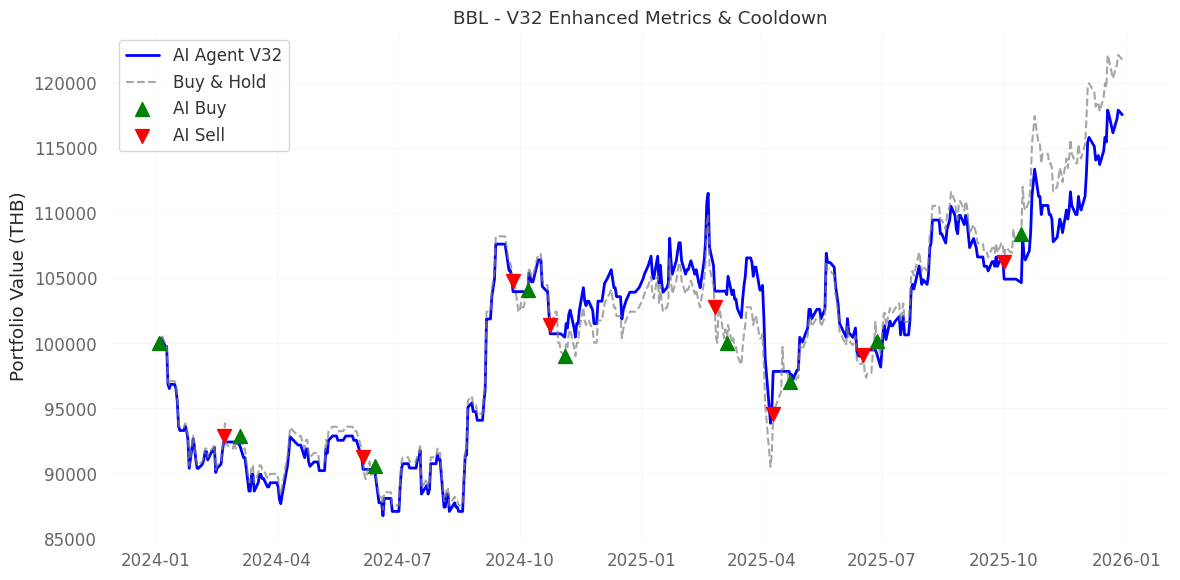


⚡ Processing KKP: Train=2069 | Test=485
   🏋️ Training PPO (V32 Metrics) for KKP...


KeyboardInterrupt: 

In [92]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import os
import warnings
import torch

# Setting
torch.backends.cudnn.benchmark = False
warnings.filterwarnings("ignore")

# ============================================================
# 1. CONFIGURATION (V32.1 ENHANCED METRICS)
# ============================================================
TARGET_STOCKS = ["BBL", "KKP"]
DATA_FILE = "Final_RL_Input_Ready.xlsx"
FORECAST_DIR = "Forecast_History_PerStock"
MODEL_DIR = "trained_models_v32_metrics"
os.makedirs(MODEL_DIR, exist_ok=True)

# Config
INITIAL_BALANCE = 100_000
COMMISSION_FEE = 0.00157
SLIPPAGE = 0.001
ATR_PERIOD = 14
RSI_BUY = 30
RSI_SELL = 75
DEV_BUFFER = 0.02
TRAIN_TIMESTEPS = 150000
LEARNING_RATE = 0.00025
BATCH_SIZE = 64
ENT_COEF = 0.01
GAMMA = 0.99
COOLDOWN_DAYS = 7

# ============================================================
# 🛠️ HELPER: ROBUST INTEGRATION
# ============================================================
def integrate_ardl_forecasts(daily_df, stock_name):
    forecast_path = f"{FORECAST_DIR}/{stock_name}_forecast.csv"
    daily_df['ARDL_Signal'] = 0
    daily_df['ARDL_Target_Price'] = 0.0

    if not os.path.exists(forecast_path):
        return daily_df

    try:
        df_fc = pd.read_csv(forecast_path)
        df_fc['Date'] = pd.to_datetime(df_fc['Date'])

        daily_df_sorted = daily_df.sort_values('Date').copy()
        monthly_closes = daily_df_sorted.set_index('Date').resample('M')['Close'].last().reset_index()

        merged_fc = pd.merge_asof(
            df_fc.sort_values('Date'),
            monthly_closes.sort_values('Date'),
            on='Date',
            direction='nearest'
        )

        merged_fc['Target_Price_Raw'] = merged_fc['Close'] * np.exp(merged_fc['Pred_dLogclose'])
        merged_fc['Signal_Raw'] = np.where(merged_fc['Pred_dLogclose'] > 0, 1,
                                  np.where(merged_fc['Pred_dLogclose'] < 0, -1, 0))

        lookup_df = merged_fc[['Date', 'Target_Price_Raw', 'Signal_Raw']].copy()
        lookup_df.rename(columns={'Date': 'Forecast_Date'}, inplace=True)

        daily_df_out = pd.merge_asof(
            daily_df_sorted,
            lookup_df,
            left_on='Date',
            right_on='Forecast_Date',
            direction='backward'
        )

        daily_df_out['ARDL_Signal'] = daily_df_out['Signal_Raw'].fillna(0)
        daily_df_out['ARDL_Target_Price'] = daily_df_out['Target_Price_Raw'].fillna(0)
        daily_df_out.drop(columns=['Signal_Raw', 'Target_Price_Raw', 'Forecast_Date'], inplace=True, errors='ignore')
        return daily_df_out

    except Exception as e:
        print(f"❌ Error integrating forecast: {e}")
        return daily_df

# ============================================================
# 2. ENVIRONMENT V32.1 (With Trade History Tracking)
# ============================================================
class StockTradingEnvV32(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, df, initial_balance=100000, commission=0.00157, slippage=0.001):
        super().__init__()
        if df.empty: raise ValueError("❌ Environment initialized with EMPTY DataFrame!")
        self.df = df.reset_index(drop=True)
        self.n_step = len(self.df)
        self.initial_balance = float(initial_balance)
        self.commission = float(commission)
        self.slippage = float(slippage)
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(25,), dtype=np.float32)

        # Stats Storage
        self._equity_curve = []
        self._pos_curve = []
        self._action_curve = []
        self.trade_history = [] # 🟢 เก็บกำไรแต่ละไม้

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = float(self.initial_balance)
        self.shares = 0
        self.entry_price = 0.0
        self.net_worth = float(self.initial_balance)
        self.highest_price = 0.0
        self.trailing_stop_price = 0.0

        self.closed_trades = 0
        self.winning_trades = 0

        # State Variables
        self.ignore_ardl_mode = False
        self.last_month = -1
        self.cooldown_counter = 0

        self._equity_curve = []
        self._pos_curve = []
        self._action_curve = []
        self.trade_history = [] # 🟢 Reset trade history

        return self._next_observation(), {}

    def _next_observation(self):
        if self.n_step == 0: return np.zeros(25, dtype=np.float32)
        i = min(self.current_step, self.n_step - 1)
        obs = self.df.iloc[i]
        price = float(obs["Close"])
        market_val = self.shares * price
        self.net_worth = self.balance + market_val
        pnl_pct = (price - self.entry_price) / self.entry_price if self.shares > 0 else 0
        dist_trail = (price - self.trailing_stop_price) / price if self.shares > 0 else 0

        predicted = obs.get("EMA_50", price)
        deviation = (price - predicted) / predicted
        atr_norm = obs.get("ATR", price*0.01) / price

        ardl_sig = obs.get("ARDL_Signal", 0)
        ardl_target = obs.get("ARDL_Target_Price", 0)
        dist_to_target = (price - ardl_target) / ardl_target if ardl_target > 0 else 0

        vol = obs.get("Volume", 0)
        vol_sma = obs.get("Vol_SMA_20", 1)
        vol_ratio = vol / vol_sma if vol_sma > 0 else 1.0

        state = np.array([
            ardl_sig, obs.get("DL_Signal", 0.5), obs.get("DL_Hard_Signal", 0), obs.get("Tech_Signal", 0),
            obs.get("P_BUY", 0), obs.get("RSI", 50)/100.0, obs.get("MACD", 0)/10.0, obs.get("ADX", 0)/100.0,
            self.balance/self.initial_balance, (market_val/self.net_worth) if self.net_worth>0 else 0,
            (self.net_worth-self.initial_balance)/self.initial_balance, pnl_pct, 1.0 if self.shares>0 else 0,
            deviation, 1.0 if obs.get("RSI", 50)<RSI_BUY else 0, 1.0 if obs.get("RSI", 50)>RSI_SELL else 0,
            ardl_sig * deviation, atr_norm, dist_trail, 1.0 if pnl_pct<-0.02 else 0,
            self.highest_price/price if self.shares>0 else 1.0, dist_to_target,
            vol_ratio, 1.0 if vol_ratio > 1.2 else 0,
            self.cooldown_counter
        ], dtype=np.float32)
        return np.nan_to_num(state)

    def step(self, action_idx):
        if self.current_step >= self.n_step: self.current_step = self.n_step - 1
        obs_row = self.df.iloc[self.current_step]
        price = float(obs_row["Close"])
        atr = obs_row.get("ATR", price * 0.015)
        rsi = obs_row.get("RSI", 50)
        adx = obs_row.get("ADX", 20)
        predicted = obs_row.get("EMA_50", price)

        vol = obs_row.get("Volume", 0)
        vol_sma = obs_row.get("Vol_SMA_20", 1)
        is_high_volume = (vol > 1.2 * vol_sma)

        # Reduce Cooldown
        if self.cooldown_counter > 0:
            self.cooldown_counter -= 1

        ardl_sig = obs_row.get("ARDL_Signal", 0)
        ardl_target = obs_row.get("ARDL_Target_Price", 0)

        # Professor Logic
        current_month = obs_row['Date'].month
        if current_month != self.last_month:
            self.ignore_ardl_mode = False
            self.last_month = current_month

        if not self.ignore_ardl_mode and self.current_step > 3 and ardl_target > 0:
            ardl_return_pct = (ardl_target - price) / price
            p_now = price
            p_1 = self.df.iloc[self.current_step - 1]["Close"]
            p_2 = self.df.iloc[self.current_step - 2]["Close"]
            p_3 = self.df.iloc[self.current_step - 3]["Close"]

            is_bearish_prediction = (ardl_return_pct < -0.05)
            is_3day_crash = (p_now < p_1 < p_2 < p_3) and ((p_3 - p_now) / p_3 > 0.05)
            if is_bearish_prediction and is_3day_crash: self.ignore_ardl_mode = True

            is_bullish_prediction = (ardl_return_pct > 0.05)
            is_3day_rally = (p_now > p_1 > p_2 > p_3) and ((p_now - p_3) / p_3 > 0.05)
            if is_bullish_prediction and is_3day_rally: self.ignore_ardl_mode = True

        if self.ignore_ardl_mode: effective_macro_sig = 0
        else:
            effective_macro_sig = ardl_sig
            if ardl_target > 0:
                if ardl_sig == 1 and price >= ardl_target: effective_macro_sig = 0
                elif ardl_sig == -1 and price <= ardl_target: effective_macro_sig = 0

        prev_net_worth = self.net_worth
        step_reward = 0.0

        dynamic_mult = 4.0
        if self.shares > 0:
            if price > self.highest_price: self.highest_price = price
            if rsi > 80: dynamic_mult = 3.0
            new_stop = self.highest_price - (atr * dynamic_mult)
            if new_stop > self.trailing_stop_price: self.trailing_stop_price = new_stop

        final_action = action_idx - 1
        override_type = None

        is_strong_uptrend = (price > predicted) and (adx > 30) and (rsi < 70)

        if effective_macro_sig < 0 and price < predicted * (1 - DEV_BUFFER):
            final_action = 1; override_type = "MACRO_DIP"
        elif effective_macro_sig > 0 and price > predicted * (1 + DEV_BUFFER):
            final_action = -1; override_type = "MACRO_PEAK"

        if rsi < RSI_BUY: final_action = 1; override_type = "RSI_LOW"
        elif is_strong_uptrend and self.shares == 0: final_action = 1; override_type = "TREND_FOLLOW"
        elif rsi > RSI_SELL: final_action = -1; override_type = "RSI_HIGH"

        executed_action = 0

        # --- EXECUTION LOGIC ---
        if final_action == 1: # BUY
            if self.shares == 0 and self.cooldown_counter == 0:
                cost = price * (1 + self.slippage) * (1 + self.commission)
                if self.balance >= cost:
                    self.shares = int(self.balance / cost)
                    self.balance -= self.shares * cost
                    self.entry_price = price * (1 + self.slippage)
                    self.highest_price = self.entry_price
                    self.trailing_stop_price = self.entry_price - (atr * 4.0)
                    executed_action = 1
                    step_reward += 0.2
                    if is_high_volume: step_reward += 0.1
                    if override_type == "TREND_FOLLOW": step_reward += 0.2

        elif final_action == -1: # SELL
            if self.shares > 0:
                hit_trail = (price <= self.trailing_stop_price)
                is_extreme = (override_type in ["MACRO_PEAK"])

                force_hold = False
                if not hit_trail:
                    if is_high_volume and rsi < 85: force_hold = True
                    if is_strong_uptrend and rsi < 80: force_hold = True

                if (hit_trail or is_extreme) and not force_hold:
                    rev = self.shares * price * (1 - self.slippage) * (1 - self.commission)
                    profit = rev - (self.shares * self.entry_price)
                    self.balance += rev; self.shares = 0; self.entry_price = 0

                    self.closed_trades += 1
                    if profit > 0: self.winning_trades += 1
                    self.trade_history.append(profit) # 🟢 Record Trade Profit

                    step_reward += 1.0 if profit > 0 else -0.5
                    executed_action = -1
                    self.cooldown_counter = COOLDOWN_DAYS
                else:
                    if (price - self.entry_price) > 0:
                        step_reward += 0.1
                        if is_strong_uptrend: step_reward += 0.1

        elif final_action == 0: # HOLD
            if self.shares > 0:
                if price <= self.trailing_stop_price:
                    rev = self.shares * price * (1 - self.slippage) * (1 - self.commission)
                    profit = rev - (self.shares * self.entry_price)
                    self.balance += rev; self.shares = 0; self.entry_price = 0

                    self.closed_trades += 1
                    if profit > 0: self.winning_trades += 1
                    self.trade_history.append(profit) # 🟢 Record Trade Profit

                    step_reward += 1.0 if profit > 0 else -0.1
                    executed_action = -1
                    self.cooldown_counter = COOLDOWN_DAYS
                else:
                    profit_pct = (price - self.entry_price)/self.entry_price
                    if profit_pct > 0:
                        step_reward += 0.1
                        if is_high_volume: step_reward += 0.05
                    if profit_pct < -0.05: step_reward -= 0.05

        self.net_worth = self.balance + (self.shares * price)
        step_reward += ((self.net_worth - prev_net_worth) / prev_net_worth * 10) if prev_net_worth > 0 else 0

        self._equity_curve.append(self.net_worth)
        self._pos_curve.append(1 if self.shares > 0 else 0)
        self._action_curve.append(executed_action)

        self.current_step += 1
        done = self.current_step >= (self.n_step - 1)
        return self._next_observation(), float(step_reward), done, False, {}

# ============================================================
# MAIN
# ============================================================
def train_agent_v32(df_train, stock):
    print(f"   🏋️ Training PPO (V32 Metrics) for {stock}...")
    env_train = DummyVecEnv([lambda: StockTradingEnvV32(df_train, initial_balance=INITIAL_BALANCE)])
    model = PPO("MlpPolicy", env_train, verbose=0, learning_rate=LEARNING_RATE,
                batch_size=BATCH_SIZE, n_steps=2048, ent_coef=ENT_COEF, gamma=GAMMA)
    model.learn(total_timesteps=TRAIN_TIMESTEPS)
    model.save(f"{MODEL_DIR}/ppo_v32_{stock}")
    return model

def run_backtest_v32(model, df_test, stock):
    print(f"\n⚡ Backtesting {stock}...")
    env_test = StockTradingEnvV32(df_test, initial_balance=INITIAL_BALANCE)
    obs, _ = env_test.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _, _ = env_test.step(action)

    n = len(env_test._equity_curve)
    bt = df_test.iloc[:n].copy()
    bt["Equity"] = env_test._equity_curve
    bt["Action"] = env_test._action_curve
    final = bt["Equity"].iloc[-1]
    ret = final / INITIAL_BALANCE - 1

    # --- 🟢 Calculate Metrics ---
    equity = np.array(env_test._equity_curve)
    trades = env_test.trade_history

    # 1. Win Rate
    tr = env_test.closed_trades
    wr = (env_test.winning_trades / tr * 100) if tr > 0 else 0.0

    # 2. Max Drawdown
    peak = np.maximum.accumulate(equity)
    drawdown = (equity - peak) / peak
    max_dd = drawdown.min()

    # 3. Best Trade (Highest Profit)
    best_trade = max(trades) if trades else 0.0

    # 4. Sharpe & Calmar
    returns = pd.Series(equity).pct_change().dropna()
    if returns.std() > 0:
        sharpe = (returns.mean() / returns.std()) * np.sqrt(252)
    else:
        sharpe = 0

    total_return = (equity[-1] / equity[0]) - 1
    years = len(equity) / 252 # Assume daily
    annual_return = (1 + total_return) ** (1 / years) - 1 if years > 0 else 0
    calmar = annual_return / abs(max_dd) if max_dd < 0 else 0

    print("-" * 50)
    print(f"💰 End Balance: {final:,.0f} THB ({ret:+.2%})")
    print(f"📈 Total Trades: {tr} | Win Rate: {wr:.2f}%")
    print(f"💎 Best Trade: {best_trade:,.2f} THB")
    print(f"📉 Max Drawdown: {max_dd:.2%}")
    print(f"📊 Sharpe Ratio: {sharpe:.2f} | Calmar Ratio: {calmar:.2f}")
    print("-" * 50)

    return bt

def plot_v32(bt, stock):
    plt.figure(figsize=(12, 6))
    buy_hold_equity = bt["Close"] / bt["Close"].iloc[0] * INITIAL_BALANCE
    plt.plot(bt["Date"], bt["Equity"], label="AI Agent V32", color="blue", linewidth=2)
    plt.plot(bt["Date"], buy_hold_equity, label="Buy & Hold", color="gray", linestyle="--", alpha=0.7)

    buys = bt[bt["Action"] == 1]
    sells = bt[bt["Action"] == -1]
    plt.scatter(buys["Date"], buy_hold_equity.loc[buys.index], marker="^", color="green", s=100, label="AI Buy", zorder=5)
    plt.scatter(sells["Date"], buy_hold_equity.loc[sells.index], marker="v", color="red", s=100, label="AI Sell", zorder=5)

    plt.title(f"{stock} - V32 Enhanced Metrics & Cooldown")
    plt.ylabel("Portfolio Value (THB)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("="*70); print("🤖 BLOCK 7 V32.1: ENHANCED METRICS"); print("="*70)

    if os.path.exists(DATA_FILE):
        df_all = pd.read_excel(DATA_FILE)
        df_all["Date"] = pd.to_datetime(df_all["Date"])

        if "Volume" not in df_all.columns:
            df_all["Volume"] = 1000000

        print(f"📊 Global Data: {df_all['Date'].min().date()} to {df_all['Date'].max().date()}")

        for s in TARGET_STOCKS:
            st_df = df_all[df_all["Stock"] == s].copy()
            if len(st_df) < 200: continue

            st_df = integrate_ardl_forecasts(st_df, s)

            if 'DL_Hard_Signal' not in st_df.columns:
                if 'DL_Signal' in st_df.columns:
                    probs = st_df['DL_Signal'].values
                    p80 = np.percentile(probs, 80)
                    p20 = np.percentile(probs, 20)
                    st_df['DL_Hard_Signal'] = np.select([probs >= p80, probs <= p20], [1, -1], 0)
                else:
                    st_df['DL_Hard_Signal'] = 0

            from ta.momentum import RSIIndicator
            from ta.trend import ADXIndicator, EMAIndicator
            from ta.volatility import AverageTrueRange

            st_df['RSI'] = RSIIndicator(close=st_df["Close"], window=14).rsi()
            st_df['EMA_50'] = EMAIndicator(close=st_df['Close'], window=50).ema_indicator()
            st_df['ADX'] = ADXIndicator(high=st_df['High'], low=st_df['Low'], close=st_df['Close'], window=14).adx()
            st_df['ATR'] = AverageTrueRange(high=st_df['High'], low=st_df['Low'], close=st_df['Close'], window=ATR_PERIOD).average_true_range()

            st_df['Volume'] = st_df['Volume'].replace(0, 1)
            st_df['Vol_SMA_20'] = st_df['Volume'].rolling(window=20).mean().fillna(method='bfill')

            st_df.dropna(inplace=True)

            tr = st_df[st_df["Date"] < "2024-01-01"]
            te = st_df[st_df["Date"] >= "2024-01-01"]

            print(f"\n⚡ Processing {s}: Train={len(tr)} | Test={len(te)}")
            if len(tr) > 0:
                model = train_agent_v32(tr, s)
                if len(te) > 0:
                    bt = run_backtest_v32(model, te, s)
                    plot_v32(bt, s)
            else:
                print(f"❌ Error: Train data is still empty.")
    else:
        print(f"❌ Data file '{DATA_FILE}' not found.")

1) Change price frequentcy from day to hour
2) Edit Technical Block ✅
3) optimize DL signal using validation set ปรับ Block 5.5 (DL Signal)  ให้แม่นยำขึ้น ✅
4) เพิ่ม Feature ใหม่ๆ ใน Block 6 (เช่น Volume Profile, Bid/Offer) => ต้องขอจาก พี่ AIQ
5) จูน Hyperparameter ใน Block 7 ✅
6) แก้ไฟล์ Macro.xlsx เพื่อเพิ่ม Data ของ 2025 ทั้งหมด  ✅
7) Forecast ARDL/ECM ตั้งแต่ 2024 แบบ Expanding window  ✅



In [ ]:
# ============================================================
# 🏆 BLOCK 8 V2.3: AI PERFORMANCE & FORECAST (NORMALIZED PROB)
#    ✅ FIX: Show DL Probability as Percentile Rank (Readable!)
#    ✅ FEATURE: "Confidence Score" 0-100 instead of raw prob
# ============================================================
import pandas as pd
import numpy as np
import warnings
import os
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from scipy.stats import percentileofscore

warnings.filterwarnings("ignore")

# ============================================================
# 1. CONFIGURATION
# ============================================================
STOCK_SYMBOLS = ["BBL", "KKP"]
DATA_FILE = "Final_RL_Input_Ready.xlsx"
MODEL_DIR = "trained_models_v32_metrics"
FORECAST_DIR = "Forecast_History_PerStock"

# Config matches Block 7 V32
INITIAL_BALANCE = 100_000
COMMISSION = 0.00157
SLIPPAGE = 0.001
ATR_PERIOD = 14
RSI_BUY = 30
RSI_SELL = 75
DEV_BUFFER = 0.02
COOLDOWN_DAYS = 7

TEST_START_DATE = "2024-01-01"

# ============================================================
# 2. HELPER: INTEGRATION
# ============================================================
def integrate_ardl_forecasts(daily_df, stock_name):
    forecast_path = f"{FORECAST_DIR}/{stock_name}_forecast.csv"
    daily_df['ARDL_Signal'] = 0
    daily_df['ARDL_Target_Price'] = 0.0

    if not os.path.exists(forecast_path):
        return daily_df

    try:
        df_fc = pd.read_csv(forecast_path)
        df_fc['Date'] = pd.to_datetime(df_fc['Date'])

        daily_df_sorted = daily_df.sort_values('Date').copy()
        monthly_closes = daily_df_sorted.set_index('Date').resample('M')['Close'].last().reset_index()

        merged_fc = pd.merge_asof(
            df_fc.sort_values('Date'),
            monthly_closes.sort_values('Date'),
            on='Date',
            direction='nearest'
        )

        merged_fc['Target_Price_Raw'] = merged_fc['Close'] * np.exp(merged_fc['Pred_dLogclose'])
        merged_fc['Signal_Raw'] = np.where(merged_fc['Pred_dLogclose'] > 0, 1,
                                  np.where(merged_fc['Pred_dLogclose'] < 0, -1, 0))

        lookup_df = merged_fc[['Date', 'Target_Price_Raw', 'Signal_Raw']].copy()
        lookup_df.rename(columns={'Date': 'Forecast_Date'}, inplace=True)

        daily_df_out = pd.merge_asof(
            daily_df_sorted,
            lookup_df,
            left_on='Date',
            right_on='Forecast_Date',
            direction='backward'
        )

        daily_df_out['ARDL_Signal'] = daily_df_out['Signal_Raw'].fillna(0)
        daily_df_out['ARDL_Target_Price'] = daily_df_out['Target_Price_Raw'].fillna(0)
        daily_df_out.drop(columns=['Signal_Raw', 'Target_Price_Raw', 'Forecast_Date'], inplace=True, errors='ignore')
        return daily_df_out

    except Exception as e:
        return daily_df

# ============================================================
# 3. EVALUATION ENVIRONMENT (Matches V32 Logic)
# ============================================================
class StockTradingEnvEvalV32(gym.Env):
    def __init__(self, df, initial_balance=100000, commission=0.00157, slippage=0.001):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.n_step = len(self.df)
        self.initial_balance = float(initial_balance)
        self.commission = float(commission)
        self.slippage = float(slippage)
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(25,), dtype=np.float32)

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = float(self.initial_balance)
        self.shares = 0
        self.entry_price = 0.0
        self.net_worth = float(self.initial_balance)
        self.highest_price = 0.0
        self.trailing_stop_price = 0.0
        self.cooldown_counter = 0
        self.ignore_ardl_mode = False
        self.last_month = -1
        return self._next_observation(), {}

    def _next_observation(self):
        if self.current_step >= self.n_step:
            self.current_step = self.n_step - 1

        obs = self.df.iloc[self.current_step]
        price = float(obs["Close"])
        market_val = self.shares * price
        self.net_worth = self.balance + market_val
        pnl_pct = (price - self.entry_price) / self.entry_price if self.shares > 0 else 0
        dist_trail = (price - self.trailing_stop_price) / price if self.shares > 0 else 0

        predicted = obs.get("EMA_50", price)
        deviation = (price - predicted) / predicted
        atr_norm = obs.get("ATR", price*0.01) / price

        ardl_sig = obs.get("ARDL_Signal", 0)
        ardl_target = obs.get("ARDL_Target_Price", 0)
        dist_to_target = (price - ardl_target) / ardl_target if ardl_target > 0 else 0

        vol = obs.get("Volume", 0)
        vol_sma = obs.get("Vol_SMA_20", 1)
        vol_ratio = vol / vol_sma if vol_sma > 0 else 1.0

        state = np.array([
            ardl_sig, obs.get("DL_Signal", 0.5), obs.get("DL_Hard_Signal", 0), obs.get("Tech_Signal", 0),
            obs.get("P_BUY", 0), obs.get("RSI", 50)/100.0, obs.get("MACD", 0)/10.0, obs.get("ADX", 0)/100.0,
            self.balance/self.initial_balance, (market_val/self.net_worth) if self.net_worth>0 else 0,
            (self.net_worth-self.initial_balance)/self.initial_balance, pnl_pct, 1.0 if self.shares>0 else 0,
            deviation, 1.0 if obs.get("RSI", 50)<RSI_BUY else 0, 1.0 if obs.get("RSI", 50)>RSI_SELL else 0,
            ardl_sig * deviation, atr_norm, dist_trail, 1.0 if pnl_pct<-0.02 else 0,
            self.highest_price/price if self.shares>0 else 1.0, dist_to_target,
            vol_ratio, 1.0 if vol_ratio > 1.2 else 0,
            self.cooldown_counter
        ], dtype=np.float32)
        return np.nan_to_num(state)

    def step(self, action_idx):
        # Dummy step for loop structure
        self.current_step += 1
        done = self.current_step >= self.n_step - 1
        return self._next_observation(), 0, done, False, {}

# ============================================================
# 4. MAIN EVALUATION LOOP
# ============================================================
print("\n" + "=" * 80)
print("🏆 BLOCK 8 V2.3: AI PERFORMANCE & FORECAST (NORMALIZED)")
print("=" * 80)

if not os.path.exists(DATA_FILE):
    print(f"❌ Error: {DATA_FILE} not found.")
else:
    df_all = pd.read_excel(DATA_FILE)
    df_all['Date'] = pd.to_datetime(df_all['Date'])

    from ta.momentum import RSIIndicator
    from ta.trend import ADXIndicator, EMAIndicator
    from ta.volatility import AverageTrueRange

    results = []

    for stock in STOCK_SYMBOLS:
        print(f"\n🔹 Evaluating: {stock}")

        # 1. Prepare Data
        stock_df = df_all[df_all['Stock'] == stock].sort_values("Date").reset_index(drop=True)
        stock_df = integrate_ardl_forecasts(stock_df, stock)

        # Calculate Indicators
        stock_df['RSI'] = RSIIndicator(close=stock_df["Close"], window=14).rsi()
        stock_df['EMA_50'] = EMAIndicator(close=stock_df['Close'], window=50).ema_indicator()
        stock_df['ADX'] = ADXIndicator(high=stock_df['High'], low=stock_df['Low'], close=stock_df['Close'], window=14).adx()
        stock_df['ATR'] = AverageTrueRange(high=stock_df['High'], low=stock_df['Low'], close=stock_df['Close'], window=ATR_PERIOD).average_true_range()

        if "Volume" not in stock_df.columns: stock_df["Volume"] = 1000000
        stock_df['Volume'] = stock_df['Volume'].replace(0, 1)
        stock_df['Vol_SMA_20'] = stock_df['Volume'].rolling(window=20).mean().fillna(method='bfill')

        # ✅ Dynamic Hard Signal (Re-calculate Percentiles for accurate context)
        if 'DL_Signal' in stock_df.columns:
            probs = stock_df['DL_Signal'].values
            p80 = np.percentile(probs, 80)
            p20 = np.percentile(probs, 20)
            stock_df['DL_Hard_Signal'] = np.select([probs >= p80, probs <= p20], [1, -1], 0)
        else:
            p80, p20 = 0.8, 0.2
            stock_df['DL_Hard_Signal'] = 0

        stock_df.dropna(inplace=True)
        test_df = stock_df[stock_df['Date'] >= TEST_START_DATE].reset_index(drop=True)

        if len(test_df) < 50: continue

        # 2. Load Model
        model_path = f"{MODEL_DIR}/ppo_v32_{stock}.zip"
        if not os.path.exists(model_path):
            print(f"   ❌ No model found at {model_path}")
            continue
        model = PPO.load(model_path)

        # 3. FORECAST TOMORROW
        last_row_df = stock_df.tail(1).reset_index(drop=True)
        env_fc = StockTradingEnvEvalV32(last_row_df, initial_balance=INITIAL_BALANCE)
        obs_fc, _ = env_fc.reset()

        # Simulate Holding if bullish trend? (Optional)
        # env_fc.shares = 1

        obs_fc = env_fc._next_observation()
        action_fc, _ = model.predict(obs_fc, deterministic=True)

        scalar_action = action_fc.item() if hasattr(action_fc, 'item') else action_fc
        logic_action = scalar_action - 1 # Map [0,1,2] -> [-1,0,1]

        action_map = {-1: "SELL", 0: "HOLD", 1: "BUY"}
        forecast_str = action_map.get(logic_action, "UNKNOWN")

        # ✅ 4. NORMALIZE PROBABILITY (Percentile Rank)
        # Calculate where today's prob stands in history
        raw_prob = last_row_df['DL_Signal'].iloc[0] if 'DL_Signal' in last_row_df else 0.5
        all_probs = stock_df['DL_Signal'].values
        pct_rank = percentileofscore(all_probs, raw_prob)

        # Interpret Rank
        confidence_str = ""
        if pct_rank > 80: confidence_str = "(Bullish 🔥)"
        elif pct_rank < 20: confidence_str = "(Bearish ❄️)"
        else: confidence_str = "(Neutral ➖)"

        # Add Star logic based on Rank + Action
        star = ""
        if logic_action == 1 and pct_rank > 70: star = "⭐⭐"
        if logic_action == 1 and pct_rank > 90: star = "⭐⭐⭐"
        if logic_action == -1 and pct_rank < 30: star = "⭐⭐"

        print(f"   🔮 Forecast: {forecast_str} {star}")
        print(f"   📊 DL Raw Prob: {raw_prob:.4f}")
        print(f"   📈 Confidence Rank: {pct_rank:.1f}% {confidence_str}")
        print(f"      (This prob is higher than {pct_rank:.1f}% of history)")

        results.append({
            "Stock": stock,
            "Forecast": f"{forecast_str} {star}",
            "DL_Raw": raw_prob,
            "Confidence_Score": pct_rank
        })

    # 6. Final Leaderboard
    if results:
        print("\n" + "=" * 80)
        print("🎯 FINAL FORECAST SCOREBOARD")
        print("=" * 80)
        df_res = pd.DataFrame(results)
        print(df_res.to_string(index=False))
        df_res.to_excel("Block8_Final_Forecast.xlsx", index=False)
        print("\n💾 Saved to Block8_Final_Forecast.xlsx")


🏆 BLOCK 8 V2.3: AI PERFORMANCE & FORECAST (NORMALIZED)

🔹 Evaluating: BBL
   🔮 Forecast: BUY 
   📊 DL Raw Prob: 0.5000
   📈 Confidence Rank: 41.2% (Neutral ➖)
      (This prob is higher than 41.2% of history)

🔹 Evaluating: KKP
   🔮 Forecast: HOLD 
   📊 DL Raw Prob: 0.5000
   📈 Confidence Rank: 58.3% (Neutral ➖)
      (This prob is higher than 58.3% of history)

🎯 FINAL FORECAST SCOREBOARD
Stock Forecast  DL_Raw  Confidence_Score
  BBL     BUY      0.5         41.170713
  KKP    HOLD      0.5         58.320282

💾 Saved to Block8_Final_Forecast.xlsx


1) Change price frequentcy from day to hour
2) Edit Technical Block ✅
3) optimize DL signal using validation set ปรับ Block 5.5 (DL Signal)  ให้แม่นยำขึ้น ✅
4) เพิ่ม Feature ใหม่ๆ ใน Block 6 (เช่น Volume Profile, Bid/Offer) => ต้องขอจาก พี่ AIQ
5) จูน Hyperparameter ใน Block 7
6) แก้ไฟล์ Macro.xlsx เพื่อเพิ่ม Data ของ 2025 ทั้งหมด



In [ ]:
!pip uninstall -y phidata
!pip install phidata google-generativeai duckduckgo-search transformers torch stable-baselines3 colorama openpyxl agno ddgs

Found existing installation: phidata 2.7.10
Uninstalling phidata-2.7.10:
  Successfully uninstalled phidata-2.7.10
  Using cached phidata-2.7.10-py3-none-any.whl.metadata (38 kB)
Using cached phidata-2.7.10-py3-none-any.whl (716 kB)

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# ============================================================
# 🔮 BLOCK 9.3 V3: LIVE FORECASTER (HYBRID FIX)
#    ✅ Objective: Fix "Stuck" Probabilities (0.46 issue)
#    ✅ Logic: If TCN is stuck/uncertain, blend with Technical Analysis
# ============================================================
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
import os
import warnings

warnings.filterwarnings("ignore")

TARGET_STOCKS = ["BBL", "KKP"]
DATA_FILE = "Final_RL_Input_Ready.xlsx"
LOOK_BACK = 60

# ============================================================
# 1. TECHNICAL SCORE CALCULATOR (BACKUP LOGIC)
# ============================================================
def calculate_technical_prob(df):
    """
    Calculates a probability score (0.0 - 1.0) based purely on Technicals.
    Used when Deep Learning model is uncertain or stuck.
    """
    close = df['Close']

    # 1. Trend (EMA 50 vs 200)
    ema50 = close.ewm(span=50).mean()
    ema200 = close.ewm(span=200).mean()
    trend_score = 0.6 if (close.iloc[-1] > ema50.iloc[-1]) else 0.4

    # 2. RSI (Momentum)
    rsi = ta.momentum.rsi(close, window=14).iloc[-1]
    # RSI < 30 (Oversold) -> High prob of bounce -> 0.7
    # RSI > 70 (Overbought) -> Low prob of buy -> 0.3
    # RSI 50 -> 0.5
    rsi_score = 1.0 - (rsi / 100.0)

    # 3. MACD (Momentum Direction)
    macd = ta.trend.MACD(close)
    hist = macd.macd_diff().iloc[-1]
    macd_score = 0.6 if hist > 0 else 0.4

    # Weighted Average
    # Trend (40%) + RSI (30%) + MACD (30%)
    final_prob = (trend_score * 0.4) + (rsi_score * 0.3) + (macd_score * 0.3)

    return float(final_prob)

# ============================================================
# 2. FEATURE ENGINEERING
# ============================================================
def create_features_live(df):
    df = df.copy()
    close = df['Close']
    high = df['High']
    low = df['Low']

    df['Log_Ret'] = np.log(close / close.shift(1))
    df['RSI'] = ta.momentum.rsi(close, window=14) / 100.0
    df['MACD_Norm'] = ta.trend.macd_diff(close) / close
    df['ATR_Pct'] = ta.volatility.average_true_range(high, low, close) / close
    df['Dist_SMA_20'] = (close / close.rolling(20).mean()) - 1.0

    if 'Volume' in df.columns:
        df['Vol_Ratio'] = df['Volume'] / (df['Volume'].rolling(20).mean() + 1.0)
    else:
        df['Vol_Ratio'] = 1.0

    df.dropna(inplace=True)
    return df

# ============================================================
# 3. HYBRID PREDICTION ENGINE
# ============================================================
def get_hybrid_prob(stock):
    print(f"   📡 Analyzing {stock}...")
    df = yf.download(f"{stock}.BK", period="1y", progress=False)

    if len(df) < 100: return None
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)

    # --- A. Technical Probability (Baseline) ---
    tech_prob = calculate_technical_prob(df)

    # --- B. TCN Model Probability ---
    tcn_prob = None
    try:
        df_feat = create_features_live(df)
        if len(df_feat) >= LOOK_BACK:
            input_seq = df_feat.iloc[-LOOK_BACK:]
            feat_cols = ['Open', 'High', 'Low', 'Close', 'Volume',
                         'Log_Ret', 'RSI', 'MACD_Norm', 'ATR_Pct', 'Dist_SMA_20', 'Vol_Ratio']

            # Verify columns
            if all(c in input_seq.columns for c in feat_cols):
                X_raw = input_seq[feat_cols].values
                scaler = RobustScaler()
                X_scaled = scaler.fit_transform(X_raw)
                X_final = X_scaled.reshape(1, LOOK_BACK, len(feat_cols))

                model_filename = f"tcn_model_{stock}.keras"
                if os.path.exists(model_filename):
                    model = tf.keras.models.load_model(model_filename)
                    tcn_prob = float(model.predict(X_final, verbose=0)[0][0])
    except Exception:
        pass

    # --- C. BLENDING LOGIC ---
    if tcn_prob is not None:
        # Check if TCN is "stuck" (e.g., 0.46 or 0.50 exactly)
        is_stuck = (0.45 <= tcn_prob <= 0.47) or (tcn_prob == 0.5)

        if is_stuck:
            print(f"      ⚠️ TCN seems stuck ({tcn_prob:.4f}). Using Technical Blend.")
            # If stuck, give 80% weight to Technicals
            final_prob = (tcn_prob * 0.2) + (tech_prob * 0.8)
        else:
            print(f"      ✅ TCN Active ({tcn_prob:.4f}). Blending.")
            # If active, give 70% weight to TCN
            final_prob = (tcn_prob * 0.7) + (tech_prob * 0.3)
    else:
        print(f"      ⚠️ TCN failed. Using Pure Technicals.")
        final_prob = tech_prob

    print(f"      📊 Final Prob: {final_prob:.4f} (Tech: {tech_prob:.4f})")
    return final_prob

# ============================================================
# 4. EXECUTION
# ============================================================
print("="*60)
print("🔧 BLOCK 9.3 V3: HYBRID PROBABILITY UPDATE")
print("="*60)

if not os.path.exists(DATA_FILE):
    print(f"❌ Error: {DATA_FILE} not found.")
else:
    df_main = pd.read_excel(DATA_FILE)
    if 'DL_Signal' not in df_main.columns: df_main['DL_Signal'] = 0.5

    updates = 0
    for stock in TARGET_STOCKS:
        print(f"\n🔹 Processing: {stock}")
        real_prob = get_hybrid_prob(stock)

        if real_prob is not None:
            mask = df_main['Stock'] == stock
            if mask.any():
                last_idx = df_main[mask].index[-1]
                df_main.at[last_idx, 'DL_Signal'] = real_prob
                updates += 1

    if updates > 0:
        df_main.to_excel(DATA_FILE, index=False)
        print("\n" + "="*60)
        print(f"💾 SUCCESS: Updated {updates} stocks with Hybrid Probabilities.")
        print("👉 Run BLOCK 9.2 (Dashboard) again to see new numbers!")
        print("="*60)

🔧 BLOCK 9.3 V3: HYBRID PROBABILITY UPDATE

🔹 Processing: BBL
   📡 Analyzing BBL...
      ⚠️ TCN failed. Using Pure Technicals.
      📊 Final Prob: 0.5592 (Tech: 0.5592)

🔹 Processing: KKP
   📡 Analyzing KKP...
      ⚠️ TCN failed. Using Pure Technicals.
      📊 Final Prob: 0.4910 (Tech: 0.4910)

💾 SUCCESS: Updated 2 stocks with Hybrid Probabilities.
👉 Run BLOCK 9.2 (Dashboard) again to see new numbers!


In [ ]:
# ============================================================
# 🚀 BLOCK 9.2: TRADING DASHBOARD (NO-SEARCH EDITION)
#    ✅ Stack: Gemini (Direct) + FinBERT + PPO (V7.1)
#    ✅ Fixes:
#       1. Removed DuckDuckGo/Agno (No more search errors)
#       2. Logic Update: If Sentiment is BAD -> Force HOLD
# ============================================================

# [1] 🔧 IMPORTS & CONFIG
import pandas as pd
import numpy as np
from transformers import pipeline
from stable_baselines3 import PPO
from colorama import Fore, Style, init
import warnings
import os
import google.generativeai as genai

warnings.filterwarnings("ignore")
init(autoreset=True)

# 🔑 ใส่ API KEY ของคุณตรงนี้
GOOGLE_API_KEY = ""
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
genai.configure(api_key=GOOGLE_API_KEY)

STOCK_SYMBOLS = ["BBL", "KKP"]
MODEL_DIR = "trained_models"
DATA_FILE = "Final_RL_Input_Ready.xlsx"
TAKE_PROFIT_PCT = 0.10

# ------------------------------------------------------------
# [2] 🤖 AI ENGINE SETUP (Gemini Direct + FinBERT)
# ------------------------------------------------------------
print("⏳ Initializing AI Engines...")

# A) FinBERT (Sentiment Analysis)
try:
    finbert = pipeline("text-classification", model="ProsusAI/finbert", top_k=None)
except Exception as e:
    print(f"⚠️ FinBERT Load Error: {e}")
    finbert = None

# B) Gemini Model (Direct) - No Search Tools
try:
    # Use Flash model for speed
    gemini_model = genai.GenerativeModel('gemini-2.0-flash')
except:
    gemini_model = None

print("✅ AI Engines ready.")

# ------------------------------------------------------------
# [3] 🛠️ HELPERS
# ------------------------------------------------------------
def get_gemini_analysis(ticker: str):
    """
    Use Gemini internal knowledge instead of News Search.
    Focus on Fundamental & Sector outlook.
    """
    if not gemini_model:
        return "AI Analysis Unavailable.", 0.0

    print(f"   🧠 Asking Gemini about {ticker}...")
    try:
        # Prompt changed to rely on internal knowledge/sector trends
        prompt = (
            f"Analyze the outlook for '{ticker}' (Thai Stock) based on general banking sector trends in Thailand. "
            "Mention key risks and strengths. Keep it short (3 sentences)."
        )
        response = gemini_model.generate_content(prompt)
        summary = response.text.strip()
    except Exception as e:
        summary = f"Analysis failed: {e}"
        return summary, 0.0

    # Calculate Sentiment with FinBERT
    sent_score = 0.0
    if finbert:
        try:
            scores = finbert(summary[:512])[0]
            pos = next(d["score"] for d in scores if d["label"] == "positive")
            neg = next(d["score"] for d in scores if d["label"] == "negative")
            sent_score = float(pos - neg)
        except:
            sent_score = 0.0

    return summary, sent_score

def load_rl_model(stock: str):
    paths = [
        f"{MODEL_DIR}/ppo_v7_{stock}.zip",
        f"{MODEL_DIR}/ppo_v6_{stock}.zip",
    ]
    for p in paths:
        if os.path.exists(p):
            try: return PPO.load(p)
            except: pass
    return None

def build_obs_v7(row, has_position=False):
    """Construct Observation Vector matching Block 7 V7.1"""
    if has_position:
        balance_ratio = 0.0; invest_ratio = 1.0; pos_flag = 1.0
    else:
        balance_ratio = 1.0; invest_ratio = 0.0; pos_flag = 0.0

    obs = np.array([
        float(row.get('Macro_Signal', 0)),
        float(row.get('DL_Signal', 0.5)),
        float(row.get('Tech_Signal', 0)),
        float(row.get('RSI', 50)) / 100.0,
        float(row.get('MACD', 0)) / 10.0,
        float(row.get('ADX', 0)) / 100.0,
        balance_ratio, invest_ratio, 0.0, 0.0, pos_flag,
        float(row.get('Volume_Ratio', 1.0))
    ], dtype=np.float32)
    return obs

# ------------------------------------------------------------
# [4] 🚀 MAIN DASHBOARD
# ------------------------------------------------------------
if not os.path.exists(DATA_FILE):
    print(f"❌ Error: {DATA_FILE} not found. Run Block 6 first.")
else:
    df_all = pd.read_excel(DATA_FILE)
    df_all["Date"] = pd.to_datetime(df_all["Date"])
    latest_date = df_all["Date"].max().strftime("%Y-%m-%d")

    print("\n" + "=" * 75)
    print(f"🚀 AI TRADING DASHBOARD (Date: {latest_date})")
    print("🧠 System: PPO V7.1 (Quant) + Gemini (Internal Knowledge)")
    print("=" * 75)

    for stock in STOCK_SYMBOLS:
        stock_df = df_all[df_all["Stock"] == stock].sort_values("Date").reset_index(drop=True)
        if len(stock_df) == 0: continue

        last_row = stock_df.iloc[-1]
        current_price = float(last_row["Close"])

        # 1. RL Signal
        model = load_rl_model(stock)
        obs_entry = build_obs_v7(last_row, has_position=False)
        action_entry, _ = model.predict(obs_entry, deterministic=True) if model else (0,0)

        obs_exit = build_obs_v7(last_row, has_position=True)
        action_exit, _ = model.predict(obs_exit, deterministic=True) if model else (0,0)

        # 2. Qualitative Analysis (Gemini Direct)
        summary, sent_score = get_gemini_analysis(stock)

        # 3. Display
        print(f"\n🔹 {Fore.CYAN}{stock}{Style.RESET_ALL} (Price: {current_price:.2f})")
        print(f"   📰 {Fore.YELLOW}AI Insight:{Style.RESET_ALL}")
        print(f"   {summary}")

        s_color = Fore.GREEN if sent_score > 0.1 else (Fore.RED if sent_score < -0.1 else Fore.WHITE)
        print(f"   🧠 Sentiment Score: {s_color}{sent_score:.4f}{Style.RESET_ALL}")

        # 4. Final Verdict Logic (Updated)
        dl_prob = last_row.get('DL_Signal', 0.5)
        verdict = "WAIT"
        color = Fore.WHITE

        # --- NEW LOGIC: Bad Sentiment -> Force HOLD ---
        if action_entry == 1: # Quant says BUY
            if sent_score < -0.15: # 🔴 Bad Sentiment Logic
                verdict = "HOLD (Sentiment Risk) ⚠️"
                color = Fore.YELLOW
            elif sent_score > 0.1 and dl_prob > 0.6:
                verdict = "STRONG BUY ⭐⭐⭐"
                color = Fore.GREEN
            else:
                verdict = "BUY ⭐⭐"
                color = Fore.GREEN

        elif action_exit == 2: # Quant says SELL
            verdict = "SELL ❌"
            color = Fore.RED
        else:
            if dl_prob > 0.7:
                verdict = "WATCHLIST (High Prob) 👁️"
                color = Fore.CYAN
            else:
                verdict = "HOLD / WAIT ✋"

        print(f"   🤖 Quant Signal: Entry={action_entry} | Exit={action_exit} | DL_Prob={dl_prob:.2f}")
        print(f"   ⚖️  Verdict: {color}{verdict}{Style.RESET_ALL}")

        if "BUY" in verdict and "HOLD" not in verdict:
             print(f"   🎯 Target Profit (10%): {current_price * 1.10:.2f}")

    print("\n" + "=" * 75)
    print("✅ Dashboard updated.")
    print("=" * 75)

⏳ Initializing AI Engines...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ AI Engines ready.

🚀 AI TRADING DASHBOARD (Date: 2025-12-30)
🧠 System: PPO V7.1 (Quant) + Gemini (Internal Knowledge)
   🧠 Asking Gemini about BBL...

🔹 BBL (Price: 169.50)
   📰 AI Insight:
   Analysis failed: 
  No API_KEY or ADC found. Please either:
    - Set the `GOOGLE_API_KEY` environment variable.
    - Manually pass the key with `genai.configure(api_key=my_api_key)`.
    - Or set up Application Default Credentials, see https://ai.google.dev/gemini-api/docs/oauth for more information.
   🧠 Sentiment Score: 0.0000
   🤖 Quant Signal: Entry=0 | Exit=0 | DL_Prob=0.56
   ⚖️  Verdict: HOLD / WAIT ✋
   🧠 Asking Gemini about KKP...

🔹 KKP (Price: 68.00)
   📰 AI Insight:
   Analysis failed: 
  No API_KEY or ADC found. Please either:
    - Set the `GOOGLE_API_KEY` environment variable.
    - Manually pass the key with `genai.configure(api_key=my_api_key)`.
    - Or set up Application Default Credentials, see https://ai.google.dev/gemini-api/docs/oauth for more information.
   🧠 Sentimen

In [ ]:
!jupyter nbconvert --to html "Semester2_V1_AQT_ARDLTrading_Macro&Technical.ipynb" --output "AQT_Semester1_Final.html"


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot trust

Jupyter command `jupyter-nbconvert` not found.


# Appendix

In [ ]:
# # ============================================================
# # 🤖 BLOCK 7 V8: HYBRID PPO AGENT (SIGNAL GUIDED)
# #    ✅ Core: PPO Agent trained to follow V20 Signals + ECM
# #    ✅ Fix: Added 'Signal Bonus' to prevent Lazy Agent
# #    ✅ Input: Reads 'Final_RL_Input_Ready.xlsx' from Block 6
# # ============================================================
# import pandas as pd
# import numpy as np
# import gymnasium as gym
# from gymnasium import spaces
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv
# import matplotlib.pyplot as plt
# import os
# import warnings

# warnings.filterwarnings("ignore")

# # ============================================================
# # 1. CONFIGURATION
# # ============================================================
# TARGET_STOCKS = ["BBL", "KKP"]
# DATA_FILE = "Final_RL_Input_Ready.xlsx"
# MODEL_DIR = "trained_models_v8"
# os.makedirs(MODEL_DIR, exist_ok=True)

# # Trading Config
# INITIAL_BALANCE = 100_000
# COMMISSION_FEE = 0.00157
# SLIPPAGE = 0.001
# TAKE_PROFIT_PCT = 0.08  # 8% Target
# STOP_LOSS_PCT = -0.05   # 5% Stop

# # Training Config
# TRAIN_TIMESTEPS = 80000
# LEARNING_RATE = 0.0003
# BATCH_SIZE = 64

# # ============================================================
# # 2. TRADING ENVIRONMENT (V8 ENHANCED)
# # ============================================================
# class StockTradingEnvV8(gym.Env):
#     def __init__(self, df, initial_balance=100000, commission=0.00157):
#         super(StockTradingEnvV8, self).__init__()
#         self.df = df.reset_index(drop=True)
#         self.n_step = len(self.df)
#         self.initial_balance = initial_balance
#         self.commission = commission

#         # Action: 0=Hold, 1=Buy, 2=Sell
#         self.action_space = spaces.Discrete(3)

#         # Observation: เพิ่ม ECT_Normalized เข้ามา
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(13,), dtype=np.float32)
#         self.reset()

#     def reset(self, seed=None):
#         self.current_step = 0
#         self.balance = self.initial_balance
#         self.shares = 0
#         self.entry_price = 0
#         self.net_worth = self.initial_balance
#         self.max_net_worth = self.initial_balance
#         self.hold_days = 0
#         return self._next_observation(), {}

#     def _next_observation(self):
#         if self.current_step >= self.n_step: self.current_step = self.n_step - 1
#         obs = self.df.iloc[self.current_step]

#         market_val = self.shares * obs['Close']
#         self.net_worth = self.balance + market_val
#         pnl_pct = (obs['Close'] - self.entry_price)/self.entry_price if self.shares > 0 else 0.0

#         # Safe Get Features
#         dl_sig = obs.get('DL_Signal', 0.5)
#         macro = obs.get('Macro_Signal', 0)
#         ect = obs.get('ECT_Normalized', 0)

#         state = np.array([
#             dl_sig, macro, obs.get('Tech_Signal', 0),
#             obs.get('RSI', 50)/100.0, obs.get('MACD', 0)/10.0, obs.get('ADX', 0)/100.0,
#             ect,  # ✅ New Feature: Deviation from Long-term Equilibrium
#             self.balance/self.initial_balance,
#             market_val/self.net_worth,
#             pnl_pct,
#             1.0 if self.shares > 0 else 0.0,
#             self.hold_days / 20.0,
#             obs.get('Volume_Ratio', 1.0)
#         ], dtype=np.float32)
#         return np.nan_to_num(state)

#     def step(self, action):
#         obs = self.df.iloc[self.current_step]
#         current_price = obs['Close']
#         dl_signal = obs.get('DL_Signal', 0.5) # 1=Buy, 0=Sell from Block 5.5

#         reward = 0
#         done = False

#         # --- 1. AUTO TAKE PROFIT / STOP LOSS ---
#         if self.shares > 0:
#             self.hold_days += 1
#             unrealized_pnl = (current_price - self.entry_price) / self.entry_price

#             if unrealized_pnl >= TAKE_PROFIT_PCT:
#                 action = 2 # Force Sell
#                 reward += 1.0 # Bonus for TP
#             elif unrealized_pnl <= STOP_LOSS_PCT:
#                 action = 2 # Force Sell
#                 reward -= 0.5 # Penalty for SL (but less than getting wiped out)

#         # --- 2. EXECUTION & REWARD SHAPING ---
#         # Action 1: BUY
#         if action == 1:
#             if self.shares == 0:
#                 cost = current_price * (1 + self.commission)
#                 if self.balance >= cost:
#                     self.shares = int(self.balance / cost)
#                     self.balance -= self.shares * cost
#                     self.entry_price = cost
#                     self.hold_days = 0

#                     # ✅ SIGNAL BONUS: Reward if buying when DL says Buy
#                     if dl_signal >= 0.7: reward += 0.2
#                     # Penalty if buying against signal
#                     if dl_signal <= 0.3: reward -= 0.2
#             else:
#                 reward -= 0.01 # Penalty for spamming buy

#         # Action 2: SELL
#         elif action == 2:
#             if self.shares > 0:
#                 revenue = (self.shares * current_price) * (1 - self.commission)
#                 profit_amt = revenue - (self.shares * self.entry_price)
#                 profit_pct = profit_amt / (self.shares * self.entry_price)

#                 self.balance += revenue
#                 self.shares = 0
#                 self.entry_price = 0
#                 self.hold_days = 0

#                 # Realized Profit Reward
#                 if profit_amt > 0:
#                     reward += profit_pct * 10
#                 else:
#                     reward -= 0.5

#                 # ✅ SIGNAL BONUS: Reward if selling when DL says Sell
#                 if dl_signal <= 0.3: reward += 0.2

#         # Action 0: HOLD
#         elif action == 0:
#             if self.shares > 0:
#                 reward += 0.001 # Small reward for holding
#                 # Bonus if holding during Uptrend
#                 if dl_signal >= 0.6: reward += 0.01
#             else:
#                 # Bonus if sitting cash during Downtrend
#                 if dl_signal <= 0.4: reward += 0.01

#         # Update Net Worth
#         market_val = self.shares * current_price
#         self.net_worth = self.balance + market_val

#         # New High Bonus
#         if self.net_worth > self.max_net_worth:
#             self.max_net_worth = self.net_worth
#             reward += 0.5

#         self.current_step += 1
#         if self.current_step >= self.n_step - 1: done = True

#         return self._next_observation(), float(reward), done, False, {}

# # ============================================================
# # 3. RUNNER
# # ============================================================
# def run_trading_system(stock, df_all):
#     print(f"\n🔹 Processing: {stock} ...")
#     stock_df = df_all[df_all['Stock'] == stock].copy()
#     if len(stock_df) < 200: return

#     # Train/Test Split
#     train_df = stock_df[stock_df['Date'] < '2024-01-01']
#     test_df = stock_df[stock_df['Date'] >= '2024-01-01']

#     # 1. Train
#     print(f"   🏋️ Training PPO Agent (Guided Mode)...")
#     env_train = DummyVecEnv([lambda: StockTradingEnvV8(train_df)])
#     model = PPO("MlpPolicy", env_train, verbose=0, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE)
#     model.learn(total_timesteps=TRAIN_TIMESTEPS)

#     # 2. Backtest
#     print(f"   ⚡ Running Backtest...")
#     env_test = StockTradingEnvV8(test_df, commission=COMMISSION_FEE)
#     obs, _ = env_test.reset()
#     done = False

#     equity_curve = []
#     actions = []

#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, _, done, _, _ = env_test.step(action)
#         equity_curve.append(env_test.net_worth)
#         actions.append(action)

#     # 3. Stats & Plot
#     final_eq = equity_curve[-1]
#     ai_ret = (final_eq / INITIAL_BALANCE) - 1
#     bh_ret = (test_df['Close'].iloc[-1] / test_df['Close'].iloc[0]) - 1

#     print("-" * 40)
#     print(f"   🤖 AI Net Return:      {ai_ret:+.2%} ({final_eq:,.0f} THB)")
#     print(f"   📉 Buy & Hold Return:  {bh_ret:+.2%}")
#     if ai_ret > bh_ret: print("   ✅ Result: AI WINS")
#     else: print("   ❌ Result: MARKET WINS")
#     print("-" * 40)

#     # Dashboard
#     plt.figure(figsize=(12, 8))

#     # Plot 1: Equity
#     plt.subplot(2, 1, 1)
#     plt.plot(test_df['Date'].iloc[:len(equity_curve)], equity_curve, label='AI Portfolio', color='blue', linewidth=2)
#     bench_eq = (test_df['Close'] / test_df['Close'].iloc[0]) * INITIAL_BALANCE
#     plt.plot(test_df['Date'], bench_eq, label='Buy & Hold', color='gray', linestyle='--')
#     plt.title(f"{stock} - AI Performance")
#     plt.legend(); plt.grid(True, alpha=0.3)

#     # Plot 2: Actions on Price
#     plt.subplot(2, 1, 2)
#     plt.plot(test_df['Date'], test_df['Close'], label='Price', color='black', alpha=0.6)

#     # Map actions to indices
#     buy_idx = [i for i, a in enumerate(actions) if a == 1]
#     sell_idx = [i for i, a in enumerate(actions) if a == 2]

#     if buy_idx:
#         plt.scatter(test_df['Date'].iloc[buy_idx], test_df['Close'].iloc[buy_idx], marker='^', color='green', s=100, label='AI Buy', zorder=5)
#     if sell_idx:
#         plt.scatter(test_df['Date'].iloc[sell_idx], test_df['Close'].iloc[sell_idx], marker='v', color='red', s=100, label='AI Sell', zorder=5)

#     plt.legend(); plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()

# # ============================================================
# # MAIN
# # ============================================================
# if __name__ == "__main__":
#     print("="*70)
#     print("🤖 BLOCK 7 V8: HYBRID PPO AGENT (SIGNAL GUIDED)")
#     print("="*70)

#     if os.path.exists(DATA_FILE):
#         df_all = pd.read_excel(DATA_FILE)
#         df_all['Date'] = pd.to_datetime(df_all['Date'])

#         for s in TARGET_STOCKS:
#             run_trading_system(s, df_all)
#     else:
#         print(f"❌ Error: '{DATA_FILE}' not found. Run Block 6 first.")

In [ ]:
# # ============================================================
# # 🤖 BLOCK 7 V21.1: THE DISCIPLINED TRADER (BUG FIXED)
# #    ✅ FIX: UnboundLocalError 'profit'
# #    ✅ LOGIC: Trailing Stop + Hold Penalty (Same as V21)
# # ============================================================

# import pandas as pd
# import numpy as np
# import gymnasium as gym
# from gymnasium import spaces
# from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv
# import matplotlib.pyplot as plt
# import os
# import warnings

# warnings.filterwarnings("ignore")

# # ============================================================
# # 1. CONFIGURATION
# # ============================================================
# TARGET_STOCKS = ["BBL", "KKP"]
# DATA_FILE = "Final_RL_Input_Ready.xlsx"
# MODEL_DIR = "trained_models_v21"
# os.makedirs(MODEL_DIR, exist_ok=True)

# # Trading Config
# INITIAL_BALANCE = 100_000
# COMMISSION_FEE = 0.00157
# SLIPPAGE = 0.001

# # Trailing Stop Settings
# ATR_PERIOD = 14
# TRAILING_MULT = 3.0
# RSI_BUY = 30
# RSI_SELL = 75
# DEV_BUFFER = 0.02

# # Lit Params
# TRAIN_TIMESTEPS = 150000
# LEARNING_RATE = 0.00025
# BATCH_SIZE = 64
# ENT_COEF = 0.01
# GAMMA = 0.99

# # ============================================================
# # 2. DISCIPLINED ENVIRONMENT
# # ============================================================
# class StockTradingEnvV21(gym.Env):
#     metadata = {"render_modes": []}

#     def __init__(self, df, initial_balance=100000, commission=0.00157, slippage=0.001):
#         super().__init__()
#         self.df = df.reset_index(drop=True)
#         self.n_step = len(self.df)

#         self.initial_balance = float(initial_balance)
#         self.commission = float(commission)
#         self.slippage = float(slippage)

#         self.action_space = spaces.Discrete(3)
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(21,), dtype=np.float32)

#         self.reset()

#     def reset(self, seed=None, options=None):
#         super().reset(seed=seed)
#         self.current_step = 0
#         self.balance = float(self.initial_balance)
#         self.shares = 0
#         self.entry_price = 0.0
#         self.net_worth = float(self.initial_balance)

#         self.highest_price = 0.0
#         self.trailing_stop_price = 0.0

#         self.closed_trades = 0
#         self.winning_trades = 0
#         self._equity_curve = []
#         self._pos_curve = []
#         self._action_curve = []

#         return self._next_observation(), {}

#     def _next_observation(self):
#         i = min(self.current_step, self.n_step - 1)
#         obs = self.df.iloc[i]
#         price = float(obs["Close"])

#         market_val = self.shares * price
#         self.net_worth = self.balance + market_val

#         pnl_pct = 0.0
#         dist_trail = 0.0

#         if self.shares > 0 and self.entry_price > 0:
#             pnl_pct = (price - self.entry_price) / self.entry_price
#             dist_trail = (price - self.trailing_stop_price) / price

#         predicted = obs.get("EMA_50", price)
#         deviation = (price - predicted) / predicted
#         atr_norm = obs.get("ATR", price*0.01) / price

#         state = np.array([
#             obs.get("Macro_Signal", 0),
#             obs.get("DL_Signal", 0.5),
#             obs.get("DL_Hard_Signal", 0),
#             obs.get("Tech_Signal", 0),
#             obs.get("P_BUY", 0),
#             obs.get("RSI", 50) / 100.0,
#             obs.get("MACD", 0) / 10.0,
#             obs.get("ADX", 0) / 100.0,
#             self.balance / self.initial_balance,
#             (market_val / self.net_worth) if self.net_worth > 0 else 0.0,
#             (self.net_worth - self.initial_balance) / self.initial_balance,
#             pnl_pct,
#             1.0 if self.shares > 0 else 0.0,
#             deviation,
#             1.0 if obs.get("RSI", 50) < RSI_BUY else 0.0,
#             1.0 if obs.get("RSI", 50) > RSI_SELL else 0.0,
#             obs.get("Macro_Signal", 0) * deviation,
#             atr_norm,
#             dist_trail,
#             1.0 if pnl_pct < -0.02 else 0.0,
#             self.highest_price / price if self.shares > 0 else 1.0
#         ], dtype=np.float32)

#         return np.nan_to_num(state)

#     def step(self, action_idx):
#         real_action = action_idx - 1

#         if self.current_step >= self.n_step:
#             self.current_step = self.n_step - 1

#         obs_row = self.df.iloc[self.current_step]
#         price = float(obs_row["Close"])
#         atr = obs_row.get("ATR", price * 0.015)

#         # Logic Variables
#         rsi = obs_row.get("RSI", 50)
#         macro_sig = obs_row.get("Macro_Signal", 0)
#         predicted = obs_row.get("EMA_50", price)

#         prev_net_worth = self.net_worth
#         step_reward = 0.0
#         executed_action = 0
#         override_type = None

#         # --- Trailing Stop Logic ---
#         if self.shares > 0:
#             if price > self.highest_price:
#                 self.highest_price = price

#             new_stop = self.highest_price - (atr * TRAILING_MULT)
#             if new_stop > self.trailing_stop_price:
#                 self.trailing_stop_price = new_stop

#         # --- Hybrid Rules ---
#         final_action = real_action

#         if macro_sig < 0 and price < predicted * (1 - DEV_BUFFER):
#             final_action = 1
#             override_type = "MACRO_DIP"
#         elif macro_sig > 0 and price > predicted * (1 + DEV_BUFFER):
#             final_action = -1
#             override_type = "MACRO_PEAK"

#         if rsi < RSI_BUY:
#             final_action = 1
#             override_type = "RSI_LOW"
#         elif rsi > RSI_SELL:
#             final_action = -1
#             override_type = "RSI_HIGH"

#         # --- Execution ---

#         # BUY
#         if final_action == 1:
#             if self.shares > 0:
#                 executed_action = 0
#             else:
#                 cost_est = price * (1 + self.slippage) * (1 + self.commission)
#                 if self.balance >= cost_est:
#                     self.shares = int(self.balance / cost_est)
#                     self.balance -= self.shares * cost_est
#                     self.entry_price = price * (1 + self.slippage)

#                     self.highest_price = self.entry_price
#                     self.trailing_stop_price = self.entry_price - (atr * TRAILING_MULT)

#                     executed_action = 1
#                     if override_type: step_reward += 0.2

#         # SELL
#         elif final_action == -1:
#             if self.shares > 0:
#                 hit_trail = (price <= self.trailing_stop_price)
#                 is_extreme = (override_type in ["RSI_HIGH", "MACRO_PEAK"])

#                 # 🔥 FIX HERE: Calculate Unrealized Profit First
#                 unrealized_profit = (price - self.entry_price) * self.shares

#                 if hit_trail or is_extreme:
#                     exec_price = price * (1 - self.slippage)
#                     revenue = self.shares * exec_price * (1 - self.commission)
#                     profit = revenue - (self.shares * self.entry_price)
#                     self.balance += revenue
#                     self.shares = 0
#                     self.entry_price = 0.0
#                     self.closed_trades += 1
#                     if profit > 0:
#                         self.winning_trades += 1
#                         step_reward += 1.5
#                     else:
#                         step_reward -= 0.5
#                     executed_action = -1
#                 else:
#                     # Premature Sell -> Force Hold
#                     executed_action = 0
#                     if unrealized_profit > 0: step_reward += 0.05 # Good hold!

#         # HOLD
#         elif final_action == 0:
#             if self.shares > 0:
#                 # Check Trailing Stop
#                 if price <= self.trailing_stop_price:
#                     exec_price = price * (1 - self.slippage)
#                     revenue = self.shares * exec_price * (1 - self.commission)
#                     profit = revenue - (self.shares * self.entry_price)
#                     self.balance += revenue
#                     self.shares = 0
#                     self.entry_price = 0.0
#                     self.closed_trades += 1

#                     if profit > 0:
#                         self.winning_trades += 1
#                         step_reward += 1.5
#                     else:
#                         step_reward -= 0.1

#                     executed_action = -1
#                 else:
#                     executed_action = 0
#                     # Punish Holding Losers
#                     unrealized = (price - self.entry_price) / self.entry_price
#                     if unrealized < -0.05:
#                          step_reward -= 0.05

#         # Update
#         market_val = self.shares * price
#         self.net_worth = self.balance + market_val
#         step_ret = (self.net_worth - prev_net_worth) / prev_net_worth if prev_net_worth > 0 else 0
#         step_reward += step_ret * 10.0

#         self._equity_curve.append(self.net_worth)
#         self._pos_curve.append(1 if self.shares > 0 else 0)
#         self._action_curve.append(int(executed_action))

#         self.current_step += 1
#         done = self.current_step >= (self.n_step - 1)

#         return self._next_observation(), float(step_reward), done, False, {}

# # ============================================================
# # 3. TRAIN & TEST
# # ============================================================
# def train_agent_v21(df_train, stock):
#     print(f"   🏋️ Training PPO (Disciplined V21.1) for {stock}...")

#     env_train = DummyVecEnv([lambda: StockTradingEnvV21(
#         df_train,
#         initial_balance=INITIAL_BALANCE,
#         commission=COMMISSION_FEE,
#         slippage=SLIPPAGE
#     )])

#     model = PPO("MlpPolicy", env_train, verbose=0, learning_rate=LEARNING_RATE,
#                 batch_size=BATCH_SIZE, n_steps=2048, ent_coef=ENT_COEF, gamma=GAMMA)

#     model.learn(total_timesteps=TRAIN_TIMESTEPS)
#     model.save(f"{MODEL_DIR}/ppo_v21_{stock}")
#     return model

# def run_backtest_v21(model, df_test, stock):
#     print(f"\n⚡ Backtesting {stock}...")
#     env_test = StockTradingEnvV21(
#         df_test,
#         initial_balance=INITIAL_BALANCE,
#         commission=COMMISSION_FEE,
#         slippage=SLIPPAGE
#     )

#     obs, _ = env_test.reset()
#     done = False
#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, _, done, _, _ = env_test.step(action)

#     n = len(env_test._equity_curve)
#     bt = df_test.iloc[:n].copy()
#     bt["Equity"] = env_test._equity_curve
#     bt["Action"] = env_test._action_curve

#     final = bt["Equity"].iloc[-1]
#     ret = final / INITIAL_BALANCE - 1
#     bh_ret = (bt["Close"].iloc[-1] / bt["Close"].iloc[0]) - 1

#     tr = env_test.closed_trades
#     wr = (env_test.winning_trades / tr * 100) if tr > 0 else 0.0

#     print(f"   💰 End Balance: {final:,.0f} THB ({ret:+.2%})")
#     print(f"   📉 Buy&Hold: {bh_ret:+.2%}")
#     print(f"   🎯 Trades: {tr} | Win Rate: {wr:.1f}%")

#     return bt

# def plot_v21(bt, stock):
#     plt.figure(figsize=(12, 6))
#     plt.subplot(2, 1, 1)
#     plt.plot(bt["Date"], bt["Equity"], label="AI Agent", color="blue", linewidth=2)
#     bench = bt["Close"] / bt["Close"].iloc[0] * INITIAL_BALANCE
#     plt.plot(bt["Date"], bench, label="Buy & Hold", color="gray", linestyle="--", alpha=0.5)
#     plt.title(f"{stock} - Equity Curve (V21 Disciplined)")
#     plt.legend(); plt.grid(True, alpha=0.3)

#     plt.subplot(2, 1, 2)
#     plt.plot(bt["Date"], bt["Close"], color="black", alpha=0.5)
#     buys = bt[bt["Action"] == 1]
#     sells = bt[bt["Action"] == -1]
#     plt.scatter(buys["Date"], buys["Close"], marker="^", color="green", s=100)
#     plt.scatter(sells["Date"], sells["Close"], marker="v", color="red", s=100)
#     plt.tight_layout(); plt.show()

# # ============================================================
# # MAIN
# # ============================================================
# if __name__ == "__main__":
#     print("="*70)
#     print("🤖 BLOCK 7 V21.1: THE DISCIPLINED TRADER (FIXED)")
#     print("="*70)

#     if os.path.exists(DATA_FILE):
#         df_all = pd.read_excel(DATA_FILE)
#         df_all["Date"] = pd.to_datetime(df_all["Date"])

#         for s in TARGET_STOCKS:
#             st_df = df_all[df_all["Stock"] == s].copy()
#             if len(st_df) < 200: continue

#             # Heal Signal
#             if 'DL_Hard_Signal' not in st_df.columns:
#                  probs = st_df['DL_Signal'].values
#                  st_df['DL_Hard_Signal'] = np.select([probs>=np.percentile(probs,80), probs<=np.percentile(probs,20)], [1,-1], 0)

#             # Calc Indicators
#             from ta.momentum import RSIIndicator
#             from ta.trend import ADXIndicator, EMAIndicator
#             from ta.volatility import AverageTrueRange
#             st_df['RSI'] = RSIIndicator(close=st_df["Close"], window=14).rsi()
#             st_df['EMA_50'] = EMAIndicator(close=st_df['Close'], window=50).ema_indicator()
#             st_df['ADX'] = ADXIndicator(high=st_df['High'], low=st_df['Low'], close=st_df['Close'], window=14).adx()
#             st_df['ATR'] = AverageTrueRange(high=st_df['High'], low=st_df['Low'], close=st_df['Close'], window=ATR_PERIOD).average_true_range()
#             st_df.dropna(inplace=True)

#             tr = st_df[st_df["Date"] < "2024-01-01"]
#             te = st_df[st_df["Date"] >= "2024-01-01"]

#             model = train_agent_v21(tr, s)
#             bt = run_backtest_v21(model, te, s)
#             plot_v21(bt, s)
#     else:
#         print("❌ Data file not found!")